In [1]:
import json
import os

from analysis import *
from plot_main import *
from choice_analysis import *
import seaborn as sns
import scipy.stats as stats

plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams.update({'font.size': 20})
plt.rcParams['image.interpolation']='nearest'


from _models_experimental import HierarchicalPlasticRNN
from _task_experimental import MDPRL

# %load_ext autoreload
# %autoreload 0

### Load model and run simulation on experimental reward schedule and stimuli

In [57]:
# exp_dir = '/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN/exp/no_rwd_input_large_rate_reg_good_0/'
exp_dir = '/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN/exp/'
plot_save_dir = 'fp_approx'
os.chdir('/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN')

model_array_dir = [
    'fp_approx_k10_even_larger_rate_reg_smaller_l1_1',
]


# os.chdir('/Volumes/f005d7d/attn-rnn/Attn-WM-RNN')
# exp_dir = 'exp/dual_hierarchical_good_based_2_area_no_choice_to_area_1'

f = open(os.path.join(exp_dir, model_array_dir[0], 'args.json'), 'r')
args = json.load(f)
print('loaded args')
# load model
ITI = 0.4
choice_start = 0.8
rwd_start = 1.3

# experiment timeline [0.75 fixation, 2.5 stimulus, 0.5 action presentation, 1.0 reward presentation]
# 2021 paper          [0.5          , 0.7         , 0.3                    , 0.2                   ]
# here                [0.2          , 0.8         , 0.4                    , 0.02                  ]

exp_times = {
    'start_time': -ITI,
    'end_time': rwd_start,
    'stim_onset': 0.0,
    'stim_end': rwd_start,
    'choice_onset': choice_start,
    'choice_end': rwd_start,
    'rwd_onset': rwd_start,
    'rwd_end': rwd_start,
    'total_time': ITI+rwd_start,
    'dt': args['dt']}
log_interval = 10

task_mdprl = MDPRL(exp_times, args['input_type'])

input_size = {
    'feat': args['stim_dim']*args['stim_val'],
    'feat+obj': args['stim_dim']*args['stim_val']+args['stim_val']**args['stim_dim'], 
    'feat+conj+obj': args['stim_dim']*args['stim_val']+args['stim_dim']*args['stim_val']*args['stim_val']+args['stim_val']**args['stim_dim'],
}[args['input_type']]

args['num_options'] = 2 if 'double' in args['task_type'] else 1

num_options = 1 if args['task_type']=='value' else 2
if args['decision_space']=='action':
    output_size = num_options
elif args['decision_space']=='good':
    output_size = args['stim_val']**args['stim_dim']
else:
    raise ValueError('Invalid decision space')
args['output_size'] = output_size


model_specs = {'input_size': input_size, 'hidden_size': args['hidden_size'], 'output_size': output_size, 'num_options': num_options,
                'plastic': args['plas_type']=='all', 'activation': args['activ_func'],
               'dt_x': args['dt'], 'dt_w': exp_times['total_time'],  'tau_x': args['tau_x'], 'tau_w': args['tau_w'], 
                'e_prop': args['e_prop'], 'init_spectral': args['init_spectral'], 'balance_ei': args['balance_ei'],
                'sigma_rec': args['sigma_rec'], 'sigma_in': args['sigma_in'], 'sigma_w': args['sigma_w'], 
                'rwd_input': args.get('rwd_input', False), 'action_input': args['action_input'], 
                'sep_lr': args['sep_lr'], 'num_choices': 2 if 'double' in args['task_type'] else 1,
                'structured_conn': args['structured_conn'], 'num_areas': args['num_areas'],
                'inter_regional_sparsity': (1, 1), 'inter_regional_gain': (1, 1)}

E_SIZE = round(args['hidden_size']*args['e_prop'])
I_SIZE = round(args['hidden_size']*(1-args['e_prop']))
NUM_AREAS = args['num_areas']


all_models = []

for model_dir in model_array_dir:
    model = HierarchicalPlasticRNN(**model_specs)
#     print(model)
#     for n, p in model.named_parameters():
#         print(n, p.numel())
    state_dict = torch.load(os.path.join(exp_dir, model_dir, 'checkpoint.pth.tar'), 
                            map_location=torch.device('cpu'))['model_state_dict']
    print(model.load_state_dict(state_dict))
    all_models.append(model)
    print(f'model at {model_dir} loaded successfully')
    
    

loaded args
tensor([1.1143, 0.4604, 0.4604, 0.3495, 0.3495, 0.3102, 0.3102, 0.3045, 0.3045,
        0.3236, 0.3054, 0.3054, 0.2935, 0.2935, 0.2650, 0.2408, 0.2408, 0.2359,
        0.2359, 0.2339, 0.2339, 0.2338, 0.2338, 0.2247, 0.2247, 0.2278, 0.2433,
        0.2433, 0.2139, 0.2139, 0.2197, 0.2197, 0.2103, 0.2103, 0.1867, 0.1867,
        0.1906, 0.1906, 0.1923, 0.1923, 0.1768, 0.1768, 0.1697, 0.1697, 0.1628,
        0.1628, 0.1626, 0.1626, 0.1507, 0.1507, 0.1403, 0.1665, 0.1665, 0.1611,
        0.1611, 0.1632, 0.1632, 0.1543, 0.1543, 0.1496, 0.1496, 0.1387, 0.1387,
        0.1272, 0.1272, 0.1420, 0.1420, 0.1225, 0.1225, 0.1299, 0.1299, 0.1334,
        0.1334, 0.1244, 0.1244, 0.1327, 0.1327, 0.1109, 0.1109, 0.1137, 0.1137,
        0.1121, 0.1121, 0.1212, 0.1212, 0.1156, 0.1156, 0.1160, 0.1000, 0.1000,
        0.1008, 0.1008, 0.1103, 0.1109, 0.1109, 0.1073, 0.1073, 0.0859, 0.0859,
        0.0877, 0.0787, 0.0787, 0.0868, 0.0868, 0.0989, 0.0989, 0.0716, 0.0748,
        0.0748, 0.0879, 0.08

In [58]:
def run_model(args, model_list, task_mdprl, n_samples=None):
    all_saved_states = defaultdict(list)
    output_size = args['output_size']    

    for model in model_list:
        model.eval()
        for p in model.parameters():
            p.requires_grad = False # disable gradient calculation for parameters
    if n_samples is None:
        n_samples = task_mdprl.test_stim_order.shape[1]
        
    n_models = len(model_list)
    model_assignment = np.concatenate([
        np.repeat(np.arange(n_models), n_samples//n_models),
        np.random.choice(np.arange(n_models), size=n_samples%n_models, replace=False)])
    model_assignment = np.random.permutation(model_assignment)
    
    print(np.unique(model_assignment, return_counts=True))
    
        
    for batch_idx in tqdm.tqdm(range(n_samples)):
        model = model_list[model_assignment[batch_idx]]
        pop_s, pop_c, rwd_s, target_valid, index_s, prob_s = task_mdprl.generateinputfromexp(
            batch_size=1, test_N_s=args['test_N_s'], num_choices=args['num_options'], participant_num=batch_idx)
        
        # add empty list for the current episode
        all_saved_states['whs'].append([])

        all_saved_states['stimuli'].append(torch.from_numpy(np.expand_dims(index_s, axis=(1,2)))) # num trials X time_steps(1) X batch_size(1) X num_choices
        all_saved_states['reward_probs'].append(torch.from_numpy(np.expand_dims(prob_s, axis=(1,)))) # num_trials X time_steps(1) X batch_size X num_choices
        

        all_saved_states['choices'].append([])
        all_saved_states['foregone'].append([])
        all_saved_states['rewards'].append([])
        all_saved_states['choose_better'].append([])
        
        all_saved_states['hs'].append([])

        all_saved_states['sensitivity'].append([])

        # reinitialize hidden layer activity
        hidden = None
        w_hidden = None

        for i in range(len(pop_s)):
            
            curr_trial_hs = []
            
            # first phase, give stimuli and no feedback
            _, hidden, w_hidden, hs = model(torch.zeros_like(pop_s[i].sum(1)), steps=task_mdprl.T_fixation,
                                            neumann_order=task_mdprl.T_fixation,
                                            hidden=hidden, w_hidden=w_hidden, DAs=None,
                                            Rs=torch.zeros(1, 2),
                                            acts=torch.zeros(1, output_size),
                                            save_all_states=True)

            curr_trial_hs.append(hs.detach())

            output, hidden, w_hidden, hs = model(pop_s[i].sum(1), steps=task_mdprl.T_stim,
                                                neumann_order=task_mdprl.T_stim,
                                                hidden=hidden, w_hidden=w_hidden, DAs=None,
                                                Rs=torch.zeros(1, 2),
                                                acts=torch.zeros(1, output_size),
                                                save_all_states=True)
            curr_trial_hs.append(hs.detach())

            if args['task_type']=='on_policy_double':
                # use output to calculate action, reward, and record loss function
                if args['decision_space']=='action':
                    action = torch.argmax(output[-1,:,:], -1) # batch size
                    rwd = (torch.rand(args['batch_size'])<prob_s[i][range(args['batch_size']), action]).float()
                    all_saved_states['choose_better'][-1].append((action==torch.argmax(prob_s[i], -1)).float().squeeze())
                elif args['decision_space']=='good':
                    # action_valid = torch.argmax(output[-1,:,index_s[i]], -1) # the object that can be chosen (0~1), (batch size, )
                    action_valid = torch.multinomial(output[:,index_s[i]].softmax(-1), num_samples=1).squeeze(-1)
                    # backpropagate from choice to previous reward
                    if i>0:
                        (output[:,index_s[i,1]]-output[:,index_s[i,0]]).sum().backward()
                        all_saved_states['sensitivity'][-1].append(DAs.grad[None])
                        DAs.grad=None
                    else:
                        all_saved_states['sensitivity'][-1].append(torch.zeros(1, 1))
                    
                    action = index_s[i, action_valid] # (batch size, )
                    nonaction = index_s[i, 1-action_valid] # (batch size, )
                    # rwd = (torch.rand(args['batch_size'])<prob_s[i][range(args['batch_size']), action_valid]).long()
                    rwd = rwd_s[i][range(args['batch_size']), action_valid]
                    all_saved_states['choose_better'][-1].append((action_valid==torch.argmax(prob_s[i], -1)).float()[None,...]) 
                all_saved_states['rewards'][-1].append(rwd.float()[None,...])
                all_saved_states['choices'][-1].append(action[None,...])
                all_saved_states['foregone'][-1].append(nonaction[None,...])
            elif args['task_type'] == 'value':
                raise NotImplementedError
                rwd = (torch.rand(1)<prob_s[i]).float()
                output = output.reshape(output_mask['target'].shape[0], 1, output_size)
                acc.append(((output-target_valid['pre_choice'][i])*output_mask['target'].float().unsqueeze(-1)).pow(2).mean(0)/output_mask['target'].float().mean())
                curr_rwd.append(rwd)
            
            if args['task_type']=='on_policy_double':
                # use the action (optional) and reward as feedback                
                pop_post = pop_s[i].sum(1)
                action_enc = pop_c[i][0, action_valid]
                rwd_enc = torch.eye(2)[rwd]
                DAs = (2*rwd.float()-1)
                DAs = DAs.requires_grad_()
                
                hidden = hidden.detach()
                w_hidden = w_hidden.detach()

                _, hidden, w_hidden, hs = model(pop_post, steps=task_mdprl.T_ch,
                                               neumann_order=task_mdprl.T_ch,
                                               hidden=hidden, w_hidden=w_hidden, 
                                               Rs=rwd_enc, acts=action_enc, DAs=DAs,
                                               save_all_states=True)
                curr_trial_hs.append(hs.detach())

            elif args['task_type'] == 'value':
                raise NotImplementedError
                pop_post = pop_s['post_choice'][i]
                rwd_enc = torch.eye(2)[rwd]
                DAs = (2*rwd.float()-1)*rwd_mask['post_choice']
                _, hs, hidden, ss = model(pop_post, hidden=hidden, Rs=rwd_enc, acts=None, DAs=DAs, save_weights=False)
            
            all_saved_states['hs'][-1].append(torch.cat(curr_trial_hs)) 
                # [num_sessions, [num_trials, [time, num_batch_size, hidden_size]]]
            all_saved_states['whs'][-1].append(w_hidden.detach()[None]) 
                # [num_sessions, [num_trials, [1, num_batch_size, hidden_size, hidden_size]]]

        # stack to create a trial dimension for each session
        for k in all_saved_states.keys():
            if isinstance(all_saved_states[k][-1], list):
                all_saved_states[k][-1] = torch.stack(all_saved_states[k][-1], axis=0)
        # [num_sessions, [num_trials, time_steps, num_batch_size, ...]]

    # concatenate all saved states along the batch dimension
    for k in all_saved_states.keys():
        all_saved_states[k] = torch.cat(all_saved_states[k], axis=2) # [num_trials, time_steps, num_sessions, ...]


    # concatenate all accuracies and rewards
    print(all_saved_states['rewards'].mean(), all_saved_states['choose_better'].mean())
    
    for k, v in all_saved_states.items():
        print(k, v.shape)
        
    all_saved_states['model_assignment'] = model_assignment
    
    return all_saved_states


In [59]:
# run model

import pickle

test_activities_dir = '/dartfs-hpc/scratch/f005d7d/attn-rnn-experimental/test_activities'
test_task_dir = '/dartfs-hpc/scratch/f005d7d/attn-rnn-experimental/task_mdprl'

if os.path.exists(test_activities_dir):
    print('found previous record pickle, loading previous results')
    with open(test_activities_dir, 'rb') as f:
        all_saved_states = pickle.load(f)
    with open(test_task_dir, 'rb') as f:
        task_mdprl = pickle.load(f)
    print('loaded previous results')
else:
    task_mdprl = MDPRL(exp_times, args['input_type'])
    print('loaded task')
    with open(test_task_dir, 'wb') as f:
        pickle.dump(task_mdprl, f)
    print(f'saved task to {test_task_dir}')
    all_saved_states = run_model(args, all_models, task_mdprl)
    print('simulation complete')
    with open(test_activities_dir, 'wb') as f:
        pickle.dump(all_saved_states, f)
    print(f'saved results to {test_activities_dir}')

loaded task
saved task to /dartfs-hpc/scratch/f005d7d/attn-rnn-experimental/task_mdprl
(array([0]), array([92]))


100%|██████████| 92/92 [30:05<00:00, 19.62s/it]


tensor(0.5702) tensor(0.6487)
whs torch.Size([432, 1, 92, 160, 160])
stimuli torch.Size([432, 1, 92, 2])
reward_probs torch.Size([432, 1, 92, 2])
choices torch.Size([432, 1, 92])
foregone torch.Size([432, 1, 92])
rewards torch.Size([432, 1, 92])
choose_better torch.Size([432, 1, 92])
hs torch.Size([432, 85, 92, 160])
sensitivity torch.Size([432, 1, 92])
simulation complete
saved results to /dartfs-hpc/scratch/f005d7d/attn-rnn-experimental/test_activities


### Learning Curve

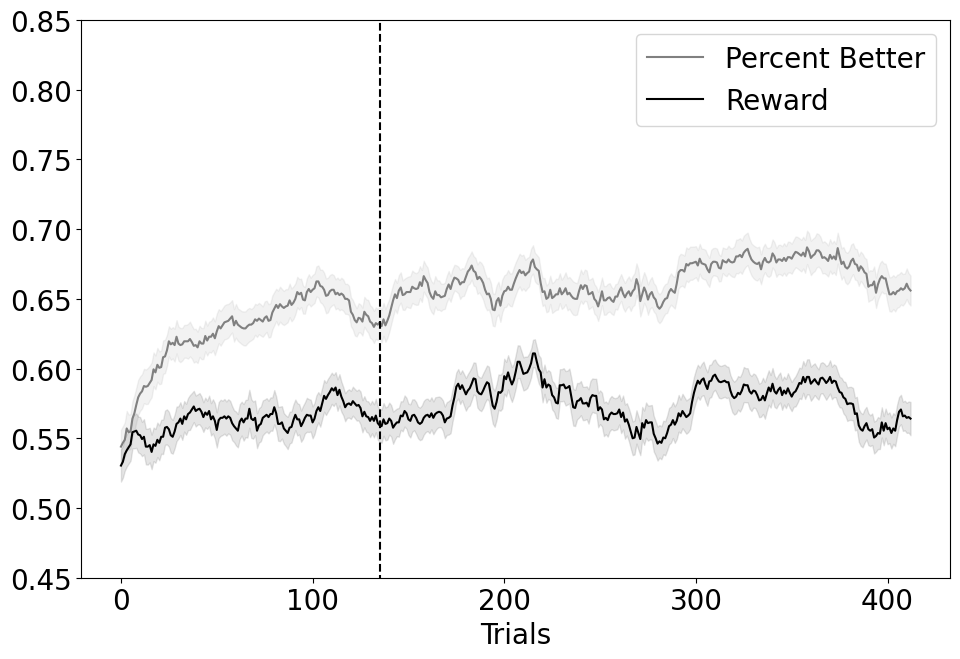

Figure saved at plots/fp_approx/learning_curve.pdf


In [60]:
plot_learning_curve(args, all_saved_states['rewards'], all_saved_states['choose_better'], plot_save_dir)

Finished calculating norm of update
Finished calculating weight norms
Finished calculating variability


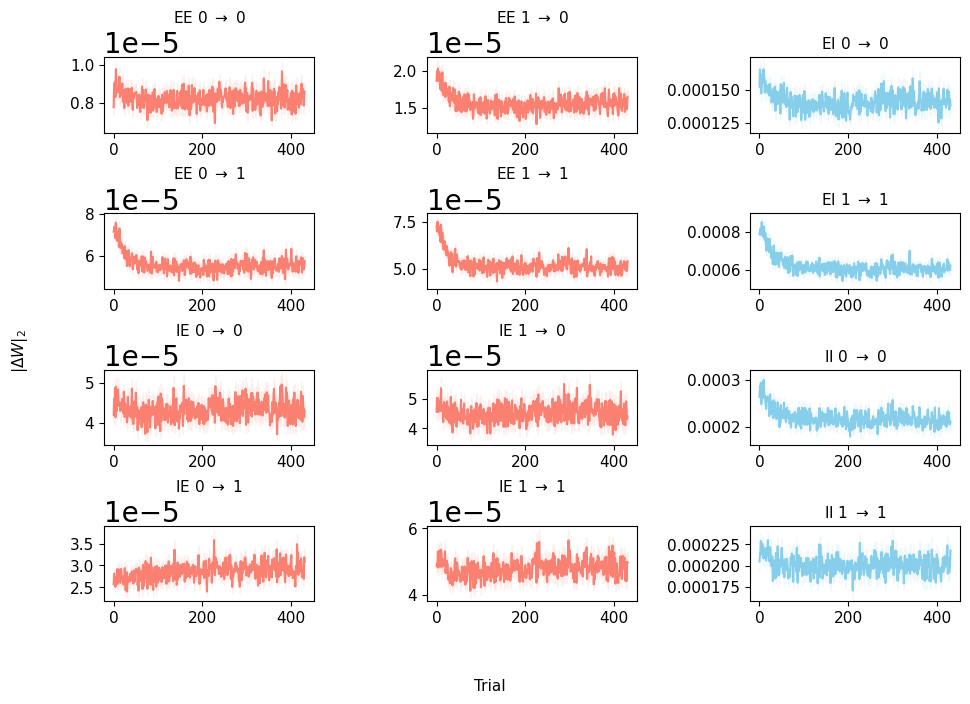

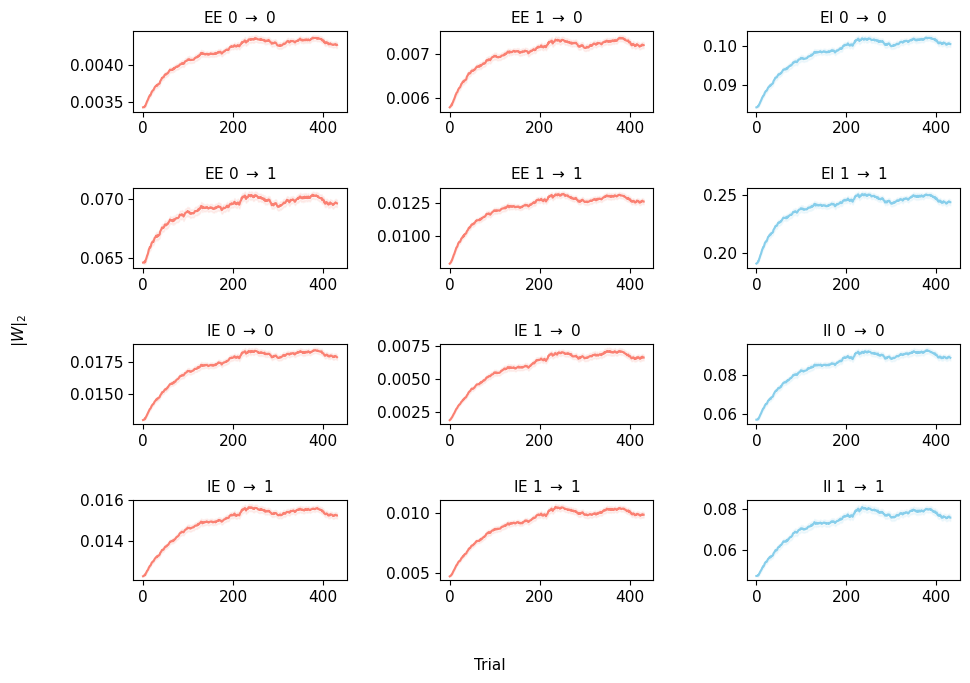

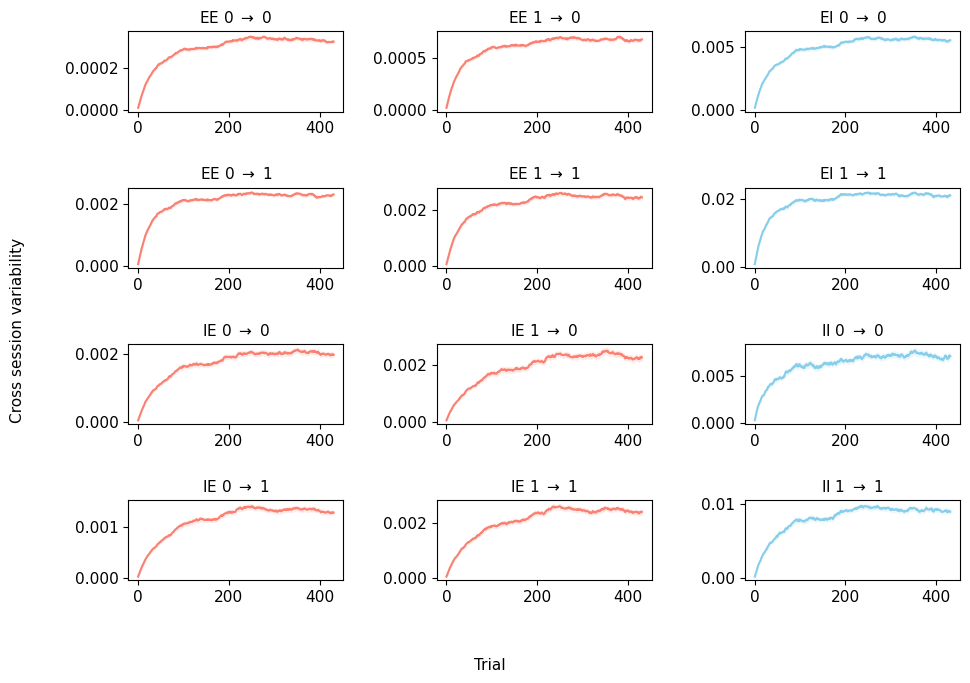

In [61]:
plot_weight_summary(args, all_saved_states['whs']*model.rnn.h2h.mask)

# Behavioral Analysis

In [62]:
def obj_to_ft_conj(obj, task_mdprl):
    F1 = task_mdprl.index_shp[obj]
    F2 = task_mdprl.index_pttrn[obj]
    F3 = task_mdprl.index_clr[obj]

    C1 = task_mdprl.index_pttrnclr[obj]
    C2 = task_mdprl.index_shpclr[obj]
    C3 = task_mdprl.index_shppttrn[obj]

    return np.stack([F1, F2, F3, C1, C2, C3, obj], axis=-1)

def obj_to_value_est(obj, task_mdprl):
    pF1, pF2, pF3, pC1, pC2, pC3, pO = task_mdprl.value_est()

    return pF1[obj], pC1[obj], pO[obj]

def steady_state_choice_analysis(all_saved_states, task_mdprl):
    num_trials = all_saved_states['rewards'].shape[0]
    num_trials_to_fit = np.arange(432-216, num_trials)
    num_subj = all_saved_states['rewards'].shape[2]

    all_Xs = []
    all_Ys = []

    for idx_subj in range(num_subj):
        # stim in sensory space, ntrials X 2
        stims = all_saved_states['stimuli'][num_trials_to_fit,0,idx_subj,:] 
        # stim back to reward schedule space, ntrials X 2
        stims_rwd_mat = task_mdprl.permute_mapping(stims, task_mdprl.test_sensory2stim_idx[idx_subj]) 
        pF1, pC1, pO = obj_to_value_est(stims_rwd_mat, task_mdprl) # ntrials X 2 for each
        # choices are in sensory space, map back to schedule space
        choices = all_saved_states['choices'][num_trials_to_fit,0,idx_subj]==stims[:,1]


        all_Xs.append(np.stack([np.log(pF1[:,1]/pF1[:,0]), 
                                np.log(pC1[:,1]/pC1[:,0]),
                                np.log(pO[:,1]/pO[:,0]),], axis=1))
        all_Ys.append(choices)
        
    all_Xs = np.concatenate(all_Xs, 0)
    all_Ys = np.concatenate(all_Ys, 0)[:, None]
    

    all_data = pd.DataFrame(np.concatenate([all_Xs, all_Ys], axis=1), columns=['pFinf', 'pCinf', 'pO', 'choice']).fillna(0)
    data_group_by_F_m = all_data.groupby('pFinf').mean().apply(np.array).loc[:,'choice']
    data_group_by_F_se = all_data.groupby('pFinf').sem().apply(np.array).loc[:,'choice']
    data_group_by_C_m = all_data.groupby('pCinf').mean().apply(np.array).loc[:,'choice']
    data_group_by_C_se = all_data.groupby('pCinf').sem().apply(np.array).loc[:,'choice']

    fig, axes = plt.subplots()
    fig.set_size_inches((7, 5))
    axes.errorbar(data_group_by_F_m.index.values, 
                 data_group_by_F_m.values, 
                 data_group_by_F_se.values,
                 c=mpl.colormaps['tab10']([0]),
                 ls='', marker='o', mfc='white')
    axes.errorbar(data_group_by_C_m.index.values, 
                 data_group_by_C_m.values, 
                 data_group_by_C_se.values,
                 c=mpl.colormaps['tab10']([3]),
                 ls='', marker='o', mfc='white')
    

    mdl = smf.glm('choice~pFinf+pCinf+pO', all_data, missing='drop', family=sm.families.Binomial())
    mdlf = mdl.fit()
    print(mdlf.summary())
    all_coeffs = mdlf.params[1:]
    all_ses = mdlf.bse[1:]
    all_ps = mdlf.pvalues[1:]

    all_coeffs = np.stack(all_coeffs)
    all_ses = np.stack(all_ses)
    all_ps = np.stack(all_ps)

    var_names = ['F0', 'C0', 'O']
    
    xs = np.linspace(-1., 1., 100)
    
    axes.plot(xs, 1/(1+np.exp(-all_coeffs[0]*xs)), color=mpl.colormaps['tab10']([0]), label='F0')
    axes.plot(xs, 1/(1+np.exp(-all_coeffs[1]*xs)), color=mpl.colormaps['tab10']([3]), label='C0')
    axes.legend()
    
    
    axin = axes.inset_axes([0.65, 0.1, 0.3, 0.3])
    axin.bar(np.arange(1, len(var_names)+1), all_coeffs, color=mpl.colormaps['tab10']([0, 3, 7]))
    axin.errorbar(np.arange(1, len(var_names)+1), all_coeffs, all_ses, linestyle="", color='k')
    axin.text(1, all_coeffs[0]+all_ses[0]+0.05, convert_pvalue_to_asterisks(all_ps[0]), 
            verticalalignment='center', horizontalalignment='center', fontsize=16)
    axin.text(2, all_coeffs[1]+all_ses[1]+0.05, convert_pvalue_to_asterisks(all_ps[1]), 
            verticalalignment='center', horizontalalignment='center', fontsize=16)
    axin.text(3, all_coeffs[2]+np.sign(all_coeffs[2])*(all_ses[2]+0.05), convert_pvalue_to_asterisks(all_ps[2]), 
            verticalalignment='center', horizontalalignment='center', fontsize=16)
    axin.set_ylim([-0.1, 2.6])
    axin.set_xticks(range(1,4), labels=var_names, fontsize=12)
    axin.set_yticks(range(0,3), labels=range(0,3), fontsize=12)
    axin.set_ylabel('Slopes', fontsize=16)
    axes.set_xlabel('Log odd of reward')
    axes.set_ylabel('Choice probability')
    plt.tight_layout()
    sns.despine()
    plt.savefig(os.path.join('plots/', plot_save_dir, "choice_curves_slopes.pdf"))
    print(f'Figure saved at plots/{plot_save_dir}/choice_curves_slopes.pdf')
    plt.show()
    plt.close()
    return


def credit_assignment(all_saved_states, task_mdprl):
    # find chosen feedback, unchosen feedback
    # stimuli torch.Size([432, 1, 92, 2])
    # reward_probs torch.Size([432, 1, 92, 2])
    # choices torch.Size([432, 1, 92])
    # rewards torch.Size([432, 1, 92])
    # choose_better torch.Size([432, 1, 92])
    num_trials = all_saved_states['rewards'].shape[0]
    num_trials_to_fit = np.arange(0, 216-1)
    num_subj = all_saved_states['rewards'].shape[2]
    all_Xs = []
    all_Ys = []

    for idx_subj in range(num_subj):
        
        stims_post_perceptual = all_saved_states['stimuli'][num_trials_to_fit+1,0,idx_subj,:] # ntrials X 2
        stims_post = task_mdprl.permute_mapping(stims_post_perceptual, task_mdprl.test_sensory2stim_idx[idx_subj]) 
        stims_pre_chosen_perceptual = all_saved_states['choices'][num_trials_to_fit,0,idx_subj] # ntrials
        stims_pre_chosen = task_mdprl.permute_mapping(stims_pre_chosen_perceptual, task_mdprl.test_sensory2stim_idx[idx_subj]) 
        choices = all_saved_states['choices'][num_trials_to_fit+1,0,idx_subj]
        choices = task_mdprl.permute_mapping(choices, task_mdprl.test_sensory2stim_idx[idx_subj]) 
        choices = choices==stims_post[:,1]
        rwd_pre = 2*all_saved_states['rewards'][num_trials_to_fit,0,idx_subj]-1 # ntrials
        
        stimsFCO_pre_chosen = obj_to_ft_conj(stims_pre_chosen, task_mdprl) # ntrials X 7
        stimsFCO_post = obj_to_ft_conj(stims_post, task_mdprl) # ntrials X 2 X 7
        
        
        # predictors are inf dim R chosen, inf dim C chosen, noninf dim R chosen, noninf dim C chosen, 
        subj_Xs = np.concatenate([rwd_pre[:,None]*(stimsFCO_pre_chosen==stimsFCO_post[:,1,:])-
                                  rwd_pre[:,None]*(stimsFCO_pre_chosen==stimsFCO_post[:,0,:]),\
                                  1.0*(stimsFCO_pre_chosen==stimsFCO_post[:,1,:])-
                                  1.0*(stimsFCO_pre_chosen==stimsFCO_post[:,0,:])], axis=-1)
        
        all_Xs.append(subj_Xs)
        all_Ys.append(choices)

    all_Xs = np.concatenate(all_Xs, axis=0)
    all_Ys = np.concatenate(all_Ys, axis=0)[:,None]
    
    var_names = ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O']
    rw_ch = ['R', 'C']

    all_var_names = ['_'.join([s, 'R']) for s in var_names] + ['_'.join([s, 'C']) for s in var_names]

    all_data = pd.DataFrame(np.concatenate([all_Xs, all_Ys], axis=1), columns=[*all_var_names, 'choice'])

    mdl = smf.glm('choice~'+'+'.join(all_var_names), data=all_data, family=sm.families.Binomial())
    mdlf = mdl.fit()
    print(mdlf.summary())
    all_coeffs = mdlf.params[1:].to_numpy()
    all_ses = mdlf.bse[1:].to_numpy()
    all_ps = mdlf.pvalues[1:].to_numpy()

    all_xlabels = var_names

    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches((10, 5))
    
    bar_rw = axes[0].bar(x=np.arange(1,len(var_names)+1), \
                height=all_coeffs[:len(var_names)], \
                yerr=all_ses[:len(var_names)], \
                color=mpl.colormaps['tab10'](np.arange(0,7)), 
                capsize=5)
    bar_ch = axes[1].bar(x=np.arange(1,len(var_names)+1), \
                height=all_coeffs[len(var_names):], \
                yerr=all_ses[len(var_names):], \
                color=mpl.colormaps['tab10'](np.arange(0,7)), 
                capsize=5)
    axes[0].set_ylabel('Regression weights')
    axes[0].set_xlabel('Win-stay lose-switch')
    axes[1].set_xlabel('Choice autocorrelation')
    axes[0].set_ylim([-0.25, 0.65])
    axes[1].set_ylim([-0.25, 0.65])
    axes[0].set_xticks(np.arange(1, len(var_names)+1), labels=all_xlabels)
    axes[1].set_xticks(np.arange(1, len(var_names)+1), labels=all_xlabels)
    for i in range(len(var_names)):
        axes[0].text(i+1, all_coeffs[i]+np.sign(all_coeffs[i])*(all_ses[i]+0.02)-0.01, 
                     convert_pvalue_to_asterisks(all_ps[i]), 
                     verticalalignment='center', horizontalalignment='center')
        
    for i in range(len(var_names)):
        axes[1].text(i+1, all_coeffs[i+len(var_names)]+np.sign(all_coeffs[i+len(var_names)])*(all_ses[i+len(var_names)]+0.02)-0.01, 
                     convert_pvalue_to_asterisks(all_ps[i+len(var_names)]), 
                     verticalalignment='center', horizontalalignment='center')
    plt.tight_layout()
    sns.despine()
    with PdfPages(f'plots/{plot_save_dir}/credit_assignment.pdf') as pdf:
        pdf.savefig(fig)
        print(f'Figure saved at plots/{plot_save_dir}/credit_assignment.pdf')
    plt.show()
    plt.close()
    return


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 choice   No. Observations:                19872
Model:                            GLM   Df Residuals:                    19868
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12076.
Date:                Mon, 20 Nov 2023   Deviance:                       24152.
Time:                        14:05:41   Pearson chi2:                 1.99e+04
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1571
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0043      0.015      0.279      0.7

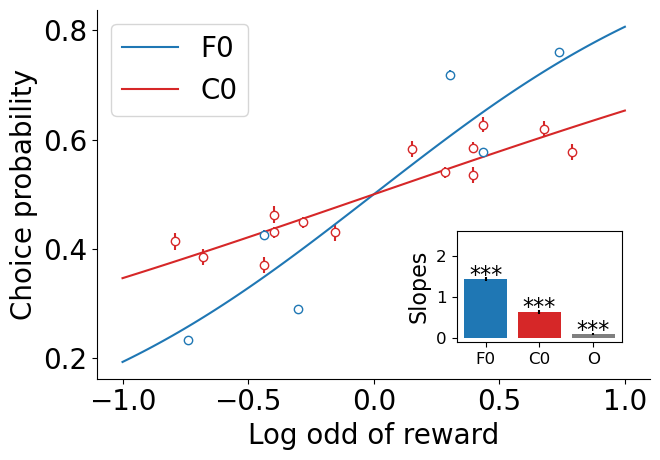

In [63]:
steady_state_choice_analysis(all_saved_states, task_mdprl)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 choice   No. Observations:                19780
Model:                            GLM   Df Residuals:                    19765
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13504.
Date:                Mon, 20 Nov 2023   Deviance:                       27008.
Time:                        14:05:43   Pearson chi2:                 1.98e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.02063
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0032      0.014     -0.222      0.8

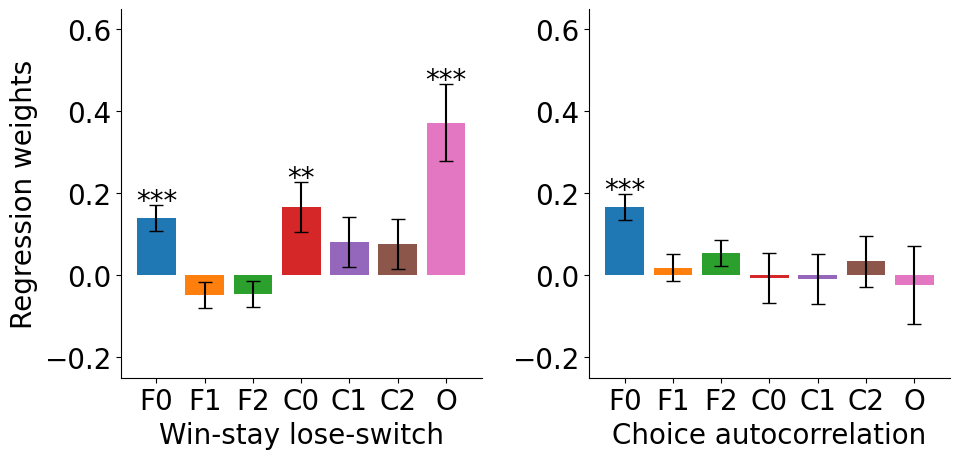

In [64]:
credit_assignment(all_saved_states, task_mdprl)

tensor(0.)


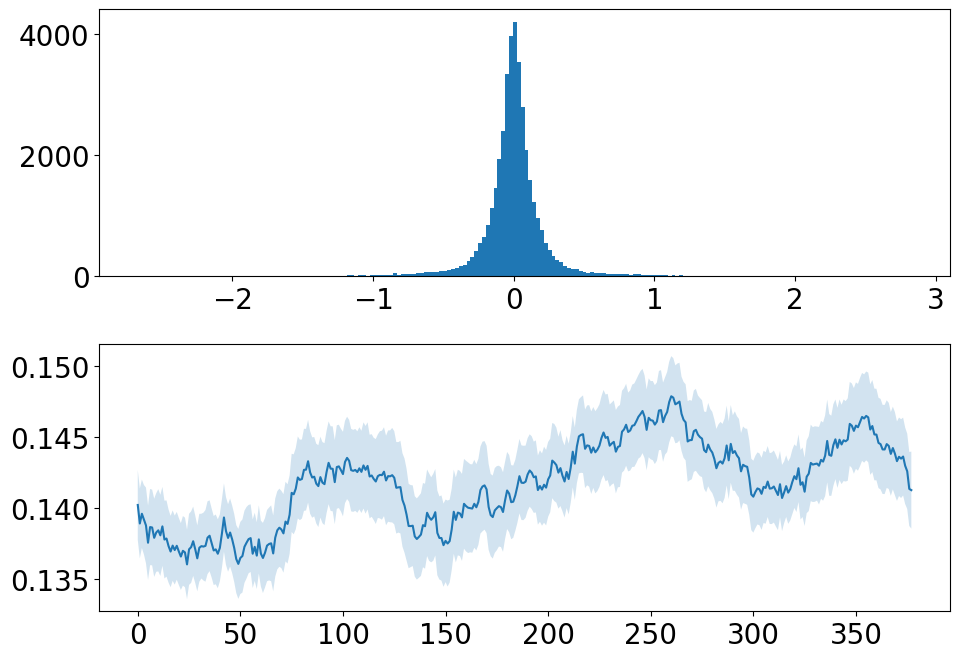

In [119]:
print(torch.sum((torch.abs(all_saved_states['sensitivity'][1:])>5).float()))
plt.subplot(211).hist((all_saved_states['sensitivity'][1:]).flatten().numpy(), bins=200);


w_size=432//8
smth_sensitivity = np.stack([
    np.convolve(sens, np.ones(w_size)/w_size, mode='valid')
        for sens in all_saved_states['sensitivity'].abs().squeeze().numpy()[1:].T]).T

plt.subplot(212).plot(smth_sensitivity.mean(1))
plt.subplot(212).fill_between(np.arange(smth_sensitivity.shape[0]), 
                              smth_sensitivity.mean(1)+smth_sensitivity.std(1)/np.sqrt(smth_sensitivity.shape[1]),
                              smth_sensitivity.mean(1)-smth_sensitivity.std(1)/np.sqrt(smth_sensitivity.shape[1]),
                             alpha=0.2)
plt.tight_layout()

In [66]:
def sensitivity_regression(all_saved_states, task_mdprl):
    # find chosen feedback, unchosen feedback
    # stimuli torch.Size([432, 1, 92, 2])
    # reward_probs torch.Size([432, 1, 92, 2])
    # choices torch.Size([432, 1, 92])
    # rewards torch.Size([432, 1, 92])
    # choose_better torch.Size([432, 1, 92])
    num_trials = all_saved_states['rewards'].shape[0]
    num_trials_to_fit = np.arange(0, 216-1)
    num_subj = all_saved_states['rewards'].shape[2]
    all_Xs = []
    all_Ys = []

    for idx_subj in range(num_subj):
#     for idx_subj in [90]:
#         print(task_mdprl.test_stim_dim_order[idx_subj])
        stims_post = all_saved_states['stimuli'][num_trials_to_fit+1,0,idx_subj,:] # ntrials X 2
        stims_post = task_mdprl.permute_mapping(stims_post, task_mdprl.test_sensory2stim_idx[idx_subj]) 
        stims_pre_chosen = all_saved_states['choices'][num_trials_to_fit,0,idx_subj] # ntrials
        stims_pre_chosen = task_mdprl.permute_mapping(stims_pre_chosen, task_mdprl.test_sensory2stim_idx[idx_subj]) 
        sensitivity = all_saved_states['sensitivity'][num_trials_to_fit+1,0,idx_subj]
        
        stimsFCO_pre_chosen = obj_to_ft_conj(stims_pre_chosen, task_mdprl) # ntrials X 7
        stimsFCO_post = obj_to_ft_conj(stims_post, task_mdprl) # ntrials X 2 X 7
        
        
        subj_Xs = 1.0*(stimsFCO_pre_chosen==stimsFCO_post[:,1,:])-1.0*(stimsFCO_pre_chosen==stimsFCO_post[:,0,:])
        
        all_Xs.append(subj_Xs)
        all_Ys.append(sensitivity)

    all_Xs = np.concatenate(all_Xs, axis=0)
    all_Ys = np.concatenate(all_Ys, axis=0)[:,None]
    
    var_names = ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O']
    
    all_data = pd.DataFrame(np.concatenate([all_Xs, all_Ys], axis=1), columns=[*var_names, 'sensitivity'])
    

    mdl = smf.ols('sensitivity~'+'+'.join(var_names), data=all_data)
    mdlf = mdl.fit()
    print(mdlf.summary())
    all_coeffs = mdlf.params[1:]
    all_ses = mdlf.bse[1:]
    all_ps = mdlf.pvalues[1:]
    
    
    print(mdlf.t_test(np.array([[0,1,-1,0,0,0,0,0],
                                [0,1,0,-1,0,0,0,0],
                                [0,0,1,-1,0,0,0,0],
                                [0,0,0,0,1,-1,0,0],
                                [0,0,0,0,1,0,-1,0],
                                [0,0,0,0,0,1,-1,0]])))

    all_xlabels = var_names

    fig, axes = plt.subplots(figsize=(8,6))
    
    bar_rw = axes.bar(x=np.arange(1,len(var_names)+1), \
                height=all_coeffs[:len(var_names)], \
                yerr=all_ses[:len(var_names)], \
                color=mpl.colormaps['tab10'](np.arange(0,7)), 
                capsize=5)

    axes.set_ylabel('Regression weights')
    axes.set_xlabel('Shared dimension')
    axes.set_ylim(np.array(axes.get_ylim())*1.1)
    axes.set_xticks(np.arange(1, len(var_names)+1), labels=all_xlabels)
    for i in range(len(var_names)):
        axes.text(i+1, all_coeffs[i]+np.sign(all_coeffs[i])*(all_ses[i]+0.02)-0.01, 
                     convert_pvalue_to_asterisks(all_ps[i]), 
                     verticalalignment='center', horizontalalignment='center')
        
    plt.tight_layout()
    sns.despine()
#     with PdfPages(f'plots/{plot_save_dir}/credit_assignment.pdf') as pdf:
#         pdf.savefig(fig)
#         print(f'Figure saved at plots/{plot_save_dir}/credit_assignment.pdf')
    plt.show()
    plt.close()
    return


                            OLS Regression Results                            
Dep. Variable:            sensitivity   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     4056.
Date:                Mon, 20 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:05:54   Log-Likelihood:                 9066.1
No. Observations:               19780   AIC:                        -1.812e+04
Df Residuals:                   19772   BIC:                        -1.805e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0007      0.001      0.607      0.5

/scratch/ipykernel_25342/1330237976.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes.text(i+1, all_coeffs[i]+np.sign(all_coeffs[i])*(all_ses[i]+0.02)-0.01,
/scratch/ipykernel_25342/1330237976.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  convert_pvalue_to_asterisks(all_ps[i]),


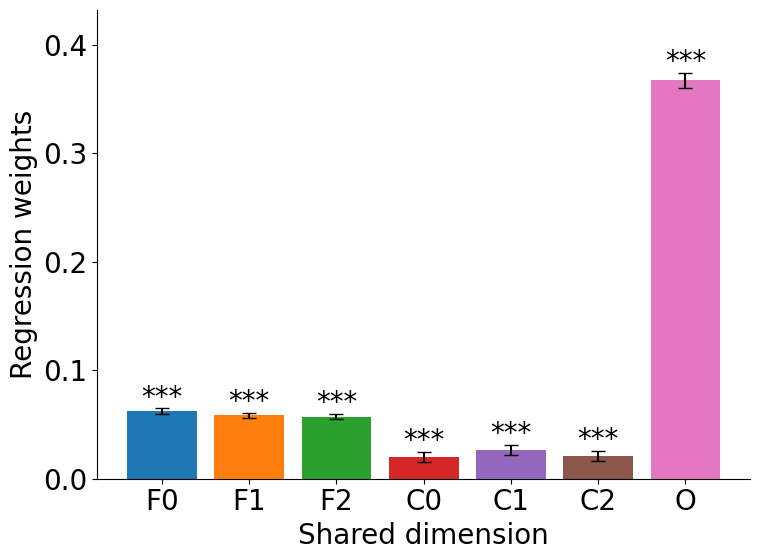

In [67]:
sensitivity_regression(all_saved_states, task_mdprl)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                39652
Model:                            GLM   Df Residuals:                    39650
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -27200.
Date:                Mon, 20 Nov 2023   Deviance:                       54399.
Time:                        14:18:35   Pearson chi2:                 3.97e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01428
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.010      0.169      0.8

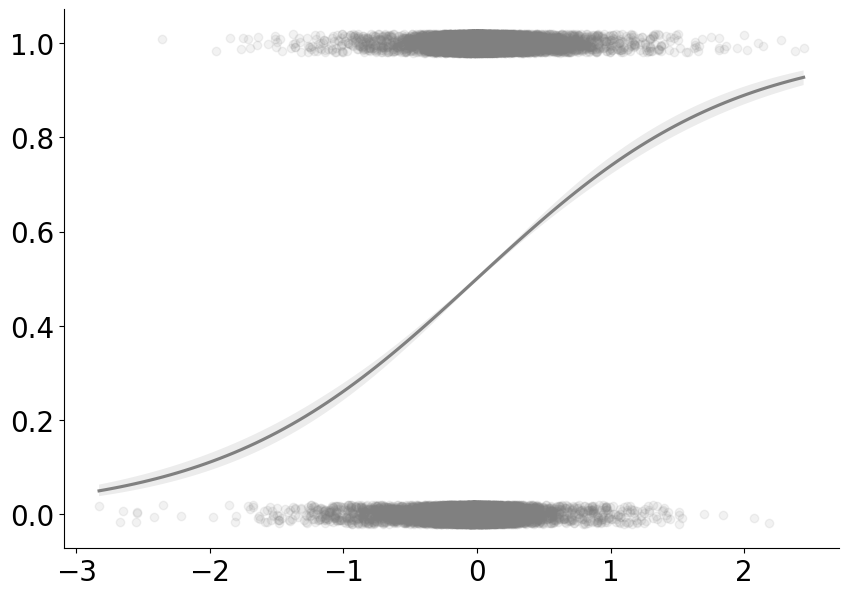

In [117]:
import statsmodels.api as sm


RXsensitivity = sm.add_constant(((2*all_saved_states['rewards'][:-1]-1)*all_saved_states['sensitivity'][1:]).flatten().numpy())
choices = (all_saved_states['choices'][1:]==all_saved_states['stimuli'][1:,...,1]).long().flatten().numpy()
log_reg_choice_sensitivity = sm.GLM(choices, RXsensitivity, family=sm.families.Binomial()).fit()

print(log_reg_choice_sensitivity.summary())

# plt.plot(np.linspace(-4, 4, 100), 1/(1+np.exp(-0.4214*np.linspace(-4, 4, 100))))
# plt.scatter(((2*all_saved_states['rewards'][:-1]-1)*all_saved_states['sensitivity'][1:]).flatten().numpy(),
#             (all_saved_states['choices'][1:]==all_saved_states['stimuli'][1:,...,1]).long().flatten().numpy(),
#            alpha=0.01)


sns.regplot(x=((2*all_saved_states['rewards'][:-1]-1)*all_saved_states['sensitivity'][1:]).flatten().numpy(),
            y=(all_saved_states['choices'][1:]==all_saved_states['stimuli'][1:,...,1]).long().flatten().numpy(),
            n_boot=100, logistic=True, y_jitter=0.02, color='grey', scatter_kws={'alpha': 0.1})
sns.despine()
# sns.kdeplot(x=((2*all_saved_states['rewards'][:-1]-1)*all_saved_states['sensitivity'][1:]).flatten().numpy(),
#            hue=(all_saved_states['choices'][1:]==all_saved_states['stimuli'][1:,...,1]).long().flatten().numpy())

# plt.xlim([-5, 5])


# Plot Initial Connectivity

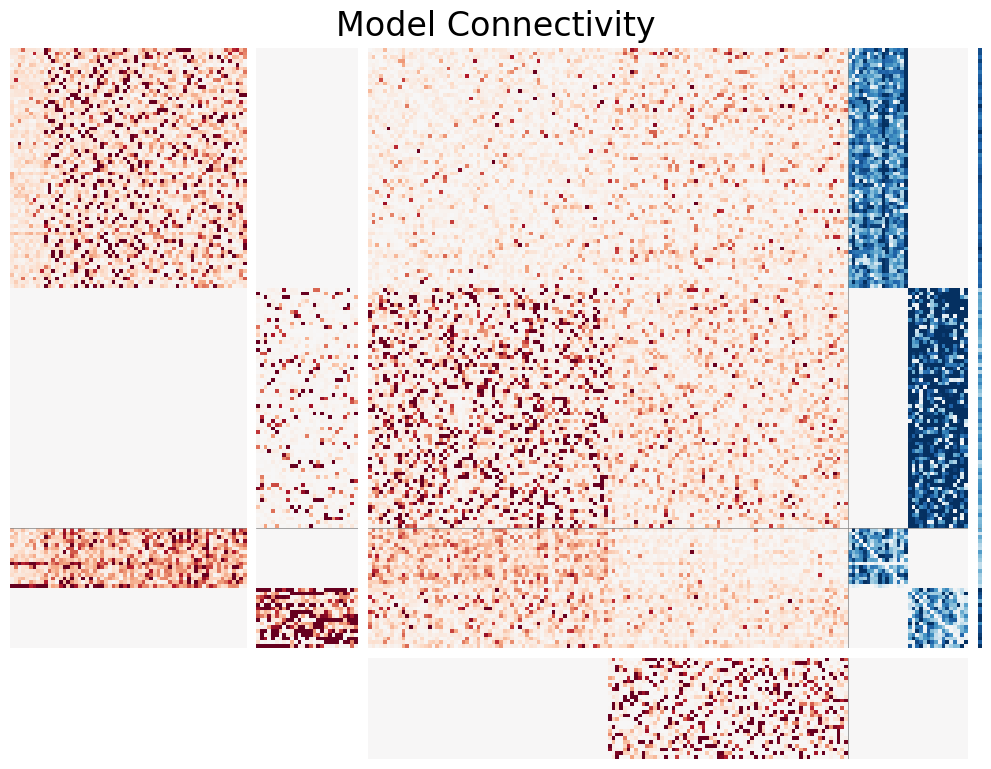

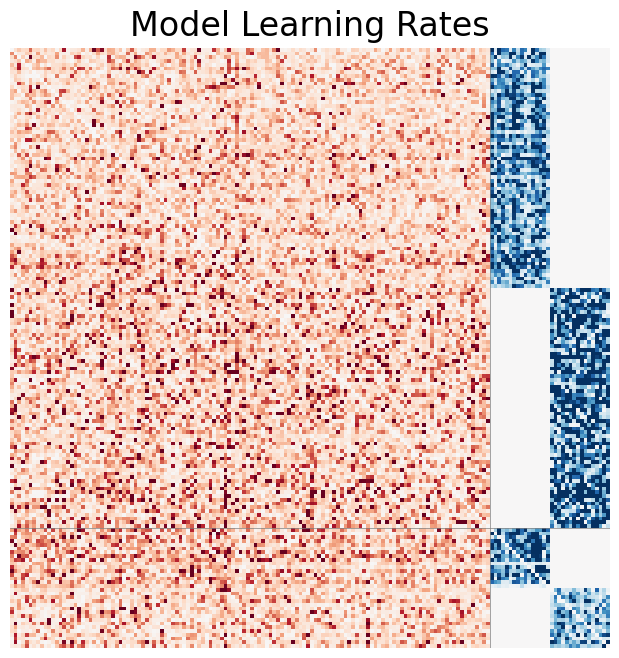

In [69]:
model_vis_idx = 0
plot_connectivity_lr(torch.arange(args['hidden_size']*args['num_areas']), 
                             x2hw=all_models[model_vis_idx].rnn.x2h.effective_weight().detach(),
                             h2hw=all_models[model_vis_idx].rnn.h2h.effective_weight().detach(),
                             hb=all_models[model_vis_idx].rnn.h2h.bias.detach(),
                             h2ow=torch.cat([torch.zeros(27, E_SIZE), all_models[model_vis_idx].h2o.effective_weight().detach(), torch.zeros(27, I_SIZE*2)], dim=1),
                             aux2h=all_models[model_vis_idx].rnn.aux2h.effective_weight().detach(),
                             kappa_rec=all_models[model_vis_idx].plasticity.kappa.squeeze().abs().detach()*model.rnn.h2h.mask,
                             e_size=int(args['e_prop']*args['hidden_size'])*args['num_areas'], args=args)

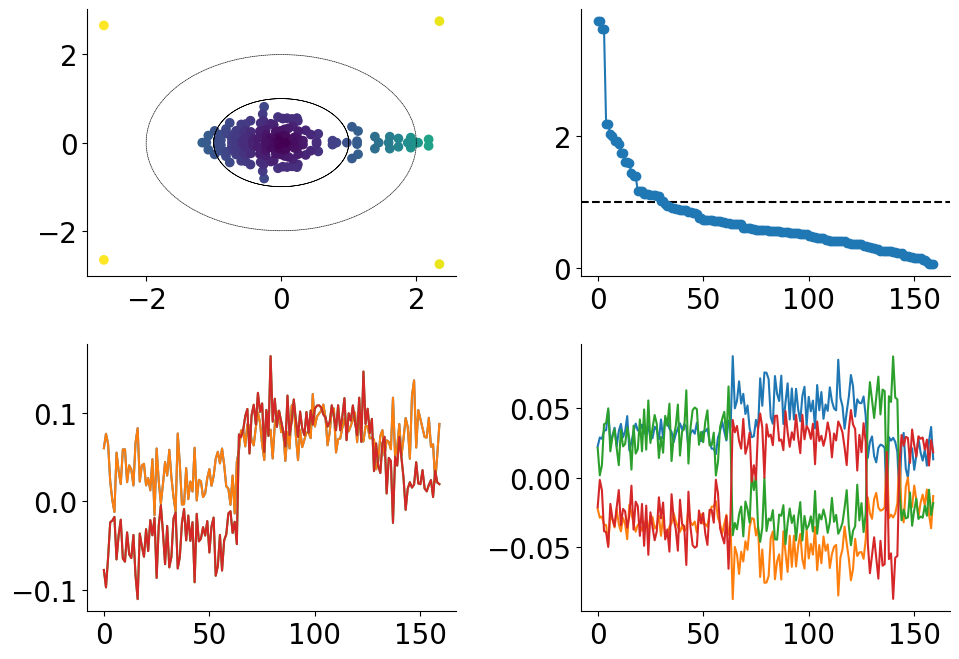

In [70]:
fig, axes = plt.subplots(2,2)

axes[0,0].plot(np.cos(np.linspace(-2*np.pi,2*np.pi,100)),\
                   np.sin(np.linspace(-2*np.pi,2*np.pi,100)), \
                   'k-', linewidth=0.5)
axes[0,0].plot(2*np.cos(np.linspace(-2*np.pi,2*np.pi,100)),\
                   2*np.sin(np.linspace(-2*np.pi,2*np.pi,100)), \
                   'k:', linewidth=0.5)
axes[0,1].axhline(1, linestyle='--', color='k')

for model in all_models:
    h2h = model.rnn.h2h.effective_weight().detach()
    axes[0,0].scatter(torch.linalg.eig(h2h).eigenvalues.real, 
                torch.linalg.eig(h2h).eigenvalues.imag,
                c=torch.linalg.eig(h2h).eigenvalues.abs(),
                alpha=1/len(all_models))
    axes[0,1].plot(torch.sort(torch.linalg.eig(h2h).eigenvalues.abs(), descending=True)[0], '-o',
                  alpha=1/len(all_models))
    bad_eigs = torch.linalg.eig(h2h).eigenvalues.abs()>=torch.sort(torch.linalg.eig(h2h).eigenvalues.abs())[0][-3]
    axes[1,0].plot(torch.linalg.eig(h2h).eigenvectors.real[:,bad_eigs].numpy())
    axes[1,1].plot(torch.linalg.eig(h2h).eigenvectors.imag[:,bad_eigs].numpy())

# axes[0,1].set_yscale('log')
sns.despine()
plt.tight_layout()
    

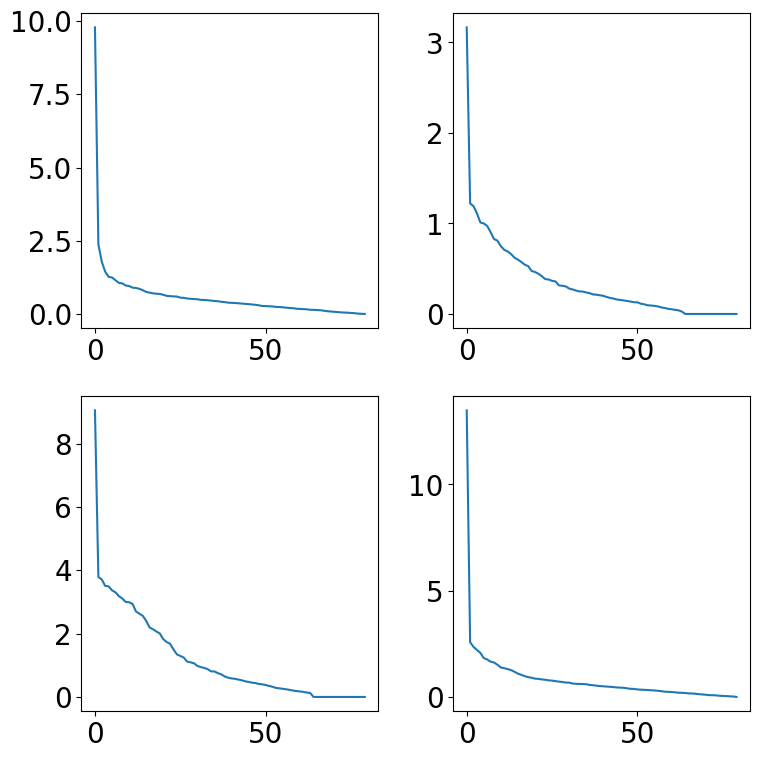

In [71]:
all_model_rec_intra = []
all_model_rec_inter_ff = []
all_model_rec_inter_fb = []

fig, axes = plt.subplots(NUM_AREAS, NUM_AREAS, figsize=(8,8))

# for i in range(NUM_AREAS):
#     axes[i,i].plot(np.cos(np.linspace(-2*np.pi,2*np.pi,100)),\
#                    np.sin(np.linspace(-2*np.pi,2*np.pi,100)), \
#                    'k--', linewidth=0.2)

for model in all_models:
    h2h = model.rnn.h2h.effective_weight().detach()

    rec_intra = []
#     us = []
#     vhs = []
    ss = []
    for i in range(NUM_AREAS):
        rec_intra.append(h2h[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                             list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))]
                          [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                             list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
        u, sv, vh = np.linalg.svd(rec_intra[i], full_matrices=False)
#         s = np.linalg.eigvals(rec_intra[i])
    #     us.append(u)
    #     vhs.append(vh)
        ss.append(sv)

    #     axes[i,1].hlines(0.95, 0, 80, colors='grey', linestyles='dashed')
    
    all_model_rec_intra.append(rec_intra)

    rec_inter_ff = []
    rec_inter_fb = []
#     us_ff = []
#     us_fb = []
#     vhs_ff = []
#     vhs_fb = []
    ss_ff = []
    ss_fb = []
    for i in range(NUM_AREAS-1):
        rec_inter_ff.append(h2h[list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                                list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))]
                             [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
        rec_inter_fb.append(h2h[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))]
                             [:,list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                                list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))])
        _, s, _ = np.linalg.svd(rec_inter_ff[i], full_matrices=False)
#        us_ff.append(u)
#        vhs_ff.append(vh)
        ss_ff.append(s)
        _, s, _ = np.linalg.svd(rec_inter_fb[i], full_matrices=False)
#        us_fb.append(u)
#        vhs_fb.append(vh)
        ss_fb.append(s)
        
    all_model_rec_inter_ff.append(rec_inter_ff)
    all_model_rec_inter_fb.append(rec_inter_fb)


    for i in range(NUM_AREAS):
#         axes[i,i].scatter(ss[i].real, ss[i].imag, alpha=1/len(all_models))
        axes[i,i].plot(np.arange(0,args['hidden_size']),ss[i],'-', alpha=1/len(all_models))

    for i in range(NUM_AREAS-1):
        axes[1,0].plot(np.arange(0,args['hidden_size']),ss_ff[i],'-', alpha=1/len(all_models))
        axes[0,1].plot(np.arange(0,args['hidden_size']),ss_fb[i],'-', alpha=1/len(all_models))


plt.tight_layout()
plt.show()

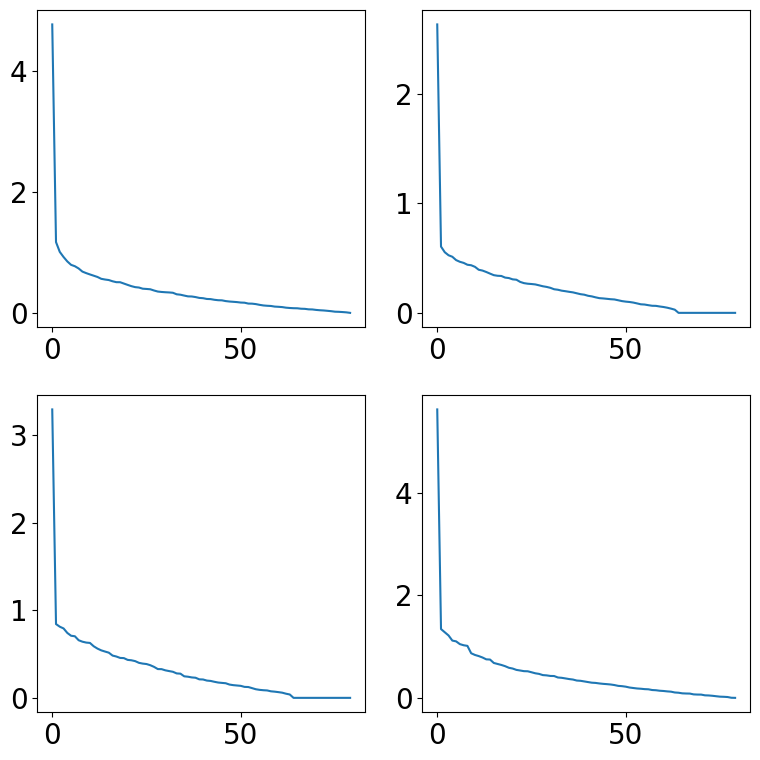

In [72]:
all_model_kappa_rec_intra = []
all_model_kappa_inter_ff = []
all_model_kappa_inter_fb = []

fig, axes = plt.subplots(2,2, figsize=(8,8))

for model in all_models:

    kappa_rec = model.plasticity.kappa.abs().detach()*model.rnn.h2h.mask

    kappa_rec_intra = []
    us = []
    vhs = []
    ss = []
    for i in range(NUM_AREAS):
        kappa_rec_intra.append(kappa_rec[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                   list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))]
                                  [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                     list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
        u, s, vh = np.linalg.svd(kappa_rec_intra[i], full_matrices=False)
    #     s = np.linalg.eigvals(kappa_rec_intra[i])
#         us.append(u)
#         vhs.append(vh)
        ss.append(s)
        
    all_model_kappa_rec_intra.append(kappa_rec_intra)
    
    for i in range(NUM_AREAS):
        axes[i,i].plot(np.arange(0,args['hidden_size']), ss[i][:], '-', alpha=1/len(all_models))
        
    
    kappa_inter_ff = []
    kappa_inter_fb = []
    us_ff = []
    us_fb = []
    vhs_ff = []
    vhs_fb = []
    ss_ff = []
    ss_fb = []
    for i in range(NUM_AREAS-1):
        kappa_inter_ff.append(kappa_rec[list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                                     list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))]
                                 [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                    list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
        kappa_inter_fb.append(kappa_rec[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                     list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))]
                                    [:,list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                                       list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))])
        u, s, vh = np.linalg.svd(kappa_inter_ff[i], full_matrices=False)
#        us_ff.append(u)
#        vhs_ff.append(vh)
        ss_ff.append(s)
        u, s, vh = np.linalg.svd(kappa_inter_fb[i], full_matrices=False)
#        us_fb.append(u)
#        vhs_fb.append(vh)
        ss_fb.append(s)
        
    all_model_kappa_inter_ff.append(kappa_inter_ff)
    all_model_kappa_inter_fb.append(kappa_inter_fb)

    
    axes[1,0].plot(np.arange(0,args['hidden_size']), ss_ff[0][:], '-', alpha=1/len(all_models))
    axes[0,1].plot(np.arange(0,args['hidden_size']), ss_fb[0][:], '-', alpha=1/len(all_models))

plt.tight_layout()
plt.show()

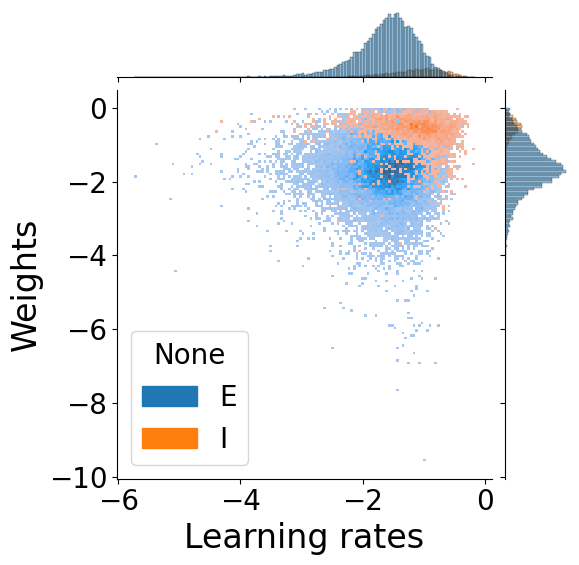

In [73]:

ei_label = np.empty(torch.sum(all_models[model_vis_idx].rnn.h2h.mask.squeeze().flatten().abs()>0).long().item(), dtype=object)
ei_label[model.rnn.h2h.mask.squeeze().flatten()[all_models[model_vis_idx].rnn.h2h.mask.squeeze().flatten().abs()>0]>0] = 'E'
ei_label[model.rnn.h2h.mask.squeeze().flatten()[all_models[model_vis_idx].rnn.h2h.mask.squeeze().flatten().abs()>0]<0] = 'I'
sjp = sns.jointplot(x=np.log10(all_models[model_vis_idx].plasticity.kappa.squeeze().abs().detach().flatten()[all_models[model_vis_idx].rnn.h2h.mask.squeeze().flatten().abs()>0]),
                    y=np.log10(all_models[model_vis_idx].rnn.h2h.effective_weight().detach().flatten().abs()[all_models[model_vis_idx].rnn.h2h.mask.squeeze().flatten().abs()>0]),
                    hue=ei_label, kind='hist')
sjp.set_axis_labels('Learning rates', 'Weights', fontsize=24)
sns.move_legend(sjp.ax_joint, 'lower left')
# plt.xlim([-6.1, 0.2])
# plt.ylim([-8.1, 0.2])
plt.show()

# a, b = np.polyfit(np.log10(model.rnn.kappa_rec.squeeze().abs().detach().flatten()[model.rnn.h2h.mask.squeeze().flatten().abs()>0]), \
#                   np.log10(model.rnn.h2h.effective_weight().detach().flatten().abs()[model.rnn.h2h.mask.squeeze().flatten().abs()>0]), 1)
# plt.plot(np.linspace(-4, 0, 100), a*np.linspace(-4, 0, 100)+b, c='k')
# stats.spearmanr(np.log10(model.rnn.kappa_rec.squeeze().abs().detach().flatten()[model.rnn.h2h.mask.squeeze().flatten().abs()>0]), \
#                 np.log10(model.rnn.h2h.effective_weight().detach().flatten().abs()[model.rnn.h2h.mask.squeeze().flatten().abs()>0]))

# Subspace Analysis


### Decompose each input, output, and choice pattern as a sum of feature, conjunction, and object patterns
$I_{i} = I_{ft}(i)+I_{conj}(i)+I_{obj}(i)$

In [74]:
input_weight_inds = list(range(E_SIZE)) + list(range(E_SIZE*args['num_areas'], E_SIZE*args['num_areas']+I_SIZE))
output_weight_inds = list(range(E_SIZE, 2*E_SIZE)) + list(range(E_SIZE*args['num_areas']+I_SIZE, E_SIZE*args['num_areas']+2*I_SIZE))


all_model_stims = []


for model in all_models:
    stims, global_avg_in, ft_avg_in, conj_avg_in, obj_avg_in = get_input_encodings(
        model.rnn.x2h.effective_weight()[input_weight_inds].detach().numpy(), 
        task_mdprl.stim_encoding('all_onehot'))
    all_model_stims.append(stims)


## Use dPCA to get ft/conj/obj specific axes in the input and output weights

In [75]:
n_components_for_dpca = {'s':2, 'p':2, 'c':2, 'sc':4, 'sp':4, 'pc':4, 'spc': 8}


all_model_dpca_in = []
all_model_dpca_out = []
all_model_dpca_ch = []


all_model_low_input = []
all_model_low_output = []
all_model_low_ch = []

for model_idx, model in enumerate(all_models):
    dpca_in = dPCA.dPCA('spc', n_components=n_components_for_dpca, regularizer=None)
    low_input = dpca_in.fit_transform(all_model_stims[model_idx].reshape((args['hidden_size'],3,3,3)))

    expanded_h2o = torch.cat([model.h2o.effective_weight().detach(), torch.zeros(27, I_SIZE)], dim=1)
    dpca_out = dPCA.dPCA('spc', n_components=n_components_for_dpca, regularizer=None)
    low_output = dpca_out.fit_transform(expanded_h2o.numpy().T.reshape((args['hidden_size'],3,3,3)))

    dpca_ch = dPCA.dPCA('spc', n_components=n_components_for_dpca, regularizer=None)
    low_ch = dpca_ch.fit_transform(model.rnn.aux2h.effective_weight().detach().numpy()\
                                   [list(range(E_SIZE, E_SIZE*2))+list(range(E_SIZE*2+I_SIZE, E_SIZE*2+I_SIZE*2)),:]\
                                   .reshape((args['hidden_size'],3,3,3)))

    all_model_low_input.append(low_input)
    all_model_low_output.append(low_output)
    all_model_low_ch.append(low_ch)
    
    all_model_dpca_in.append(dpca_in)
    all_model_dpca_out.append(dpca_out)
    all_model_dpca_ch.append(dpca_ch)

#     dpca_stim = dPCA.dPCA('spc', n_components=n_components_for_dpca, regularizer=None)
#     low_stims = dpca_stim.fit_transform(task_mdprl.stim_encoding('all_onehot').T.reshape((63,3,3,3)))


/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN/rnn/dPCA/dPCA.py:980: RuntimeWarning: invalid value encountered in divide
  return [1 - np.sum((Xr - P[:,k:k+1]@(D[:,k:k+1].T@Xr))**2, -1) / (unitwise_variance) for k in range(D.shape[1])]


/scratch/ipykernel_25342/2707457534.py:41: RuntimeWarning: Mean of empty slice
  unitwise_selectivity_output[model_idx,:,1] = np.nanmean(curr_model_unitwise_selectivity[:,E_SIZE:], 1)


Figure saved at plots/fp_approx/selectivity_profile.pdf


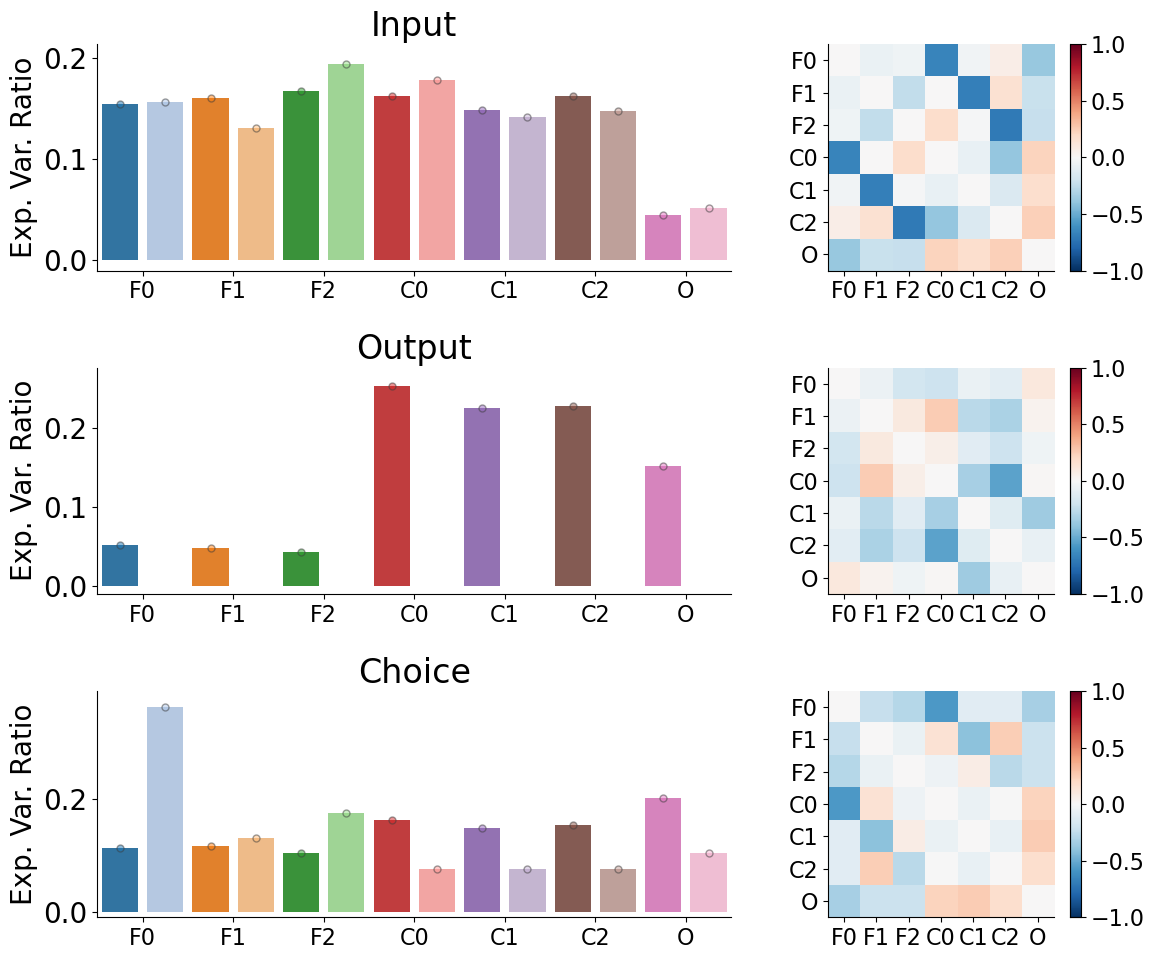

In [76]:
fig, axes = plt.subplots(3, 2, width_ratios=(2, 1), figsize=(12,10))

corr_scale = 1.0

xxx_for_plot = np.repeat(np.arange(14)[None], len(all_models), axis=0)
xxx_for_plot[xxx_for_plot%2==0]=xxx_for_plot[xxx_for_plot%2==0]
xxx_for_plot[xxx_for_plot%2==1]=xxx_for_plot[xxx_for_plot%2==1]

unitwise_selectivity_input = np.zeros((len(all_models), 7, 2))
selelctivity_corr_input = np.zeros((len(all_models), 7, 7))
for model_idx, model in enumerate(all_models):
    curr_model_unitwise_selectivity = np.zeros((7, args['hidden_size']))
    for k_idx, k in enumerate(['s','p','c','pc','sc','sp','spc']):
        curr_model_unitwise_selectivity[k_idx] = \
            np.sum(all_model_dpca_in[model_idx].unitwise_explained_variance_ratio_[k], 0)
    unitwise_selectivity_input[model_idx,:,0] = np.mean(curr_model_unitwise_selectivity[:,:E_SIZE], 1)
    unitwise_selectivity_input[model_idx,:,1] = np.mean(curr_model_unitwise_selectivity[:,E_SIZE:], 1)
#     selelctivity_corr_input[model_idx] = np.corrcoef(curr_model_unitwise_selectivity)-np.eye(7)
    selelctivity_corr_input[model_idx] = stats.spearmanr(curr_model_unitwise_selectivity.T).statistic-np.eye(7)
# axes[0,0].imshow(unitwise_selectivity_input.mean(0).T, aspect='auto', cmap='hot', vmin=0, vmax=1)
sns.barplot(ax=axes[0,0], x=xxx_for_plot.flatten(), hue=xxx_for_plot.flatten(),
            y=unitwise_selectivity_input.flatten(),
            palette='tab20', errorbar=None, legend=False)
sns.stripplot(ax=axes[0,0], x=xxx_for_plot.flatten(), y=unitwise_selectivity_input.flatten(),
              hue=xxx_for_plot.flatten(),
              palette='tab20', legend=False, linewidth=1, alpha=0.5)
im = axes[0,1].imshow(selelctivity_corr_input.mean(0), cmap='RdBu_r', vmin=-corr_scale, vmax=corr_scale)
cb = plt.colorbar(im, shrink=1)
cb.ax.tick_params(labelsize=16)
axes[0,0].set_title('Input')

unitwise_selectivity_output = np.zeros((len(all_models), 7, 2))
selelctivity_corr_output = np.zeros((len(all_models), 7, 7))
for model_idx, model in enumerate(all_models):
    curr_model_unitwise_selectivity = np.zeros((7, args['hidden_size']))
    for k_idx, k in enumerate(['s','p','c','pc','sc','sp','spc']):
        curr_model_unitwise_selectivity[k_idx] = \
            np.sum(all_model_dpca_out[model_idx].unitwise_explained_variance_ratio_[k], 0)
    curr_model_unitwise_selectivity = np.nan_to_num(curr_model_unitwise_selectivity, nan=np.nan, neginf=0)
    unitwise_selectivity_output[model_idx,:,0] = np.nanmean(curr_model_unitwise_selectivity[:,:E_SIZE], 1)
    unitwise_selectivity_output[model_idx,:,1] = np.nanmean(curr_model_unitwise_selectivity[:,E_SIZE:], 1)
    selelctivity_corr_output[model_idx] = stats.spearmanr(curr_model_unitwise_selectivity.T,
                                                         nan_policy='omit').statistic-np.eye(7)  
# axes[0,1].imshow(unitwise_selectivity_output.mean(0).T, aspect='auto', cmap='hot', vmin=0, vmax=1)
sns.barplot(ax=axes[1,0], x=xxx_for_plot.flatten(), hue=xxx_for_plot.flatten(),
            y=unitwise_selectivity_output.flatten(),
             palette='tab20', errorbar=None, legend=False)
sns.stripplot(ax=axes[1,0], x=xxx_for_plot.flatten(), y=unitwise_selectivity_output.flatten(),
              hue=xxx_for_plot.flatten(), 
              palette='tab20', legend=False, linewidth=1, alpha=0.5)
im = axes[1,1].imshow(selelctivity_corr_output.mean(0), cmap='RdBu_r', vmin=-corr_scale, vmax=corr_scale)
cb = plt.colorbar(im, shrink=1)
cb.ax.tick_params(labelsize=16)
axes[1,0].set_title('Output')

unitwise_selectivity_choice = np.zeros((len(all_models), 7, 2))
selelctivity_corr_choice = np.zeros((len(all_models), 7, 7))
for model_idx, model in enumerate(all_models):
    curr_model_unitwise_selectivity = np.zeros((7, args['hidden_size']))
    for k_idx, k in enumerate(['s','p','c','pc','sc','sp','spc']):
        curr_model_unitwise_selectivity[k_idx] = \
            np.sum(all_model_dpca_ch[model_idx].unitwise_explained_variance_ratio_[k], 0)
    unitwise_selectivity_choice[model_idx,:,0] = np.nanmean(curr_model_unitwise_selectivity[:,:E_SIZE], 1)
    unitwise_selectivity_choice[model_idx,:,1] = np.nanmean(curr_model_unitwise_selectivity[:,E_SIZE:], 1)
    selelctivity_corr_choice[model_idx] = stats.spearmanr(curr_model_unitwise_selectivity.T,
                                                          nan_policy='omit').statistic-np.eye(7)  
# axes[0,2].imshow(unitwise_selectivity_choice.mean(0).T, aspect='auto', cmap='hot', vmin=0, vmax=1)
sns.barplot(ax=axes[2,0], x=xxx_for_plot.flatten(), hue=xxx_for_plot.flatten(),
            y=unitwise_selectivity_choice.flatten(),
             palette='tab20', errorbar=None, legend=False)
sns.stripplot(ax=axes[2,0], x=xxx_for_plot.flatten(), y=unitwise_selectivity_choice.flatten(),
              hue=xxx_for_plot.flatten(), 
              palette='tab20', legend=False, linewidth=1, alpha=0.5)
im = axes[2,1].imshow(selelctivity_corr_choice.mean(0), cmap='RdBu_r', vmin=-corr_scale, vmax=corr_scale)
cb = plt.colorbar(im, shrink=1)
cb.ax.tick_params(labelsize=16)
axes[2,0].set_title('Choice')


# axes[0,0].set_yticks([32, 72], ['E', 'I'])


for i in range(3):
    axes[i,0].set_ylabel('Exp. Var. Ratio')
    axes[i,0].set_ylim([-0.01, axes[i,0].get_ylim()[1]+0.01])
    axes[i,0].set_xticks(np.arange(7)*2+0.5, ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O'], size=16)
    axes[i,1].set_xticks(np.arange(7), ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O'], size=16)
    axes[i,1].set_yticks(np.arange(7), ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O'], size=16)

sns.despine()
plt.tight_layout()

with PdfPages(f'plots/{plot_save_dir}/selectivity_profile.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{plot_save_dir}/selectivity_profile.pdf')


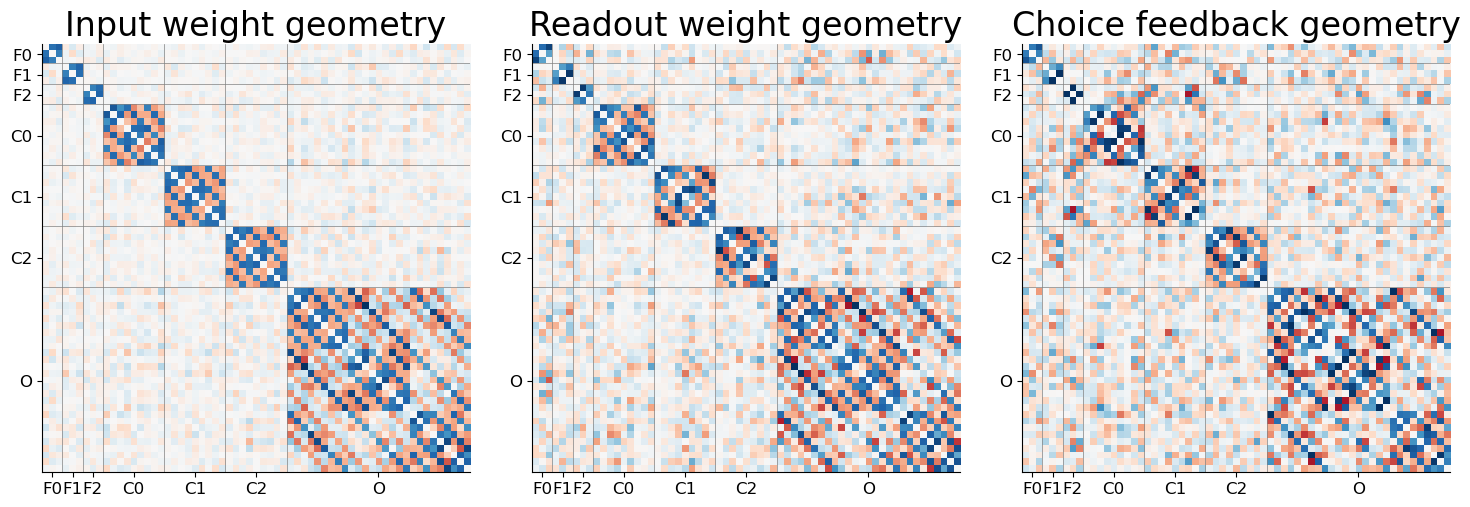

Figure saved at plots/fp_approx/weight_psth_geometry.pdf


In [77]:
all_model_dpca_psth_in = []
all_model_dpca_psth_out = []
all_model_dpca_psth_ch = []

for dpca_in, dpca_out, dpca_ch in zip(all_model_dpca_in, all_model_dpca_out, all_model_dpca_ch):
    all_dpca_psth_in = np.concatenate([dpca_in.marginalized_psth['s'].squeeze(), 
                                       dpca_in.marginalized_psth['p'].squeeze(), 
                                       dpca_in.marginalized_psth['c'].squeeze(), 
                                       dpca_in.marginalized_psth['pc'].squeeze().reshape((args['hidden_size'], 9)), 
                                       dpca_in.marginalized_psth['sc'].squeeze().reshape((args['hidden_size'], 9)), 
                                       dpca_in.marginalized_psth['sp'].squeeze().reshape((args['hidden_size'], 9)), 
                                       dpca_in.marginalized_psth['spc'].squeeze().reshape((args['hidden_size'], 27))], 
                                       axis=1)

    all_dpca_psth_out = np.concatenate([dpca_out.marginalized_psth['s'].squeeze(), 
                                       dpca_out.marginalized_psth['p'].squeeze(), 
                                       dpca_out.marginalized_psth['c'].squeeze(), 
                                       dpca_out.marginalized_psth['pc'].squeeze().reshape((args['hidden_size'], 9)), 
                                       dpca_out.marginalized_psth['sc'].squeeze().reshape((args['hidden_size'], 9)), 
                                       dpca_out.marginalized_psth['sp'].squeeze().reshape((args['hidden_size'], 9)), 
                                       dpca_out.marginalized_psth['spc'].squeeze().reshape((args['hidden_size'], 27))], 
                                       axis=1)

    all_dpca_psth_ch = np.concatenate([dpca_ch.marginalized_psth['s'].squeeze(), 
                                       dpca_ch.marginalized_psth['p'].squeeze(), 
                                       dpca_ch.marginalized_psth['c'].squeeze(), 
                                       dpca_ch.marginalized_psth['pc'].squeeze().reshape((args['hidden_size'], 9)), 
                                       dpca_ch.marginalized_psth['sc'].squeeze().reshape((args['hidden_size'], 9)), 
                                       dpca_ch.marginalized_psth['sp'].squeeze().reshape((args['hidden_size'], 9)), 
                                       dpca_ch.marginalized_psth['spc'].squeeze().reshape((args['hidden_size'], 27))], 
                                       axis=1)
    
    all_model_dpca_psth_in.append(all_dpca_psth_in.T)
    all_model_dpca_psth_out.append(all_dpca_psth_out.T)
    all_model_dpca_psth_ch.append(all_dpca_psth_ch.T)

all_model_dpca_psth_in = np.stack(all_model_dpca_psth_in)
all_model_dpca_psth_out = np.stack(all_model_dpca_psth_out)
all_model_dpca_psth_ch = np.stack(all_model_dpca_psth_ch)
    
fig, axes = plt.subplots(1,3)
fig.set_size_inches((15, 8))
cmap_scale = 2/3
axes[0].imshow(batch_cosine_similarity(all_model_dpca_psth_in, all_model_dpca_psth_in).mean(0)-np.eye(63),
           cmap='RdBu_r', vmin=-cmap_scale, vmax=cmap_scale)
axes[0].set_title("Input weight geometry")
axes[1].imshow(batch_cosine_similarity(all_model_dpca_psth_out, all_model_dpca_psth_out).mean(0)-np.eye(63),
           cmap='RdBu_r', vmin=-cmap_scale, vmax=cmap_scale)
axes[1].set_title("Readout weight geometry")
axes[2].imshow(batch_cosine_similarity(all_model_dpca_psth_ch, all_model_dpca_psth_ch).mean(0)-np.eye(63),
           cmap='RdBu_r', vmin=-cmap_scale, vmax=cmap_scale)
axes[2].set_title("Choice feedback geometry")

block_boundaries = [2.5, 5.5, 8.5, 17.5, 26.5, 35.5]
ticks = [1, 4, 7, 13, 22, 31, 49]
labels = ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O']
for i in range(3):
    for bb in block_boundaries:
        axes[i].axvline(x=bb,color='grey',lw=0.5)
        axes[i].axhline(y=bb-0.2,color='grey',lw=0.5)
    axes[i].set_xticks(ticks)
    axes[i].set_xticklabels(labels, fontsize=12)
    axes[i].set_yticks(ticks)
    axes[i].set_yticklabels(labels, fontsize=12)
    
sns.despine()
plt.tight_layout()
plt.show()

with PdfPages(f'plots/{plot_save_dir}/weight_psth_geometry.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{plot_save_dir}/weight_psth_geometry.pdf')


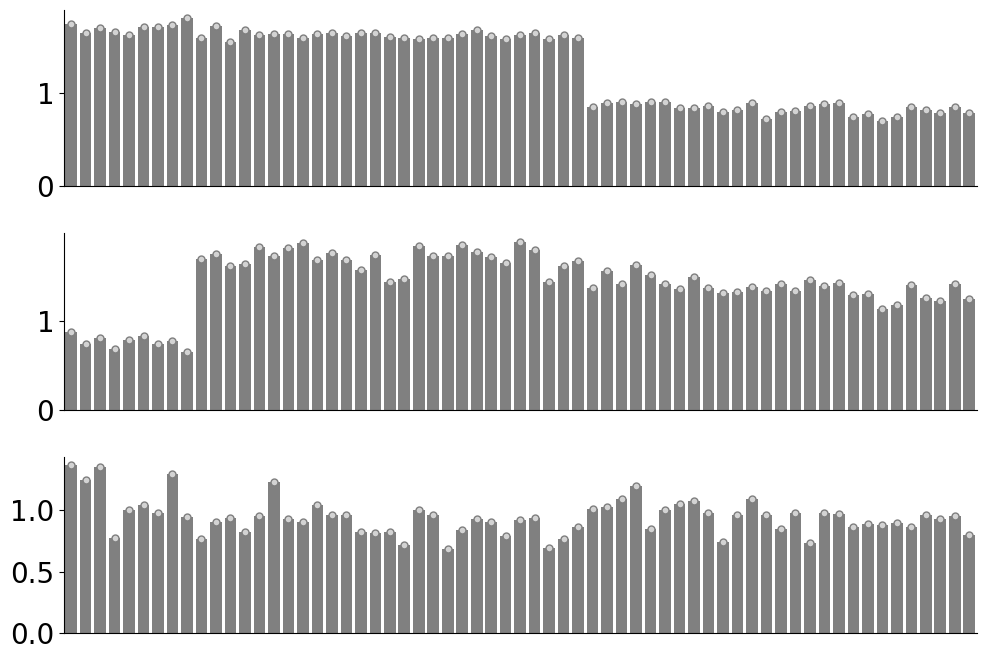

In [78]:
fig, axes = plt.subplots(3,1)

xxx_for_plot = np.tile(np.arange(63).reshape(1, 63), len(all_models)).flatten()

for idx, all_model_dpca_psth in \
    enumerate([all_model_dpca_psth_in, all_model_dpca_psth_out, all_model_dpca_psth_ch]):
    sns.stripplot(ax=axes[idx], x=xxx_for_plot, y=np.linalg.norm(all_model_dpca_psth, axis=2).flatten(), 
                  color='lightgrey', linewidth=1)
    sns.barplot(ax=axes[idx], x=xxx_for_plot, y=np.linalg.norm(all_model_dpca_psth, axis=2).flatten(), 
                  errorbar=None, color='grey')
    axes[idx].set_xticks([])

sns.despine()
plt.tight_layout()

Figure saved at plots/fp_approx/input_output_weight_variance.pdf


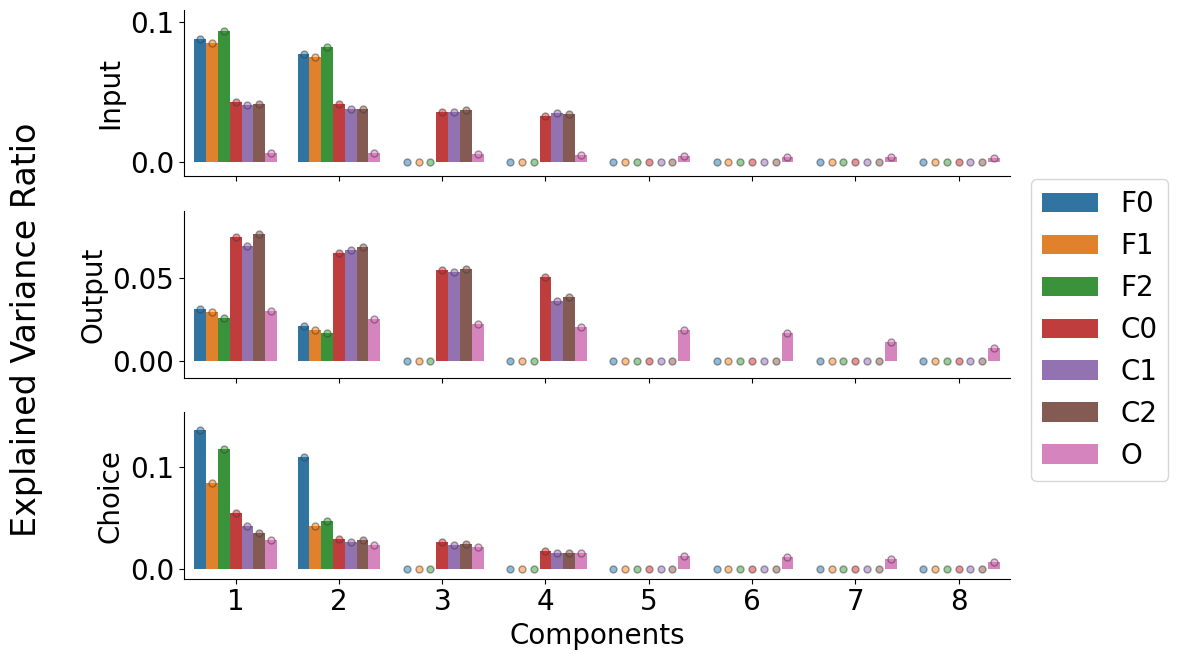

In [79]:
fig, axes = plt.subplots(3,1, figsize=(12,7))

def plot_weight_exp_vars(n_components_for_dpca, all_model_dpca, axes, ylabel):
    
    bar_width = 0.1

    key_plot_order = ['s', 'p', 'c', 'pc', 'sc', 'sp', 'spc']
    
    xxx_for_plot = np.tile(np.arange(8).reshape(1,1,8), [len(all_model_dpca),7,1])
    hue_for_plot = np.tile(np.arange(7).reshape(1,7,1), [len(all_model_dpca),1,8])

    all_model_dpca_exp_var = []
    
    for curr_model_dpca in all_model_dpca:
        all_dpca_exp_var = np.zeros((7, 8))
        for k_idx, k in enumerate(key_plot_order):
            all_dpca_exp_var[k_idx][...,:n_components_for_dpca[k]] = \
                np.array(curr_model_dpca.explained_variance_ratio_[k])
        all_model_dpca_exp_var.append(all_dpca_exp_var)
            
    all_model_dpca_exp_var = np.stack(all_model_dpca_exp_var)
    
    sns.stripplot(ax=axes, x=xxx_for_plot.flatten(), y=all_model_dpca_exp_var.flatten(),
                  hue=hue_for_plot.flatten(), palette='tab10', 
                  legend=False, linewidth=1, dodge=True, alpha=0.5)
    bb = sns.barplot(ax=axes, x=xxx_for_plot.flatten(), y=all_model_dpca_exp_var.flatten(),
                 hue=hue_for_plot.flatten(), palette='tab10', dodge=True, errorbar=None)
    bb.legend_.remove()
    
    axes.set_xticks(np.arange(0,8,1))
    axes.set_xticklabels([])
    axes.set_ylim(-0.01, axes.get_ylim()[1]+0.01)
    axes.set_ylabel(ylabel)
    
    

plot_weight_exp_vars(n_components_for_dpca, all_model_dpca_in, axes[0], "Input")
plot_weight_exp_vars(n_components_for_dpca, all_model_dpca_out, axes[1], "Output")
plot_weight_exp_vars(n_components_for_dpca, all_model_dpca_ch, axes[2], "Choice")

labels = ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O']

axes[2].set_xlabel('Components')
axes[2].set_xticklabels(np.arange(1,9,1))
fig.supylabel('Explained Variance Ratio')
plt.tight_layout()
handles, _ = axes[0].get_legend_handles_labels()

for ax in axes:
    box = ax.get_position()
    # axes[0].text(5, 8, rf'$R^2$ = {100*np.round(np.sum([np.sum(v) for v in dpca_in.explained_variance_ratio_.values()]))}%')
    ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])

fig.legend(handles, labels, loc='center right')
sns.despine()
fig.show()

with PdfPages(f'plots/{plot_save_dir}/input_output_weight_variance.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{plot_save_dir}/input_output_weight_variance.pdf')


0 out of 276 comparisons were significant
0 out of 276 comparisons were significant
2 out of 276 comparisons were significant
Figure saved at plots/fp_approx/fixed_weight_axis_overlap.pdf


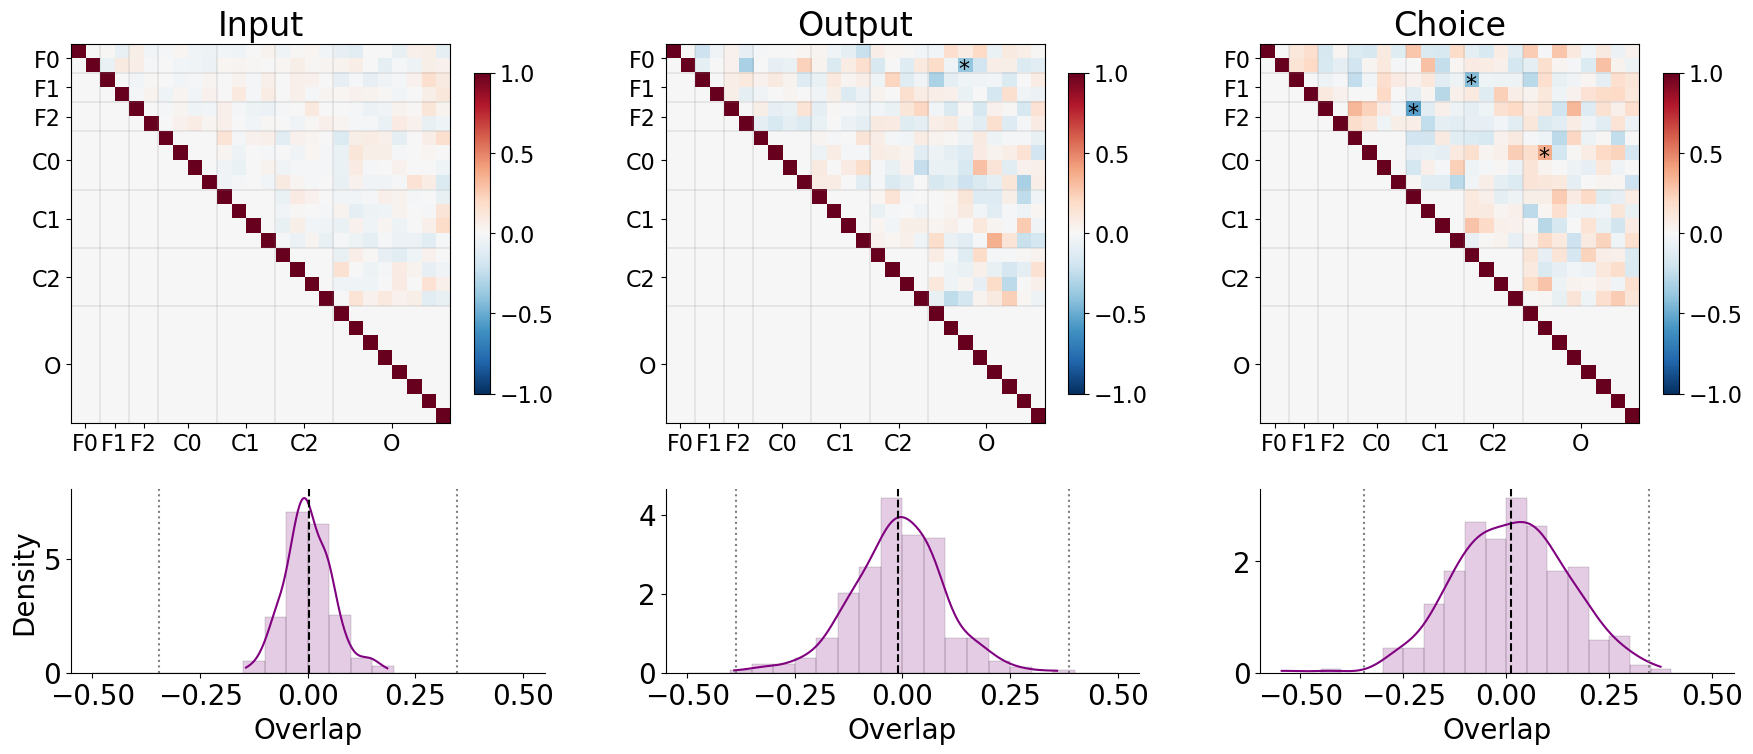

In [80]:
from statsmodels.stats.multitest import fdrcorrection

def test_dpca_overlap(all_dpca_results, keys, all_low_hs, overlap_scale, label, axes):
    
    all_model_axes_overlap = []
    all_model_flat_overlap = []
    all_model_low_hs_corr_val = []
    all_model_pvals = []
    all_model_axes = []
    for dpca_result, low_hs in zip(all_dpca_results, all_low_hs):
        all_dpca_axes = np.concatenate([dpca_result.P[k] for k in keys], axis=1) # concat all axes
        all_dpca_low_hs = np.concatenate([low_hs[k].reshape((low_hs[k].shape[0],-1)) 
                                          for k in keys], axis=0) # concat all axes
        low_hs_corr_val = np.corrcoef(all_dpca_low_hs)
        axes_overlap = all_dpca_axes.T@all_dpca_axes # dot product similarity
        axes_corr_val, axes_corr_ps = spearmanr(all_dpca_axes, axis=0) # rank correlation similarity
        all_overlaps = []
        all_pvals = []
        sig_thresh = np.abs(norm.ppf(0.001))*overlap_scale
        for k_idx1 in range(len(keys)):
            for k_idx2 in range(k_idx1+1, len(keys)):
                pair_overlaps = (dpca_result.P[keys[k_idx1]].T@dpca_result.P[keys[k_idx2]]).flatten()
                all_overlaps.append(pair_overlaps)
                all_pvals.append(norm.cdf(-np.abs(pair_overlaps), loc=0, scale=overlap_scale)+ \
                    norm.sf(np.abs(pair_overlaps), loc=0, scale=overlap_scale))
        all_overlaps = np.concatenate(all_overlaps)
        all_pvals = np.concatenate(all_pvals)
        _, all_corrected_pvals = fdrcorrection(all_pvals)
        
        all_model_axes.append(all_dpca_axes)
        all_model_axes_overlap.append(axes_overlap)
        all_model_pvals.append(all_corrected_pvals)
        all_model_flat_overlap.append(all_overlaps)
        all_model_low_hs_corr_val.append(low_hs_corr_val)
        
    all_model_axes = np.stack(all_model_axes)
    all_model_axes_overlap = np.stack(all_model_axes_overlap)
    all_model_pvals = np.stack(all_model_pvals)
    all_model_flat_overlap = np.stack(all_model_flat_overlap)
    all_model_low_hs_corr_val = np.stack(all_model_low_hs_corr_val)
        
    tril_mask = np.zeros_like(all_model_axes_overlap.mean(0))
    tril_mask[np.tril_indices(axes_overlap.shape[0], k=-1)] = 1

    triu_mask = np.zeros_like(all_model_axes_overlap.mean(0))
    triu_mask[np.triu_indices(axes_overlap.shape[0], k=0)] = 1
    
    # plot overlap values
    im = axes[0].imshow(all_model_axes_overlap.mean(0)*triu_mask+\
                   all_model_low_hs_corr_val.mean(0)*tril_mask, \
                   cmap='RdBu_r', vmin=-1, vmax=1)
    cb=plt.colorbar(im, shrink=0.7)
    cb.ax.tick_params(labelsize=16)
    
    txs, tys = np.meshgrid(np.arange(axes_overlap.shape[0]),np.arange(axes_overlap.shape[0]))
    txs = txs[(np.abs(all_model_axes_overlap.mean(0))>sig_thresh)]
    tys = tys[(np.abs(all_model_axes_overlap.mean(0))>sig_thresh)]
    
    block_boundaries = np.cumsum(list(n_components_for_dpca.values()))[:-1]-0.5
    for i in block_boundaries:
        axes[0].axvline(x=i,color='grey',linewidth=0.2)
        axes[0].axhline(y=i,color='grey',linewidth=0.2)
        
    tick_locs = np.cumsum([0, *n_components_for_dpca.values()])[:-1]+np.array(list(n_components_for_dpca.values()))//2-0.5

    axes[0].set_xticks(tick_locs, ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O'], size=16)
    axes[0].set_yticks(tick_locs, ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O'], size=16)
    
    for (x,y) in zip(txs, tys):
        if x<=y:
            continue
        else:
            axes[0].text(x-0.4, y+0.7, '*', {'size': 16})
    
    sns.histplot(x=all_model_flat_overlap.flatten(), color='purple',ax=axes[1], stat='density', 
                 kde=True, bins=np.linspace(-0.5,0.5,21), linewidth=0.1, alpha=0.2)
    axes[1].set_xlabel('Overlap')
    axes[1].axvline(sig_thresh, color='grey', linestyle=':')
    axes[1].axvline(all_overlaps.mean(), color='black', linestyle='--')
    axes[1].axvline(-sig_thresh, color='grey', linestyle=':')
    
    
    axes[0].set_title(label, fontsize=24)
    
    axes[1].spines[['right', 'top']].set_visible(False)
    
    print(f"{(all_model_pvals.flatten()<0.05).sum()} out of {np.prod(all_model_pvals.shape)} comparisons were significant")
    
    return all_model_axes
    
    
fig, axes = plt.subplots(2, 3, height_ratios=(2.5, 1), figsize=(18, 8))
    
all_model_dpca_axes_in = test_dpca_overlap(all_model_dpca_in, ['s','p','c','pc','sc','sp','spc'], 
                              all_model_low_input, 1/np.sqrt(args['hidden_size']), 
                              "Input", axes[:,0])
all_model_dpca_axes_out = test_dpca_overlap(all_model_dpca_out, ['s','p','c','pc','sc','sp','spc'], 
                              all_model_low_output, 1/np.sqrt(int(args['hidden_size']*args['e_prop'])), 
                              "Output", axes[:,1])
all_model_dpca_axes_ch = test_dpca_overlap(all_model_dpca_ch, ['s','p','c','pc','sc','sp','spc'], 
                              all_model_low_ch, 1/np.sqrt(args['hidden_size']), 
                              "Choice", axes[:,2])
axes[1,1].set_ylabel(" ")
axes[1,2].set_ylabel(" ")


plt.tight_layout()

with PdfPages(f'plots/{plot_save_dir}/fixed_weight_axis_overlap.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{plot_save_dir}/fixed_weight_axis_overlap.pdf')

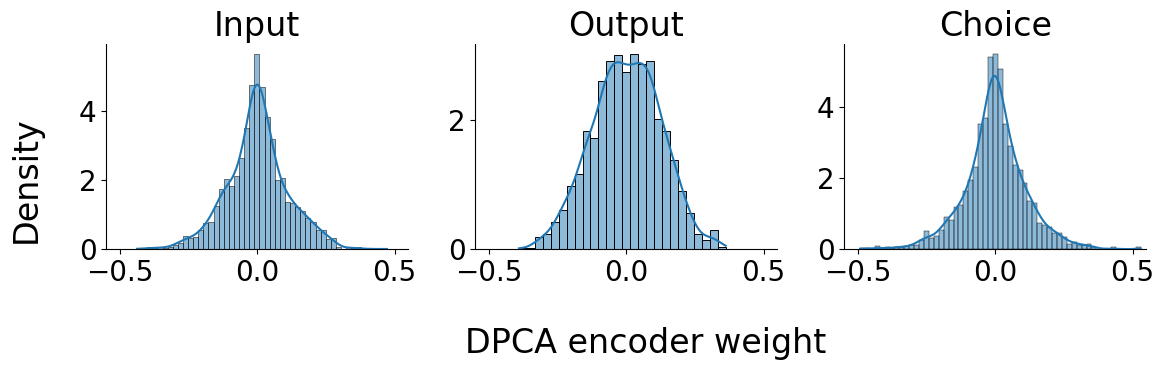

In [81]:
fig, axes = plt.subplots(1,3,figsize=(12, 4))

sns.histplot(x=all_model_dpca_axes_in.flatten(), stat='density', kde=True, ax=axes[0])
axes[0].set_title('Input')
sns.histplot(x=all_model_dpca_axes_out[:,:E_SIZE,:].flatten(), stat='density', kde=True, ax=axes[1])
axes[1].set_title('Output')
sns.histplot(x=all_model_dpca_axes_ch.flatten(), stat='density', kde=True, ax=axes[2])
axes[2].set_title('Choice')

fig.supxlabel('DPCA encoder weight', y=0.05, x=0.55)
fig.supylabel('Density')

for i in range(3):
    axes[i].set_ylabel("")
    axes[i].set_xlim([-0.55, 0.55])
#     axes[i].set_ylim([0, 7])
sns.despine()
plt.tight_layout()

# Analysis of Naive Weights of RNN

MannwhitneyuResult(statistic=16877.0, pvalue=6.1465424908678585e-18)
MannwhitneyuResult(statistic=16276.0, pvalue=1.1077540939029634e-15)
MannwhitneyuResult(statistic=15705.0, pvalue=1.089971857879079e-13)
Figure saved at plots/fp_approx/recurrent_transform_overlap.pdf


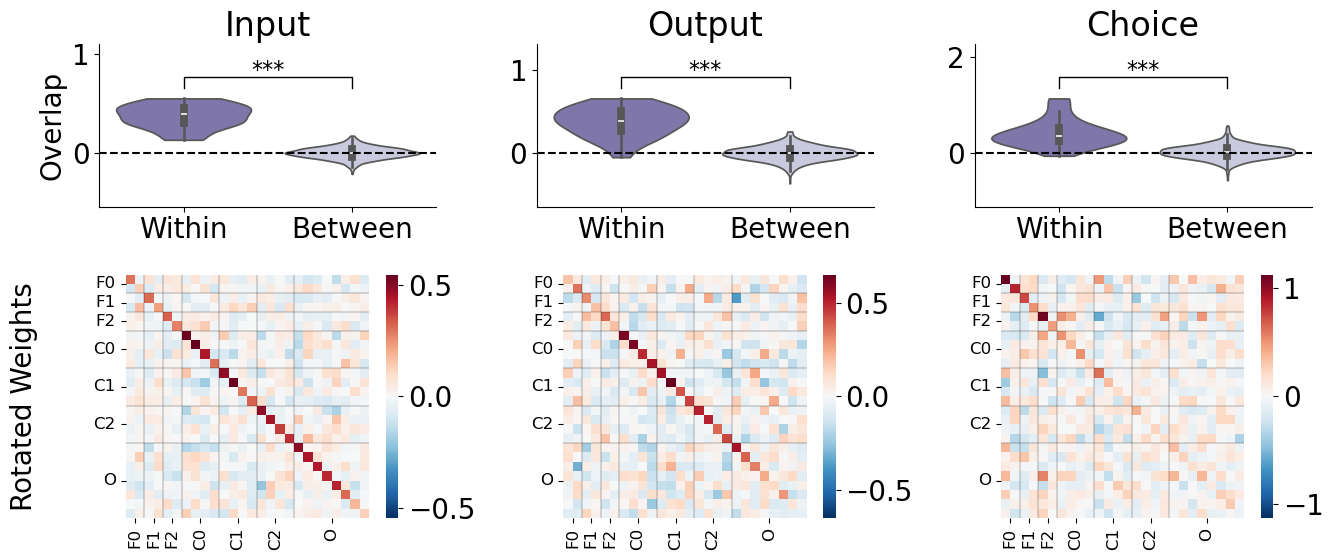

In [82]:
def plot_recurrence(all_model_dpca_axes, all_model_rec_intra, axes, title):
    all_model_rec_overlap = []
    all_model_overlap_within = []
    all_model_overlap_between = []
    for (all_dpca_axes, rec_intra) in zip(all_model_dpca_axes, all_model_rec_intra):
        num_components = all_dpca_axes.shape[1]
        rec_overlap = all_dpca_axes.T@rec_intra.detach().numpy()@all_dpca_axes
        all_model_rec_overlap.append(rec_overlap)
        all_model_overlap_within.append(np.diag(rec_overlap))
        all_model_overlap_between.append(rec_overlap[np.where(~np.eye(num_components,dtype=bool))])
        
    all_model_rec_overlap = np.stack(all_model_rec_overlap)
    all_model_overlap_within = np.stack(all_model_overlap_within)
    all_model_overlap_between = np.stack(all_model_overlap_between)
        
#     im=axes[1].imshow(all_model_rec_overlap.mean(0), vmin=-cmap_scale, vmax=cmap_scale, cmap='RdBu_r')
    cmap_scale = all_model_rec_overlap.mean(0).max()*1
    
    sns.heatmap(all_model_rec_overlap.mean(0), ax=axes[1], vmin=-cmap_scale, vmax=cmap_scale, cmap='RdBu_r', 
                     square=True, annot_kws={'fontdict':{'fontsize':10}}, cbar_kws={"shrink": 1})
    cb=plt.colorbar(im, shrink=0.8)
    cb.ax.tick_params(labelsize=12)
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    sns.violinplot(ax=axes[0], 
        x=['Within']*np.prod(all_model_overlap_within.shape).astype(int)\
                   +['Between']*np.prod(all_model_overlap_between.shape).astype(int),
        hue=['Within']*np.prod(all_model_overlap_within.shape).astype(int)\
                   +['Between']*np.prod(all_model_overlap_between.shape).astype(int),         
        y=np.concatenate([all_model_overlap_within.flatten(), all_model_overlap_between.flatten()]),
        palette=sns.color_palette('Purples_r', 2), cut=0, legend=False)
    
    temp_stats = stats.mannwhitneyu(all_model_overlap_within.flatten(), all_model_overlap_between.flatten())
    
    
#     axes[0].text(0.5, 1.1, f"p={np.format_float_scientific(temp_stats.pvalue, precision=2)}", fontsize=16)
    axes[0].axhline(0, linestyle='--', color='k')
    axes[0].set_xlim([-0.5, 1.5])
    axes[0].set_ylim([-cmap_scale, cmap_scale*(2.0)])
#     axes[0].set_yticks(np.arange(-1, 3))
    axes[0].set_ylabel("")
    axes[0].set_title(title)
    print(temp_stats)
    
    axes[0].plot([0, 0, 1, 1], [cmap_scale*1.2, cmap_scale*1.4, cmap_scale*1.4, cmap_scale*1.2], lw=1, c='k')
    axes[0].text(0.5, cmap_scale*1.3, convert_pvalue_to_asterisks(temp_stats.pvalue), 
                 ha='center', va='bottom', c='k', fontsize=16)
    
    sns.despine(ax=axes[0])
    

fig, axes = plt.subplots(2,3, figsize=(14, 6), height_ratios=[1, 1.5])


plot_recurrence(all_model_dpca_axes_in, [rec_intra[0] for rec_intra in all_model_rec_intra], 
                axes[:,0], "Input")
plot_recurrence(all_model_dpca_axes_out, [rec_intra[1] for rec_intra in all_model_rec_intra], 
                axes[:,1], "Output")
plot_recurrence(all_model_dpca_axes_ch, [rec_intra[1] for rec_intra in all_model_rec_intra], 
                axes[:,2], "Choice")


axes[0,0].set_ylabel('Overlap')
axes[1,0].set_ylabel('Rotated Weights', labelpad=40)

for j in range(3):
    block_boundaries = np.cumsum(list(n_components_for_dpca.values()))[:-1]
    for i in block_boundaries:
        axes[1,j].axvline(x=i,color='k',linewidth=0.2)
        axes[1,j].axhline(y=i,color='k',linewidth=0.2)
    tick_locs = np.cumsum([0, *n_components_for_dpca.values()])[:-1]+np.array(list(n_components_for_dpca.values()))//2
    axes[1,j].set_xticks(tick_locs, ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O'], size=12)
    axes[1,j].set_yticks(tick_locs, ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O'], size=12)

fig.tight_layout()

with PdfPages(f'plots/{plot_save_dir}/recurrent_transform_overlap.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{plot_save_dir}/recurrent_transform_overlap.pdf')


MannwhitneyuResult(statistic=294.0, pvalue=2.3282728787967262e-08)
MannwhitneyuResult(statistic=294.0, pvalue=2.3282728787967262e-08)
MannwhitneyuResult(statistic=294.0, pvalue=2.3282728787967262e-08)
Figure saved at plots/fp_approx/interareal_transform_overlap.pdf


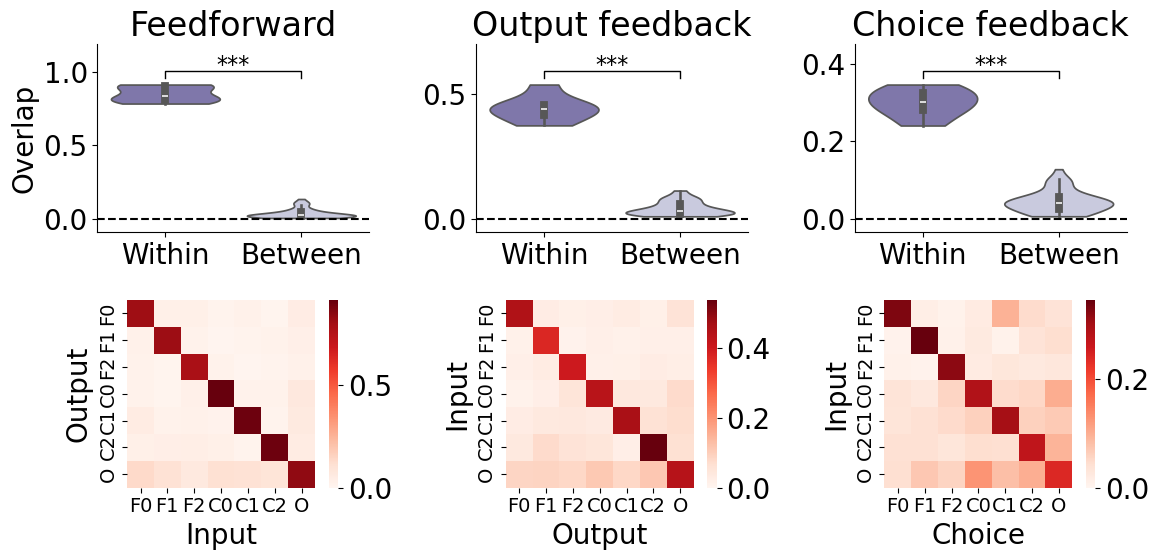

In [83]:
fig, axes = plt.subplots(2, 3, figsize=(12,6), height_ratios=(1,1))

def plot_ff_fb(all_model_dpca_pre, all_model_dpca_post, all_model_rec_inter, 
               axes, title, pre_label, post_label):

    all_model_explained_vars = []
    all_model_vars_within = []
    all_model_vars_between = []
    
    for (dpca_pre, dpca_post, rec_inter) in zip(all_model_dpca_pre, all_model_dpca_post, all_model_rec_inter):
        
        explained_vars = np.zeros((7,7))

        for k_in_idx, k_in in enumerate(['s', 'p', 'c', 'pc', 'sc', 'sp', 'spc']):
            currents = rec_inter.detach().numpy()@dpca_pre.P[k_in]
            for k_out_idx, k_out in enumerate(['s', 'p', 'c', 'pc', 'sc', 'sp', 'spc']):
                explained_vars[k_out_idx][k_in_idx] = \
                    np.sum((dpca_post.P[k_out].T@currents)**2)/np.sum(currents**2)
#                 explained_vars[k_out_idx][k_in_idx] = np.sum((dpca_post.P[k_out].T@currents)**2)

        all_model_explained_vars.append(explained_vars)
        all_model_vars_within.append(np.diag(explained_vars))
        all_model_vars_between.append(explained_vars[np.where(~np.eye(7, dtype=bool))])
        
    all_model_explained_vars = np.stack(all_model_explained_vars)
    all_model_vars_within = np.stack(all_model_vars_within)
    all_model_vars_between = np.stack(all_model_vars_between)
    
    cmap_scale = all_model_explained_vars.mean(0).max()*1
    
    cm = sns.heatmap(all_model_explained_vars.mean(0), ax=axes[1], vmin=0, vmax=None, cmap='Reds', 
                     square=True, annot_kws={'fontdict':{'fontsize':10}}, cbar_kws={"shrink": 1})
    # fig.colorbar(cm,fraction=0.046, pad=0.04)
    axes[1].set_ylabel(post_label)
    axes[1].set_xlabel(pre_label)
    
    
    sns.violinplot(ax=axes[0], 
        x=['Within']*np.prod(all_model_vars_within.shape).astype(int)\
                   +['Between']*np.prod(all_model_vars_between.shape).astype(int),
        y=np.concatenate([all_model_vars_within.flatten(), all_model_vars_between.flatten()]),
        hue=['Within']*np.prod(all_model_vars_within.shape).astype(int)\
                   +['Between']*np.prod(all_model_vars_between.shape).astype(int),
        palette=sns.color_palette('Purples_r', 2), cut=0, legend=False)
    
    temp_stats = stats.mannwhitneyu(all_model_vars_within.flatten(), all_model_vars_between.flatten())
    
    
#     axes[0].text(0.5, 1.1, f"p={np.format_float_scientific(temp_stats.pvalue, precision=2)}", fontsize=16)
    axes[0].axhline(0, linestyle='--', color='k')
    axes[0].set_xlim([-0.5, 1.5])
    axes[0].set_ylim([-.1*cmap_scale, cmap_scale*1.3])
#     axes[0].set_yticks(np.arange(0, 2))
    axes[0].set_ylabel("")
    axes[0].set_title(title)
    print(temp_stats)
    
    unit_len = cmap_scale/10

    bar_bottom = cmap_scale+unit_len*0.5
    bar_top = cmap_scale+unit_len*1.

    axes[0].plot([0, 0, 1, 1], 
                 [bar_bottom, bar_top, bar_top, bar_bottom], lw=1, c='k')
    axes[0].text(0.5, bar_bottom+unit_len/20, 
                 convert_pvalue_to_asterisks(temp_stats.pvalue), 
                 ha='center', va='bottom', c='k', fontsize=16)
    sns.despine(ax=axes[0])

    
plot_ff_fb(all_model_dpca_in, all_model_dpca_out, [rec_inter_ff[0] for rec_inter_ff in all_model_rec_inter_ff],
           axes[:,0], 'Feedforward', 'Input', 'Output')
plot_ff_fb(all_model_dpca_out, all_model_dpca_in, [rec_inter_fb[0] for rec_inter_fb in all_model_rec_inter_fb],
           axes[:,1], 'Output feedback', 'Output', 'Input')
plot_ff_fb(all_model_dpca_ch, all_model_dpca_in, [rec_inter_fb[0] for rec_inter_fb in all_model_rec_inter_fb],
           axes[:,2], 'Choice feedback', 'Choice', 'Input')

for i in range(3):
    axes[1,i].set_xticks(np.arange(0,7)+0.5)
    axes[1,i].set_xticklabels(["F0", "F1", "F2", "C0", "C1", "C2", "O"], fontsize=14)
    axes[1,i].set_yticks(np.arange(0,7)+0.5)
    axes[1,i].set_yticklabels(["F0", "F1", "F2", "C0", "C1", "C2", "O"], fontsize=14)

axes[0,0].set_ylabel('Overlap')
# axes[1,0].set_ylabel('Rotated Weights', labelpad=40)
fig.tight_layout()

with PdfPages(f'plots/{plot_save_dir}/interareal_transform_overlap.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{plot_save_dir}/interareal_transform_overlap.pdf')


# Analysis of learning rate matrix of the recurrent weights

Figure saved at plots/fp_approx/hebbian_learning_overlap.pdf


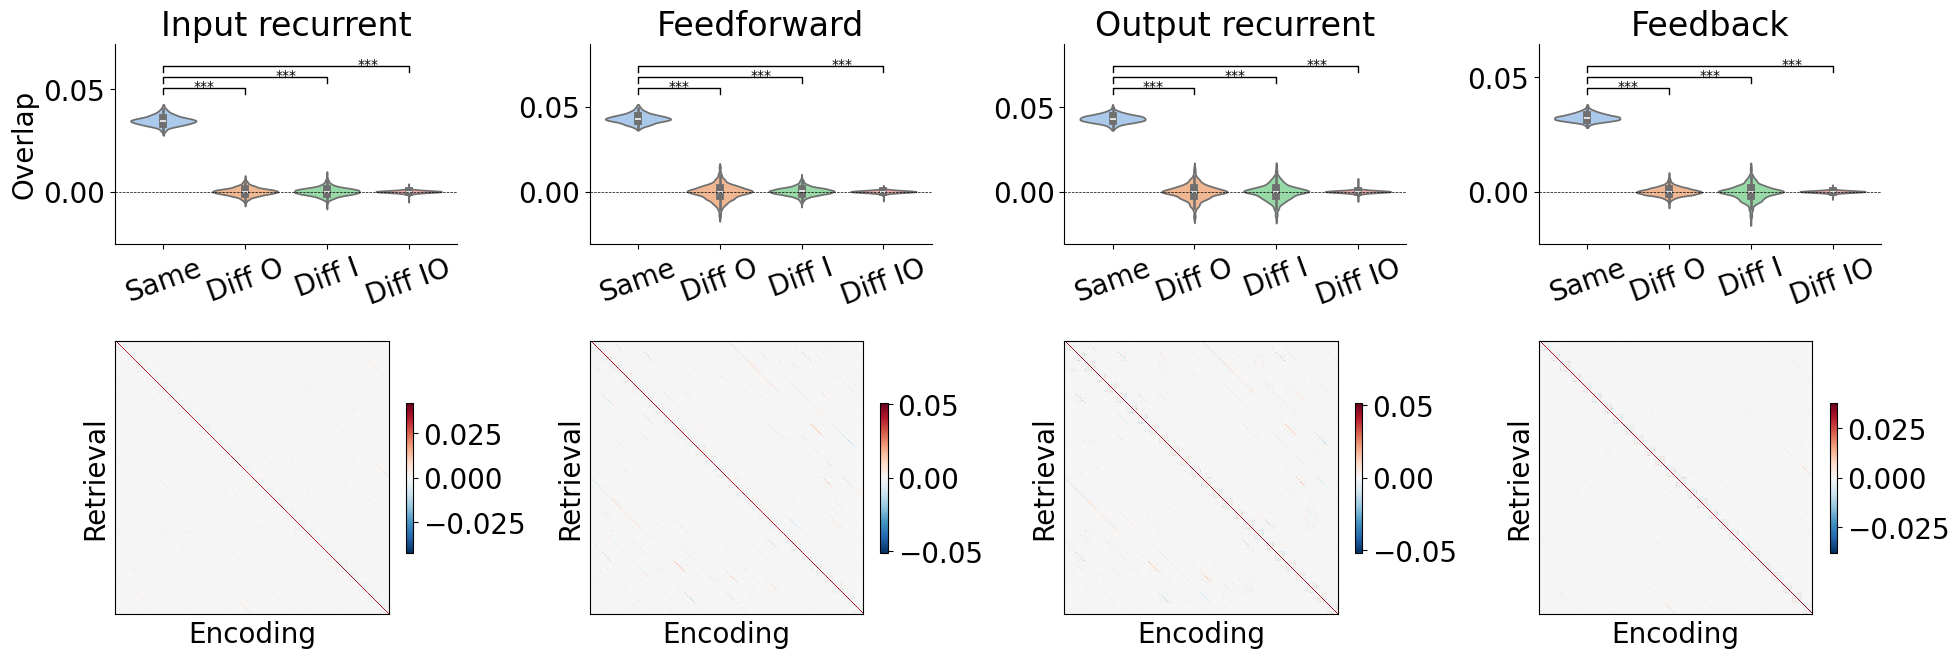

In [84]:
fig, axes = plt.subplots(2,4, figsize=(20, 7), height_ratios=(1, 1.5)) #, dpi=200


def plot_hebb_overlap(all_model_dpca_axes_pre_enc, all_model_dpca_axes_post_enc, 
                      all_model_dpca_axes_pre_rtv, all_model_dpca_axes_post_rtv, 
                      all_model_kappa_rec, 
                      axes, title):

    # recurrent plasticity in input area
    all_model_overlaps = {'same_pre_post': [], 'same_pre': [], 'same_post': [], 'diff': []}
    all_model_overlaps_mat = []
        
    
    for all_dpca_axes_pre_enc, all_dpca_axes_post_enc, \
        all_dpca_axes_pre_rtv, all_dpca_axes_post_rtv, kappa_rec in \
            zip(all_model_dpca_axes_pre_enc, all_model_dpca_axes_post_enc, \
                all_model_dpca_axes_pre_rtv, all_model_dpca_axes_post_rtv, all_model_kappa_rec):
        
        overlaps = {'same_pre_post': [], 'same_pre': [], 'same_post': [], 'diff': []}
        num_axis = all_dpca_axes_pre_enc.shape[1]
        overlap_mat = np.zeros((num_axis**2, num_axis**2))
        
        for i in range(num_axis):
            for j in range(num_axis):
                # calculate hebbian memory
                mem_mat = kappa_rec.numpy()*(all_dpca_axes_post_enc[:,i:i+1]@all_dpca_axes_pre_enc[:,j:j+1].T)
                for k in range(num_axis):
                    for l in range(num_axis):
                        curr_overlap = all_dpca_axes_post_rtv[:,k:k+1].T@mem_mat@all_dpca_axes_pre_rtv[:,l:l+1]
                        if i==k and j==l:
                            overlaps['same_pre_post'].append(curr_overlap)
                        elif j==l:
                            overlaps['same_pre'].append(curr_overlap)
                        elif i==k:
                            overlaps['same_post'].append(curr_overlap)
                        else:
                            overlaps['diff'].append(curr_overlap)
                            
                        overlap_mat[k*num_axis+l, i*num_axis+j] = curr_overlap
                                            
        for k, v in overlaps.items():
            all_model_overlaps[k].append(v)
        all_model_overlaps_mat.append(overlap_mat)
    
    for k, v in overlaps.items():
        all_model_overlaps[k] = np.stack(all_model_overlaps[k])
    all_model_overlaps_mat = np.stack(all_model_overlaps_mat)
    
    cmap_scale = all_model_overlaps_mat.mean(0).max()
        
    im=axes[1].imshow(all_model_overlaps_mat.mean(0), 
                      vmin=-cmap_scale, vmax=cmap_scale, 
                      cmap='RdBu_r', interpolation='nearest')
    plt.colorbar(im, shrink=0.5)
#     axes[1].axis('off')
    axes[1].set_yticks([])
    axes[1].set_xticks([])
    axes[1].set_ylabel('Retrieval')
    axes[1].set_xlabel('Encoding')
        
    sns.violinplot(ax=axes[0],
                  x=['Same']*np.prod(all_model_overlaps['same_pre_post'].shape)+\
                   ['Diff O']*np.prod(all_model_overlaps['same_pre'].shape)+
                   ['Diff I']*np.prod(all_model_overlaps['same_post'].shape)+\
                   ['Diff IO']*np.prod(all_model_overlaps['diff'].shape),
                  y=np.concatenate([all_model_overlaps['same_pre_post'].flatten(),
                                   all_model_overlaps['same_pre'].flatten(),
                                   all_model_overlaps['same_post'].flatten(),
                                   all_model_overlaps['diff'].flatten()]),
                   hue=['Same']*np.prod(all_model_overlaps['same_pre_post'].shape)+\
                   ['Diff O']*np.prod(all_model_overlaps['same_pre'].shape)+
                   ['Diff I']*np.prod(all_model_overlaps['same_post'].shape)+\
                   ['Diff IO']*np.prod(all_model_overlaps['diff'].shape),
                  palette=sns.color_palette('pastel', 4), cut=0, legend=False)
    
    axes[0].set_xticks(np.arange(4))
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=20)
    axes[0].axhline(0, linestyle = '--', color='k', linewidth=0.5)
    axes[0].set_title(title)
    axes[0].set_ylim([-cmap_scale*0.6, cmap_scale*1.7])
    sns.despine(ax=axes[0])
    
    for key_idx, key in enumerate(['same_pre', 'same_post', 'diff']):
        temp_stats = stats.mannwhitneyu(all_model_overlaps['same_pre_post'].flatten(), 
                                        all_model_overlaps[key].flatten())
        
        unit_len = cmap_scale/8
        
        bar_bottom = cmap_scale+unit_len*(key_idx+1)
        bar_top = cmap_scale+unit_len*(key_idx+1.5)
        
        axes[0].plot([0, 0, key_idx+1, key_idx+1], 
                     [bar_bottom, bar_top, bar_top, bar_bottom], lw=1, c='k')
        axes[0].text(0.5+key_idx, bar_top*1.02, 
                     convert_pvalue_to_asterisks(temp_stats.pvalue), 
                     ha='center', va='center', c='k', fontsize=10)
    
    

plot_hebb_overlap(all_model_dpca_axes_in, all_model_dpca_axes_in, 
                  all_model_dpca_axes_in, all_model_dpca_axes_in, 
                  [kappa_rec_intra[0] for kappa_rec_intra in all_model_kappa_rec_intra],
                 axes[:,0], 'Input recurrent')

plot_hebb_overlap(all_model_dpca_axes_in, all_model_dpca_axes_out, 
                  all_model_dpca_axes_in, all_model_dpca_axes_out, 
                  [kappa_inter_ff[0] for kappa_inter_ff in all_model_kappa_inter_ff],
                 axes[:,1], 'Feedforward')

plot_hebb_overlap(all_model_dpca_axes_out, all_model_dpca_axes_out, 
                  all_model_dpca_axes_out, all_model_dpca_axes_out, 
                  [kappa_rec_intra[1] for kappa_rec_intra in all_model_kappa_rec_intra],
                 axes[:,2],'Output recurrent')

plot_hebb_overlap(all_model_dpca_axes_out, all_model_dpca_axes_in, 
                  all_model_dpca_axes_out, all_model_dpca_axes_in, 
                  [kappa_inter_fb[0] for kappa_inter_fb in all_model_kappa_inter_fb],
                 axes[:,3],'Feedback')


axes[0,0].set_ylabel('Overlap')
# axes[1,0].set_ylabel('Retrieval')
# fig.supxlabel('Encoding')

fig.tight_layout()

with PdfPages(f'plots/{plot_save_dir}/hebbian_learning_overlap.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{plot_save_dir}/hebbian_learning_overlap.pdf')


## dPCA Analysis of the Activity of the RNN

In [5]:
def get_area_ei_indices(args, ind_area):
    hidden_size_per_area = args['hidden_size']
    E_SIZE = round(args['hidden_size']*args['e_prop'])
    I_SIZE = round(args['hidden_size']*(1-args['e_prop']))
    NUM_AREAS = args['num_areas']
    return np.concatenate([np.arange(E_SIZE*ind_area, E_SIZE*(ind_area+1)), 
                           np.arange(E_SIZE*NUM_AREAS+I_SIZE*ind_area, E_SIZE*NUM_AREAS+I_SIZE*(ind_area+1))])

def make_dpca_results(Xs, labels, n_components):
    all_non_time_labels = labels
    join_dict = {}
    for r in range(1, len(labels)+1):
        for label in list(itertools.combinations(all_non_time_labels, r)):
            label_str = ''.join(label)
            join_dict['t'+label_str] = [label_str, 't'+label_str]
#             print(join_dict)

    dpca_model = dPCA.dPCA('t'+labels, join=join_dict, n_components=n_components)
    low_hs = dpca_model.fit_transform(Xs)

    all_axes = []
    all_explained_vars = []
    all_labels = []
    for k in dpca_model.marginalized_psth.keys():
        eff_components = np.sum(np.array(dpca_model.explained_variance_ratio_[k])>0.00)
        all_explained_vars.append(dpca_model.explained_variance_ratio_[k][:eff_components])
#         print(f"Variance explained by {eff_components} of {k}: {np.round(100*np.array(dpca_model.explained_variance_ratio_[k]),4)} %")
        all_axes.append(dpca_model.P[k][:,:eff_components])
        all_labels += [k]*eff_components

    all_axes = np.concatenate(all_axes, axis=1)
    all_explained_vars = np.concatenate(all_explained_vars, axis=0)

    dpca_results = {}
    dpca_results['low_hs'] = low_hs
    dpca_results['encoding_axes'] = dpca_model.P
    dpca_results['explained_variances'] = dpca_model.explained_variance_ratio_
    dpca_results['marginalized_psth'] = dpca_model.marginalized_psth

    return dpca_results

def get_dpca_by_area(all_saved_states, task_mdprl, args, 
                     trials_to_fit, area_to_fit, model_to_fit):
    '''
    (1) regress hs activity with
            previous trial choice shape, color, pattern (3x3x3), 
            previous trial reward (2),
            current trial stimuli shape, color, pattern pairs (3x3x3), 
            current trial choice shape, color, pattern (3x3x3), 
            current trial reward (2),
    (2) get beta weights which is a mixture of value and stimulus intensity: h ~ Xw. 
        This will give beta weights timepoints X trials X hidden X latent variables,
        calculate cpd gives timepoints X trials X hidden X latent variables CPD values
    (3) compare w with marginal reward probability? see which it dimension it corresponds to the best
    '''
    
    n_trials, n_timesteps, n_sessions, n_hidden = all_saved_states['hs'].shape
    n_areas = args['num_areas'] 
    n_hidden = n_hidden//n_areas

    area_inds = get_area_ei_indices(args, area_to_fit)
    sessions_to_fit = all_saved_states['model_assignment'].astype(int)==model_to_fit
    num_sessions_to_fit = np.sum(sessions_to_fit)

    area_hs = all_saved_states['hs'][...,area_inds]
    num_trials_to_fit = len(trials_to_fit)

    print("Calculating PSTH by prev trial")

    '''
    organize by previous trial outcome
    '''
    hs_by_prev = np.zeros((n_hidden, n_timesteps, 2, 3, 3, 3)) # sort data by previous trial choices and outcomes
    
    flat_hs_post = area_hs.numpy()[trials_to_fit[1:],...][:,:,sessions_to_fit]\
                        .transpose((2,0,1,3)).reshape((num_sessions_to_fit*(num_trials_to_fit-1), n_timesteps, n_hidden))
    flat_rwds_pre = all_saved_states['rewards'].numpy()[trials_to_fit[:-1],...][:,:,sessions_to_fit]\
                        .transpose((2,0,1)).reshape((num_sessions_to_fit*(num_trials_to_fit-1))).astype(int)
    flat_acts_pre = all_saved_states['choices'].numpy()[trials_to_fit[:-1],...][:,:,sessions_to_fit]\
                        .transpose((2,0,1)).reshape((num_sessions_to_fit*(num_trials_to_fit-1))).astype(int)

    # the prev_f{}_vals are IN TERMS OF THE REWARD SCHEDULE, NOT THE PERCEPTUAL DIMENSIONS

    act_f1_val = task_mdprl.index_shp[flat_acts_pre]
    act_f2_val = task_mdprl.index_pttrn[flat_acts_pre]
    act_f3_val = task_mdprl.index_clr[flat_acts_pre]

    n_components_for_dpca_by_prev = {'t':3, 'tr':1, 'ts':2, 'tp':2, 'tc':2, 
                                             'tsp':4, 'tsc':4, 'tpc':4, 'tspc': 8,
                                             'trs':2, 'trp':2, 'trc':2, 
                                             'trsp':4, 'trsc':4, 'trpc':4, 'trspc': 8}
    
    for prev_rwd_val in range(2):
        for prev_f1_val in range(3): 
            for prev_f2_val in range(3):
                for prev_f3_val in range(3):
                    # n_trials, 1, n_sessions, ...
                    where_trial = (flat_rwds_pre==prev_rwd_val) & \
                                  (act_f1_val==prev_f1_val) & \
                                  (act_f2_val==prev_f2_val) & \
                                  (act_f3_val==prev_f3_val)
                    hs_by_prev[:, :, prev_rwd_val, prev_f1_val, prev_f2_val, prev_f3_val] = \
                        flat_hs_post[where_trial,...].mean(0).T
                        

    del flat_hs_post
    del flat_rwds_pre
    del flat_acts_pre
    
    '''
    organize by current trial stimuli
    '''
    print("Calculating PSTH by current trial stimuli")

    n_components_for_dpca_by_curr_stim = {'t':5, 'ts':2, 'tp':2, 'tc':2, 
                                          'tsp':4, 'tsc':4, 'tpc':4, 'tspc': 8}

    hs_by_curr_stim = np.zeros((n_hidden, n_timesteps, 6, 6, 6)) # sort data by current trial choices and outcomes

    flat_hs_curr = area_hs[trials_to_fit][:,:,sessions_to_fit]\
                            .numpy().transpose((2,0,1,3)).reshape((num_sessions_to_fit*num_trials_to_fit, n_timesteps, n_hidden))
    flat_stims = all_saved_states['stimuli'][trials_to_fit][:,:,sessions_to_fit]\
                            .numpy().transpose((2,0,1,3)).reshape((num_sessions_to_fit*num_trials_to_fit, 2)).astype(int)

    pair_to_ind = {(0,1): 0, (1,0): 1, (0,2): 2, (2,0): 3, (1,2): 4, (2,1): 5}

    stim_f1_val = np.ones_like(flat_stims[:,0])*np.nan
    stim_f2_val = np.ones_like(flat_stims[:,0])*np.nan
    stim_f3_val = np.ones_like(flat_stims[:,0])*np.nan
    
    for k, v in pair_to_ind.items():
        stim_f1_val[(task_mdprl.index_shp[flat_stims[:,0]]==k[0]) & (task_mdprl.index_shp[flat_stims[:,1]]==k[1])] = v
        stim_f2_val[(task_mdprl.index_pttrn[flat_stims[:,0]]==k[0]) & (task_mdprl.index_pttrn[flat_stims[:,1]]==k[1])] = v
        stim_f3_val[(task_mdprl.index_clr[flat_stims[:,0]]==k[0]) & (task_mdprl.index_clr[flat_stims[:,1]]==k[1])] = v
    
    for curr_f1_val in range(6):
        for curr_f2_val in range(6):
            for curr_f3_val in range(6):
                # n_trials, 1, n_sessions, ...
                where_trial = (stim_f1_val==curr_f1_val) & \
                              (stim_f2_val==curr_f2_val) & \
                              (stim_f3_val==curr_f3_val)
                hs_by_curr_stim[:, :, curr_f1_val, curr_f2_val, curr_f3_val] = \
                    flat_hs_curr[where_trial,...].mean(0).T

    del flat_stims

    '''
    organize by current trial outcome
    '''
    print("Calculating PSTH by current trial outcome")

    n_components_for_dpca_by_curr_outcome = {'t':3, 'tr':1, 'ts':2, 'tp':2, 'tc':2, 
                                             'tsp':4, 'tsc':4, 'tpc':4, 'tspc': 8,
                                             'trs':2, 'trp':2, 'trc':2, 
                                             'trsp':4, 'trsc':4, 'trpc':4, 'trspc': 8}

    hs_by_curr_outcome = np.zeros((n_hidden, n_timesteps, 2, 3, 3, 3)) # sort data by previous trial choices and outcomes
    flat_rwds_curr = all_saved_states['rewards'][trials_to_fit,...][:,:,sessions_to_fit]\
                            .numpy().transpose((2,0,1)).reshape((num_sessions_to_fit*num_trials_to_fit)).astype(int)
    flat_acts_curr = all_saved_states['choices'][trials_to_fit,...][:,:,sessions_to_fit]\
                            .numpy().transpose((2,0,1)).reshape((num_sessions_to_fit*num_trials_to_fit)).astype(int)

    act_f1_val = task_mdprl.index_shp[flat_acts_curr]
    act_f2_val = task_mdprl.index_pttrn[flat_acts_curr]
    act_f3_val = task_mdprl.index_clr[flat_acts_curr]

    for curr_rew_val in range(2):
        for curr_f1_val in range(3):
            for curr_f2_val in range(3):
                for curr_f3_val in range(3):      
                    # n_trials, 1, n_sessions, ...
                    where_trial = (flat_rwds_curr==curr_rew_val) & \
                                  (act_f1_val==curr_f1_val) & \
                                  (act_f2_val==curr_f2_val) & \
                                  (act_f3_val==curr_f3_val)
                    hs_by_curr_outcome[:, :, curr_rew_val, curr_f1_val, curr_f2_val, curr_f3_val] = \
                        flat_hs_curr[where_trial,...].mean(0).T
         
    del flat_hs_curr
    del flat_rwds_curr
    del flat_acts_curr


    print("-------------------------------------------")
    print('Calculating DPCA by previous trial outcome')
    dpca_results_by_prev = make_dpca_results(hs_by_prev, "rspc", n_components=n_components_for_dpca_by_prev)
    print("-------------------------------------------")
    print('Calculating DPCA by current trial stimuli')
    dpca_results_by_curr_stim = make_dpca_results(hs_by_curr_stim, "spc", n_components=n_components_for_dpca_by_curr_stim)
    print("-------------------------------------------")
    print('Calculating DPCA by current trial outcome')
    dpca_results_by_curr_outcome = make_dpca_results(hs_by_curr_outcome, "rspc", n_components=n_components_for_dpca_by_curr_outcome)

#     fig, axes = plt.subplots(2, 2)
#     for i in range(4):
#         plot_mean_and_std(axes[i//2, i%2], all_cpds[i].mean([0, 2]), 
#                           all_cpds[i].std([0, 2])/np.sqrt(n_trials//4*n_batch), label=['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'])
    return dpca_results_by_prev, dpca_results_by_curr_stim, dpca_results_by_curr_outcome

In [6]:
def get_dpca_axes_overlap(dpca_results_row, dpca_results_col,
                          row_keys=['ts','tp','tc','tpc','tsc','tsp','tspc'], 
                          col_keys=['ts','tp','tc','tpc','tsc','tsp','tspc']):
    overlap_mat = np.empty((7,7))
    for k_row_idx, k_row in enumerate(row_keys):
        for k_col_idx, k_col in enumerate(col_keys):
            overlap_mat[k_row_idx, k_col_idx] = \
                np.sum((dpca_results_row[k_row].T@dpca_results_col[k_col])**2)/dpca_results_row[k_row].shape[1]
    return overlap_mat

def get_dpca_exp_var(dpca_results, keys=['ts','tp','tc','tpc','tsc','tsp','tspc']):
    exp_var_mat = np.empty(7)
    for k_idx, k in enumerate(keys):
        exp_var_mat[k_idx] = np.sum(dpca_results['explained_variances'][k])
    return exp_var_mat
    

In [ ]:
all_model_curr_stim_overlap = []
all_model_curr_outcome_overlap = []

for idx_model in tqdm.tqdm(range(len(all_models))):
    # iterate all area for each model
    all_area_curr_stim_overlap = []
    all_area_curr_outcome_overlap = [] 
    for idx_area in range(NUM_AREAS):
        # for each area of each network, split into two blocks of trials
        dpca_results_by_curr_stim_split = []
        dpca_results_by_curr_outcome_split = []
        for idx_block in range(2):
            trials_to_fit = np.arange(idx_block*27*8, (idx_block+1)*27*8)
            _, area_dpca_by_curr_stim, area_dpca_by_curr_outcome = \
                            get_dpca_by_area(all_saved_states, task_mdprl, args, 
                                             area_to_fit=idx_area, 
                                             trials_to_fit=trials_to_fit,
                                             model_to_fit=idx_model)
            dpca_results_by_curr_stim_split.append(area_dpca_by_curr_stim)
            dpca_results_by_curr_outcome_split.append(area_dpca_by_curr_outcome)
        
            
        curr_stim_overlap = get_dpca_axes_overlap(dpca_results_by_curr_stim_split[0]['encoding_axes'],
                                                  dpca_results_by_curr_stim_split[1]['encoding_axes'])


        curr_outcome_overlap = get_dpca_axes_overlap(dpca_results_by_curr_outcome_split[0]['encoding_axes'],
                                                     dpca_results_by_curr_outcome_split[1]['encoding_axes'])

        
        all_area_curr_stim_overlap.append(np.stack(curr_stim_overlap))
        all_area_curr_outcome_overlap.append(np.stack(curr_outcome_overlap))
        
    all_model_curr_stim_overlap.append(np.stack(all_area_curr_stim_overlap))
    all_model_curr_outcome_overlap.append(np.stack(all_area_curr_outcome_overlap))
    
all_model_curr_stim_overlap = np.stack(all_model_curr_stim_overlap)
all_model_curr_outcome_overlap = np.stack(all_model_curr_outcome_overlap)
        

  0%|          | 0/1 [00:00<?, ?it/s]

Calculating PSTH by prev trial
Calculating PSTH by current trial stimuli
Calculating PSTH by current trial outcome
-------------------------------------------
Calculating DPCA by previous trial outcome


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))


for area in range(2):
    cm = axes[0,area].imshow(all_model_curr_stim_overlap.mean(0)[area], vmin=0, vmax=1, cmap='magma')  
    axes[0,area].set_xticks(np.arange(7),["F0", "F1", "F2", "C0", "C1", "C2", "O"])
    axes[0,area].set_yticks(np.arange(7),["F0", "F1", "F2", "C0", "C1", "C2", "O"])
    axes[0,area].set_title(f'Area {area+1}\nStimuli encoding')
        
for area in range(2):
    cm = axes[1,area].imshow(all_model_curr_outcome_overlap.mean(0)[area], vmin=0, vmax=1, cmap='magma') 
    axes[1,area].set_xticks(np.arange(7),["F0", "F1", "F2", "C0", "C1", "C2", "O"])
    axes[1,area].set_yticks(np.arange(7),["F0", "F1", "F2", "C0", "C1", "C2", "O"])
    axes[1,area].set_title(f'Area {area+1}\nOutcome encoding')
        
fig.supxlabel("Trial block 2", y=0.02)
fig.supylabel("Trial block 1", x=0.05)
fig.tight_layout()
plt.subplots_adjust(bottom=0.1, right=0.85, top=0.9)
cb_ax = fig.add_axes([0.9, 0.1, 0.02, 0.8])
fig.colorbar(cm,fraction=0.046, pad=0.04, cax=cb_ax)


with PdfPages(f'plots/{plot_save_dir}/dpca_stability_by_block.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{args["exp_dir"]}/dpca_stability_by_block.pdf')



In [ ]:
all_model_dpca_curr_stim = []
all_model_dpca_curr_outcome = []

for idx_model in tqdm.tqdm(range(len(all_models))):
    # iterate all area for each model
    all_area_dpca_curr_stim = []
    all_area_dpca_curr_outcome = [] 
    for idx_area in range(NUM_AREAS):
        # for each area of each network, split into two blocks of trials
        trials_to_fit = np.arange(args['test_N_s'])
        _, area_dpca_by_curr_stim, area_dpca_by_curr_outcome = \
                        get_dpca_by_area(all_saved_states, task_mdprl, args, 
                                         area_to_fit=idx_area, 
                                         trials_to_fit=trials_to_fit,
                                         model_to_fit=idx_model)
        
        all_area_dpca_curr_stim.append(area_dpca_by_curr_stim)
        all_area_dpca_curr_outcome.append(area_dpca_by_curr_outcome)
        
    all_model_dpca_curr_stim.append(all_area_dpca_curr_stim)
    all_model_dpca_curr_outcome.append(all_area_dpca_curr_outcome)


In [ ]:
all_model_stim_outcome_overlap = []

fig, axes = plt.subplots(1, 2, figsize=(10, 7))

for idx_model in range(len(all_models)):
    all_areas_stim_outcome_overlap = []
    for idx_area in range(NUM_AREAS):
        stim_outcome_overlap = get_dpca_axes_overlap(all_model_dpca_curr_outcome[idx_model][idx_area]['encoding_axes'],
                                                     all_model_dpca_curr_stim[idx_model][idx_area]['encoding_axes'])
#         for k_outcome_idx, k_outcome in enumerate(['s','p','c','pc','sc','sp','spc']):
#             for k_stim_idx, k_stim in enumerate(['s','p','c','pc','sc','sp','spc']):
#                 stim_outcome_overlap[k_outcome_idx, k_stim_idx] = \
#                     np.sum((all_model_dpca_curr_outcome[idx_model][idx_area]['encoding_axes']['t'+k_outcome].T@\
#                             all_model_dpca_curr_stim[idx_model][idx_area]['encoding_axes']['t'+k_stim])**2)/\
#                     all_model_dpca_curr_stim[idx_model][idx_area]['encoding_axes']['t'+k_stim].shape[1]

        all_areas_stim_outcome_overlap.append(stim_outcome_overlap)
    all_model_stim_outcome_overlap.append(np.stack(all_areas_stim_outcome_overlap))
all_model_stim_outcome_overlap = np.stack(all_model_stim_outcome_overlap)

    
for idx_area in range(NUM_AREAS):
    cm = axes[idx_area].imshow(all_model_stim_outcome_overlap.mean(0)[idx_area], vmin=0, vmax=1, cmap='magma')  
    axes[idx_area].set_xticks(np.arange(7),["F0", "F1", "F2", "C0", "C1", "C2", "O"])
    axes[idx_area].set_yticks(np.arange(7),["F0", "F1", "F2", "C0", "C1", "C2", "O"])
    axes[idx_area].set_xlabel("Stimulus dimensions")
    axes[idx_area].set_title(f"Area {idx_area+1}")
    
axes[0].set_ylabel("Outcome dimensions")
    
fig.tight_layout()
    
plt.subplots_adjust(bottom=0.05, right=0.85, top=0.95)
cb_ax = fig.add_axes([0.9, 0.25, 0.02, 0.5])
fig.colorbar(cm,fraction=0.046, pad=0.04, cax=cb_ax)


with PdfPages(f'plots/{plot_save_dir}/dpca_curr_outcome_overlap.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{args["exp_dir"]}/dpca_curr_outcome_overlap.pdf')


In [ ]:
all_model_weight_dpca_overlap_stim = []
all_model_weight_dpca_overlap_outcome = []


for idx_model in range(len(all_models)):
    
    all_model_weight_dpca_overlap_stim.append(np.stack([
        get_dpca_axes_overlap(all_model_dpca_in[idx_model].P, 
                              all_model_dpca_curr_stim[idx_model][0]['encoding_axes'],
                              ['s','p','c','pc','sc','sp','spc'],
                              ['ts','tp','tc','tpc','tsc','tsp','tspc']),
        get_dpca_axes_overlap(all_model_dpca_out[idx_model].P, 
                              all_model_dpca_curr_stim[idx_model][1]['encoding_axes'],
                              ['s','p','c','pc','sc','sp','spc'],
                              ['ts','tp','tc','tpc','tsc','tsp','tspc']),
        get_dpca_axes_overlap(all_model_dpca_ch[idx_model].P, 
                              all_model_dpca_curr_stim[idx_model][1]['encoding_axes'],
                              ['s','p','c','pc','sc','sp','spc'],
                              ['ts','tp','tc','tpc','tsc','tsp','tspc'])
    ]))
    
    all_model_weight_dpca_overlap_outcome.append(np.stack([
        get_dpca_axes_overlap(all_model_dpca_in[idx_model].P, 
                              all_model_dpca_curr_outcome[idx_model][0]['encoding_axes'],
                              ['s','p','c','pc','sc','sp','spc'],
                              ['ts','tp','tc','tpc','tsc','tsp','tspc']),
        get_dpca_axes_overlap(all_model_dpca_out[idx_model].P, 
                              all_model_dpca_curr_outcome[idx_model][1]['encoding_axes'],
                              ['s','p','c','pc','sc','sp','spc'],
                              ['ts','tp','tc','tpc','tsc','tsp','tspc']),
        get_dpca_axes_overlap(all_model_dpca_ch[idx_model].P, 
                              all_model_dpca_curr_outcome[idx_model][1]['encoding_axes'],
                              ['s','p','c','pc','sc','sp','spc'],
                              ['ts','tp','tc','tpc','tsc','tsp','tspc'])
    ]))
    
all_model_weight_dpca_overlap_stim = np.stack(all_model_weight_dpca_overlap_stim)
all_model_weight_dpca_overlap_outcome = np.stack(all_model_weight_dpca_overlap_outcome)
    
    

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12,7))


for i in range(3):
    axes[0,i].imshow(all_model_weight_dpca_overlap_stim.mean(0)[i], vmin=0, vmax=1, cmap='magma')
    axes[1,i].imshow(all_model_weight_dpca_overlap_outcome.mean(0)[i], vmin=0, vmax=1, cmap='magma')

    



for i in range(2):
    for j in range(3):
        axes[i,j].set_xticks(np.arange(7),["F0", "F1", "F2", "C0", "C1", "C2", "O"], fontsize=16)
        axes[i,j].set_yticks(np.arange(7),["F0", "F1", "F2", "C0", "C1", "C2", "O"], fontsize=16)

axes[0,0].set_ylabel("Stimulus encoding")
axes[1,0].set_ylabel("Outcome encoding")
axes[0,0].set_title("Input weights")
axes[0,1].set_title("Readout weights")
axes[0,2].set_title("Choice weights")

fig.tight_layout()
plt.subplots_adjust(top=0.95, right=0.88)
cb_ax = fig.add_axes([0.9, 0.1, 0.02, 0.85])
fig.colorbar(cm,fraction=0.046, pad=0.04, cax=cb_ax)

with PdfPages(f'plots/{plot_save_dir}/dpca_struct_func_overlap.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{args["exp_dir"]}/dpca_struct_func_overlap.pdf')


In [ ]:
# kills the kernel, caution

# fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharey=True)

# weight_alignment = np.trace(all_saved_states['whs'].squeeze()[...,64:128,:][...,:64]@\
#              all_saved_states['whs'].squeeze()[...,:64,:][...,64:128], axis1=-2, axis2=-1)

# plot_mean_and_std(ax, weight_alignment.mean(1), weight_alignment.std(1)/np.sqrt(weight_alignment.shape[1]), label=None, color='k')
            
# ax.set_xlabel('Trial')
# ax.set_ylabel('Weight alignment')

# fig.tight_layout()

# Candidate mechanisms of modulating attention
$$
\begin{align*}
    \frac{\partial \text{logit}_s}{\partial r_{s-1}}=\underbrace{B diag(\sigma'_{ })}_{\text{1.gain modulation}} 
    \underbrace{(I-W_sdiag(\sigma'_{}))^{-1}}_{\text{2.recurrence}}
    \underbrace{(A\odot(h_{s-1}h_{s-1}^{\top}))h_s}_{\text{3.routing through alignment}}
\end{align*}
$$
1. Gain modulation
2. Amplification through recurrence
2. Dynamic routing through alignment

### activity of rnn at the end of choice trials and choice presentation approximately converges, so we can simplify with implicit function

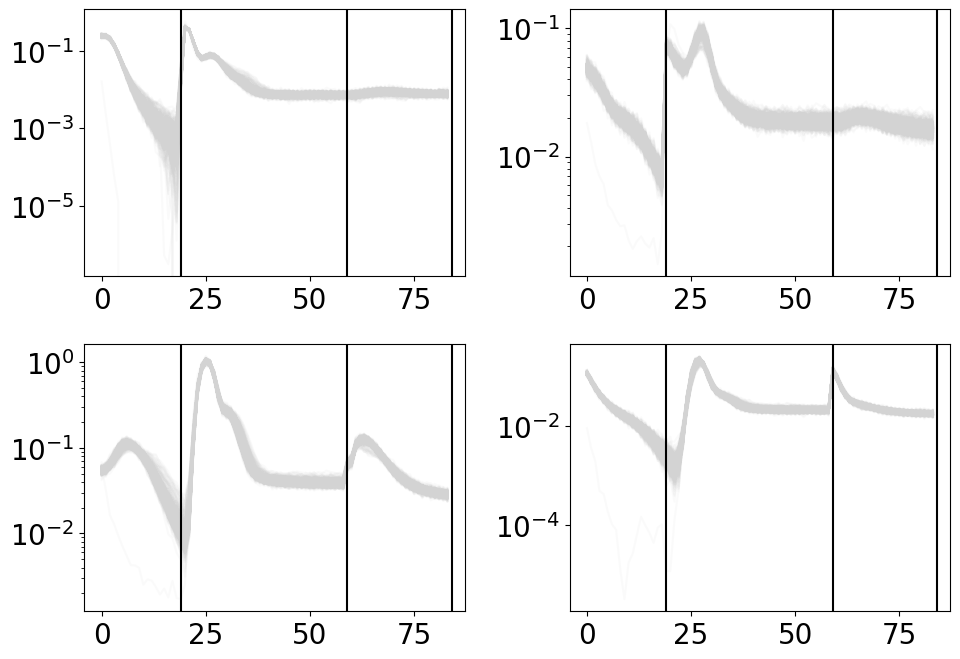

In [85]:
fig, axes = plt.subplots(2, 2)

delta_h = ((all_saved_states['hs'][:,1:,:,:]-all_saved_states['hs'][:,:-1,:,:])**2).mean(2) 
# shape = trial X time X units

axes[0,0].plot(delta_h[...,input_weight_inds[:64]].sum(-1).T.numpy(), alpha=0.1, color='lightgrey');
axes[0,1].plot(delta_h[...,input_weight_inds[64:]].sum(-1).T.numpy(), alpha=0.1, color='lightgrey');
axes[1,0].plot(delta_h[...,output_weight_inds[:64]].sum(-1).T.numpy(), alpha=0.1, color='lightgrey');
axes[1,1].plot(delta_h[...,output_weight_inds[64:]].sum(-1).T.numpy(), alpha=0.1, color='lightgrey');

for i in range(2):
    for j in range(2):
        axes[i,j].axvline(task_mdprl.T_fixation-1, color='black')
        axes[i,j].axvline(task_mdprl.T_stim+task_mdprl.T_fixation-1, color='black')
        axes[i,j].axvline(task_mdprl.T_stim+task_mdprl.T_fixation+task_mdprl.T_ch-1, color='black')
        axes[i,j].set_yscale('log')
#         axes[i,j].axvline(np.where(task_mdprl.T_rwd)[0][0]-1, color='black')
#         axes[i,j].axvline(np.where(task_mdprl.T_mask)[0][0]-1, color='black')
#         axes[i,j].axvline(np.where(task_mdprl.T_mask)[0][-1], color='black')

plt.tight_layout()


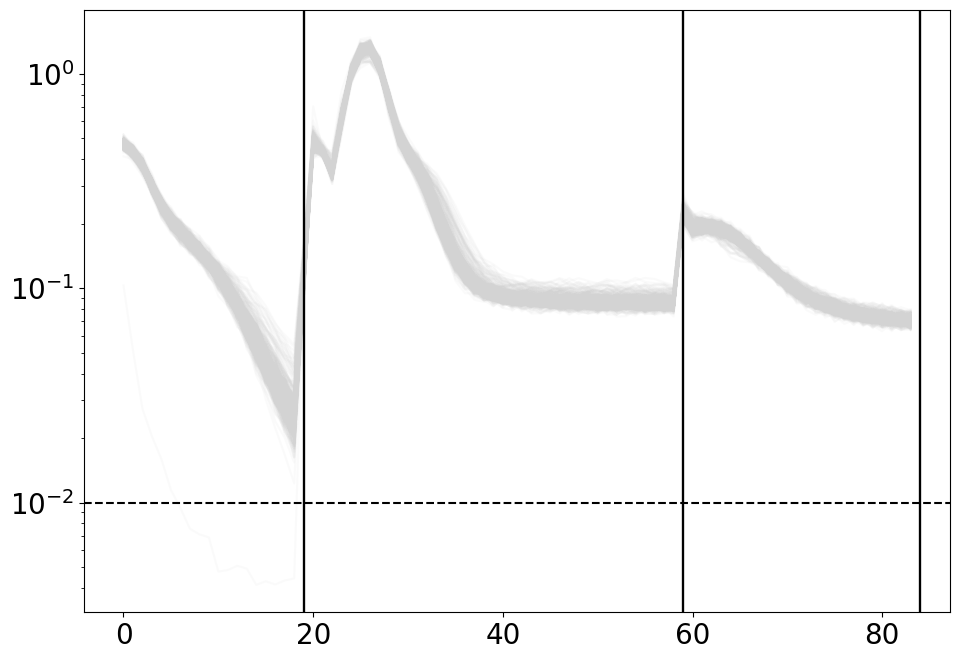

In [86]:
plt.plot(delta_h.sum(-1).T.numpy(), 
         alpha=0.1, color='lightgrey');

for i in range(2):
    for j in range(2):
        plt.axvline(task_mdprl.T_fixation-1, color='black')
        plt.axvline(task_mdprl.T_stim+task_mdprl.T_fixation-1, color='black')
        plt.axvline(task_mdprl.T_stim+task_mdprl.T_fixation+task_mdprl.T_ch-1, color='black')
#         plt.axvline(np.where(task_mdprl.T_rwd)[0][0]-1, color='black')
#         axes[i,j].axvline(np.where(task_mdprl.T_mask)[0][0]-1, color='black')
#         axes[i,j].axvline(np.where(task_mdprl.T_mask)[0][-1], color='black')

plt.axhline(0.01, linestyle='--', c='k')
plt.yscale('log')

# plt.xlim([-1, 60])

plt.tight_layout()

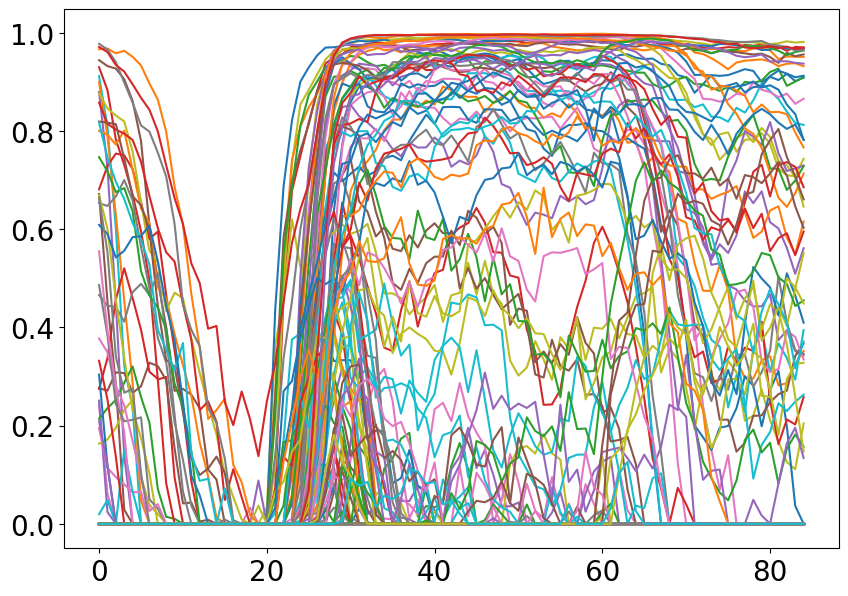

In [87]:
plt.plot(all_saved_states['hs'][np.random.randint(432),:,np.random.randint(92),:].numpy());

In [88]:
# get the gains and average firing rates necessary for further calculations

# activity at steady state of decision phase
h_avg_ch = all_saved_states['hs'][:,task_mdprl.T_fixation+task_mdprl.T_stim-1,:,:] 
# activity at steady state of choice feedback phase
h_avg_lrn = all_saved_states['hs'][:,-1,:,:]
h_gain = ((h_avg_ch>0).float()*(1-h_avg_ch**2)) # gain at steady state

print(h_avg_ch.shape, h_avg_lrn.shape, h_gain.shape)
print(model.h2o.effective_weight().detach().shape, all_saved_states['whs'].shape)


torch.Size([432, 92, 160]) torch.Size([432, 92, 160]) torch.Size([432, 92, 160])
torch.Size([27, 64]) torch.Size([432, 1, 92, 160, 160])


In [90]:
whs_no_mod = []
# all_saved_states['whs'] contains weights *after each trial*, so add initial weights back in
# whs_no_mod contains weights *during* each trial

for idx_sess in tqdm.tqdm(range(all_saved_states['hs'].shape[2])):
    model = all_models[all_saved_states['model_assignment'][idx_sess]]
    whs_no_mod.append(torch.cat([
        model.rnn.h2h.effective_weight()[None],
        model.rnn.h2h.effective_weight(all_saved_states['whs'][:-1,0,idx_sess,...])
    ]))
                      
whs_no_mod = torch.stack(whs_no_mod, 1)
print(whs_no_mod.shape)
    

100%|██████████| 92/92 [00:05<00:00, 16.41it/s]


torch.Size([432, 92, 160, 160])


In [91]:
h2o_gain_mod = []
whs_gain_mod = []
delta_ws = []

for idx_sess in tqdm.tqdm(range(all_saved_states['hs'].shape[2])):
    model = all_models[all_saved_states['model_assignment'][idx_sess]]
    # gain modulated readout
    h2o_gain_mod.append(
        h_gain[:,idx_sess:idx_sess+1,output_weight_inds[:64]]*\
        model.h2o.effective_weight().detach()[None,...])
    # gain modulated recurrent weights
    whs_gain_mod.append(
        h_gain[:,idx_sess:idx_sess+1,:]*whs_no_mod[:,idx_sess,...])
    # weight change
    delta_ws.append((model.plasticity.kappa.squeeze().abs().detach()*model.rnn.h2h.mask)[None]*\
                (h_avg_lrn[:,idx_sess][...,None]*h_avg_lrn[:,idx_sess][...,None,:]))

h2o_gain_mod = torch.stack(h2o_gain_mod, axis=1)
whs_gain_mod = torch.stack(whs_gain_mod, axis=1)
delta_ws = torch.stack(delta_ws, axis=1)

print(h2o_gain_mod.shape, whs_gain_mod.shape, delta_ws.shape)


100%|██████████| 92/92 [00:06<00:00, 15.32it/s]


torch.Size([432, 92, 27, 64]) torch.Size([432, 92, 160, 160]) torch.Size([432, 92, 160, 160])


In [92]:
h2o_gain_mod_avail = torch.empty(431, 92, 64)

for idx_trial in range(1,432):
    for idx_sess in range(92):
        curr_stimuli = all_saved_states['stimuli'][idx_trial, 0, idx_sess]
        h2o_gain_mod_avail[idx_trial-1, idx_sess] = \
            h2o_gain_mod[idx_trial,idx_sess,curr_stimuli[1]]-h2o_gain_mod[idx_trial,idx_sess,curr_stimuli[0]]


### correlation between analytical gradient and approximation

In [93]:
# invert I-jacobian 

inv_jac = torch.zeros_like(whs_gain_mod)

for idx_trial in tqdm.tqdm(range(432)):
    for idx_sess in range(92):
        try:
#             print(torch.linalg.svd(torch.eye(args['hidden_size']*args['num_areas'])-whs_gain_mod[idx_trial, idx_sess]).S.max(),
#                   torch.linalg.svd(torch.eye(args['hidden_size']*args['num_areas'])-whs_gain_mod[idx_trial, idx_sess]).S.min())
            inv_jac[idx_trial, idx_sess] = torch.linalg.pinv(
                        torch.eye(args['hidden_size']*args['num_areas'])-whs_gain_mod[idx_trial, idx_sess], 
                        rtol=0.01, atol=0.001)
        except:
            print(f"SVD failed at {idx_trial, idx_sess}")
            inv_jac[idx_trial, idx_sess] = torch.eye(args['hidden_size']*args['num_areas'])
            
print(inv_jac.shape)


100%|██████████| 432/432 [01:28<00:00,  4.87it/s]

torch.Size([432, 92, 160, 160])


In [94]:
inv_jac_times_hebb = torch.zeros_like(h_avg_ch)*torch.nan
hebb_times_hs = torch.zeros_like(h_avg_ch)*torch.nan

for idx_trial in tqdm.tqdm(range(432-1)):
    for idx_sess in range(92):
        hebb_times_hs[idx_trial, idx_sess] = \
            delta_ws[idx_trial, idx_sess]@h_avg_ch[idx_trial+1, idx_sess, :]
        inv_jac_times_hebb[idx_trial, idx_sess] = \
            (inv_jac[idx_trial+1, idx_sess]@hebb_times_hs[idx_trial, idx_sess][:,None]).squeeze()

inv_jac_times_hebb = inv_jac_times_hebb[:-1]
hebb_times_hs = hebb_times_hs[:-1]

print(inv_jac_times_hebb.shape, hebb_times_hs.shape)

100%|██████████| 431/431 [00:04<00:00, 88.51it/s] 

torch.Size([431, 92, 160]) torch.Size([431, 92, 160])


In [95]:
# calculate approximate sensitivity
approx_sensitivity = h2o_gain_mod_avail[...,None,:]@inv_jac_times_hebb[...,output_weight_inds[:64]][...,None]

removed 0 trials
Figure saved at plots/exp/test0/true_approx_sensitivity_corr.pdf


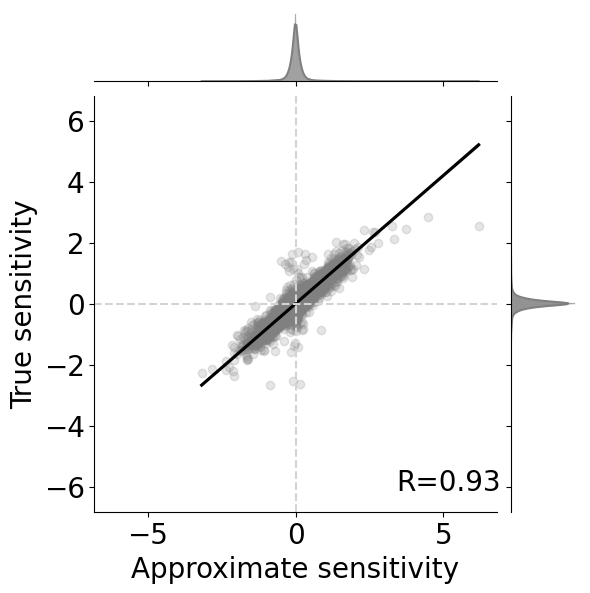

In [125]:
# plot scatter 
# fig, ax = plt.subplots(figsize=(6,6))

true_sensitivity = all_saved_states['sensitivity'][1:].squeeze().flatten().numpy()
true_sensitivity_outlier_mask = np.abs(true_sensitivity-np.median(true_sensitivity))<\
                                        np.mean(np.abs(true_sensitivity-np.median(true_sensitivity)))*20
print(f"removed {(~true_sensitivity_outlier_mask).sum()} trials")
true_sensitivity_no_outlier = true_sensitivity[true_sensitivity_outlier_mask]
approx_sensitivity_no_outlier = approx_sensitivity.detach().squeeze().flatten().numpy()
approx_sensitivity_no_outlier = approx_sensitivity_no_outlier[true_sensitivity_outlier_mask]

jp = sns.jointplot(x=approx_sensitivity_no_outlier, 
                  y=true_sensitivity_no_outlier,
                  kind='reg', color='grey', scatter_kws={'color':'grey', 'alpha':0.2}, line_kws={'color':'k'})

# scatter_kws={'color':'grey', 'alpha':0.2}, line_kws={'color':'k'}
sensitivity_approx_corr = stats.pearsonr(approx_sensitivity_no_outlier, true_sensitivity_no_outlier)

jp.ax_joint.axhline(0, color='lightgrey', linestyle='--')
jp.ax_joint.axvline(0, color='lightgrey', linestyle='--')
jp.ax_joint.set_xlabel('Approximate sensitivity')
jp.ax_joint.set_ylabel('True sensitivity')
# jp.ax_joint.axis('equal')
fig.tight_layout()

axlim = max(true_sensitivity_no_outlier.max(), approx_sensitivity_no_outlier.max())*1.1

jp.ax_joint.set_xlim([-axlim, axlim])
jp.ax_joint.set_ylim([-axlim, axlim])
jp.ax_joint.text(jp.ax_joint.get_xlim()[1]*0.5, jp.ax_joint.get_ylim()[0]*0.9, 
        f"R={np.round(sensitivity_approx_corr.statistic, 2)}", 
        fontsize=20)

with PdfPages(f'plots/{plot_save_dir}/true_approx_sensitivity_corr.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{args["exp_dir"]}/true_approx_sensitivity_corr.pdf')
          

## Calculate gain modulation of readout
$$ 
B diag(\sigma')
$$

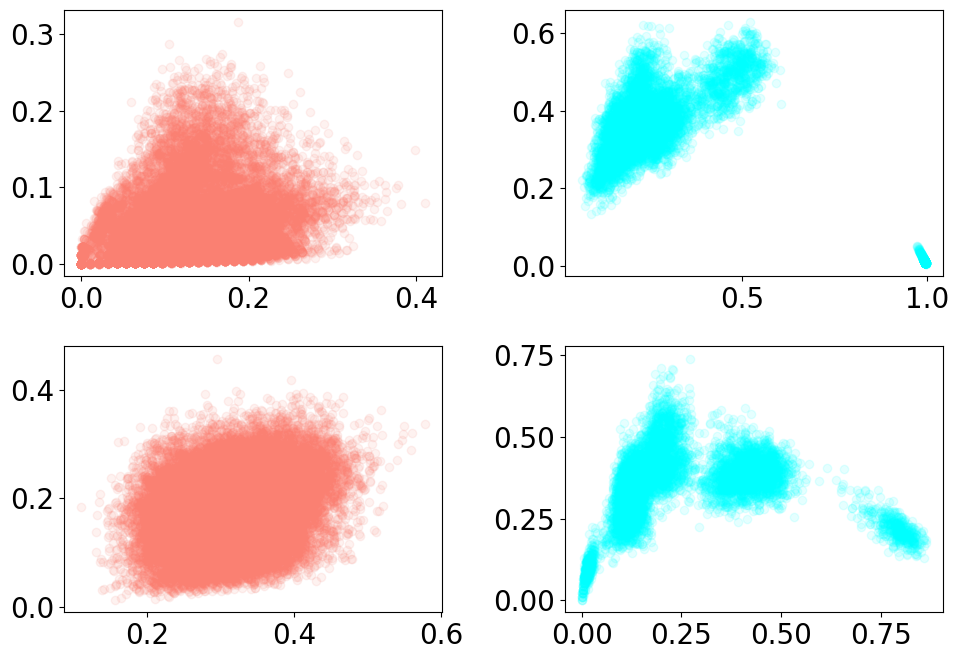

In [126]:
fig, axes = plt.subplots(2, 2)



axes[0,0].scatter(h_avg_ch[:,:,input_weight_inds[:64]].mean(1).numpy(), 
                  h_gain[:,:,input_weight_inds[:64]].mean(1).numpy(), 
                  alpha=0.1, c='salmon')
# axes[0,0].imshow(h_gain[:,input_weight_inds[:64]].T, aspect='auto')
    
axes[0,1].scatter(h_avg_ch[:,:,input_weight_inds[64:]].mean(1).numpy(), 
                  h_gain[:,:,input_weight_inds[64:]].mean(1).numpy(), 
                  alpha=0.1, c='cyan')
# axes[0,1].imshow(h_gain[:,input_weight_inds[64:]].T, aspect='auto')
    
axes[1,0].scatter(h_avg_ch[:,:,output_weight_inds[:64]].mean(1).numpy(), 
                  h_gain[:,:,output_weight_inds[:64]].mean(1).numpy(), 
                  alpha=0.1, c='salmon')
# axes[1,0].imshow(h_gain[:,output_weight_inds[:64]].T, aspect='auto')

axes[1,1].scatter(h_avg_ch[:,:,output_weight_inds[64:]].mean(1).numpy(), 
                  h_gain[:,:,output_weight_inds[64:]].mean(1).numpy(), 
                  alpha=0.1, c='cyan')
# axes[1,1].imshow(h_gain[:,output_weight_inds[64:]].T, aspect='auto')

fig.tight_layout()

In [195]:
h2o_gain_mod_variance_ratio = np.empty((432, 92, 7))

for idx_trial in tqdm.tqdm(range(args['test_N_s'])):
    for idx_sess in range(92):
        dpca_out_gain_mod = dPCA.dPCA('spc', n_components=n_components_for_dpca, regularizer=None)
        curr_h2o_gain_mod = h2o_gain_mod[idx_trial,idx_sess].numpy().T
        curr_h2o_gain_mod = curr_h2o_gain_mod[:,task_mdprl.test_sensory2stim_idx[idx_sess]]
        curr_h2o_gain_mod = curr_h2o_gain_mod.reshape((E_SIZE,3,3,3))
        low_output = dpca_out_gain_mod.fit_transform(curr_h2o_gain_mod)
        for idx_k, k in enumerate(['s','p','c','pc','sc','sp','spc']):
            h2o_gain_mod_variance_ratio[idx_trial, idx_sess, idx_k] = \
                    np.sum(dpca_out_gain_mod.explained_variance_ratio_[k])

            

  0%|          | 0/432 [00:00<?, ?it/s]/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN/rnn/dPCA/dPCA.py:980: RuntimeWarning: divide by zero encountered in divide
  return [1 - np.sum((Xr - P[:,k:k+1]@(D[:,k:k+1].T@Xr))**2, -1) / (unitwise_variance) for k in range(D.shape[1])]
/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN/rnn/dPCA/dPCA.py:980: RuntimeWarning: invalid value encountered in divide
  return [1 - np.sum((Xr - P[:,k:k+1]@(D[:,k:k+1].T@Xr))**2, -1) / (unitwise_variance) for k in range(D.shape[1])]
100%|██████████| 432/432 [01:53<00:00,  3.81it/s]


In [155]:
def get_readout_overlap_dynamic(all_model_dpca, all_sess_h2o_gain_mod, 
                                all_sess_chosen, all_sess_foregone,
                                all_sess_model_assignment, all_sess_dim_order_reverse,
                                ax):
    all_sess_choice_dir = []
    all_sess_overlap_exp_var = []

    ft_keys=['s','p','c']
    conj_keys=['pc','sc','sp']
    obj_key='spc'
    
    dim_labels = ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O']
    
    for sess_idx in tqdm.tqdm(range(92)):

        permutted_key_order = [ft_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                              [conj_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                              [obj_key]
        
        permutted_key_index = np.concatenate([
            np.array(all_sess_dim_order_reverse[sess_idx]), 
            np.array(all_sess_dim_order_reverse[sess_idx])+3,
            [6]
        ])
        
        curr_sess_dpca = all_model_dpca[all_saved_states['model_assignment'][sess_idx]]
        
        curr_sess_exp_var = np.zeros((431,7))
        curr_sess_choice_dir = np.zeros((431,7))
        
        stim_chosen_FCO = obj_to_ft_conj(all_sess_chosen[...,sess_idx], task_mdprl).squeeze()
        stim_chosen_FCO = stim_chosen_FCO[...,permutted_key_index]
        stim_foregone_FCO = obj_to_ft_conj(all_sess_foregone[...,sess_idx], task_mdprl).squeeze()
        stim_foregone_FCO = stim_foregone_FCO[...,permutted_key_index]
        
        for k_idx, k_name in enumerate(permutted_key_order):
            
            curr_sess_dim_psth = curr_sess_dpca.marginalized_psth[k_name].squeeze().reshape((args['hidden_size'], -1))
            
            choice_direction = curr_sess_dim_psth[:,stim_chosen_FCO[1:,k_idx]]\
                                    -curr_sess_dim_psth[:,stim_foregone_FCO[1:,k_idx]]            
            choice_direction = choice_direction/np.linalg.norm(choice_direction, axis=0, keepdims=True)
            
            perception_direction = curr_sess_dim_psth[:,stim_chosen_FCO[1:,k_idx]]\
                                    +curr_sess_dim_psth[:,stim_foregone_FCO[1:,k_idx]] 
            perception_direction = perception_direction/np.linalg.norm(perception_direction, axis=0, keepdims=True)
            
            h2o_reparam = all_sess_h2o_gain_mod[:, idx_sess].detach().numpy()@curr_sess_dpca.P[k_name][:E_SIZE,:]
            
            curr_sess_exp_var[:,k_idx] = (h2o_reparam**2).sum((1))\
                                        /(all_sess_h2o_gain_mod[:, idx_sess].detach().numpy()**2).sum((1))
            
            h2o_proj = all_sess_h2o_gain_mod[:, None, idx_sess].detach().numpy()@choice_direction.T[:,:E_SIZE,None]
                        
            curr_sess_choice_dir[:,k_idx] = (h2o_proj**2).sum((1)).squeeze()
            
        all_sess_overlap_exp_var.append(curr_sess_exp_var)
        all_sess_choice_dir.append(curr_sess_choice_dir)
        
    all_sess_overlap_exp_var = np.stack(all_sess_overlap_exp_var, 1)
    all_sess_choice_dir = np.stack(all_sess_choice_dir, 1)
    
    for idx_k in range(7):
        w_size = 432//8
        smth_exp_var = np.stack([
            np.convolve(all_sess_choice_dir[:,idx_sess,idx_k], np.ones(w_size)/w_size, mode='valid')
                for idx_sess in range(92)
        ], axis=1)
        
        plot_mean_and_std(ax=axes[0],
                      m=smth_exp_var.mean(1), 
                      sd=smth_exp_var.std(1)/np.sqrt(92),
                      label=dim_labels[idx_k], 
                      color=mpl.colormaps['tab10'](idx_k)*np.array([1,1,1,1]))
    for idx_k in range(7):
        w_size = 432//8
        smth_exp_var = np.stack([
            np.convolve(all_sess_overlap_exp_var[:,idx_sess,idx_k], np.ones(w_size)/w_size, mode='valid')
                for idx_sess in range(92)
        ], axis=1)
        
        plot_mean_and_std(ax=axes[1],
                      m=smth_exp_var.mean(1), 
                      sd=smth_exp_var.std(1)/np.sqrt(92),
                      label=dim_labels[idx_k], 
                      color=mpl.colormaps['tab10'](idx_k)*np.array([1,1,1,1]))
    
    return all_sess_choice_dir, all_sess_overlap_exp_var
    
    
                
        

100%|██████████| 92/92 [00:00<00:00, 207.26it/s]


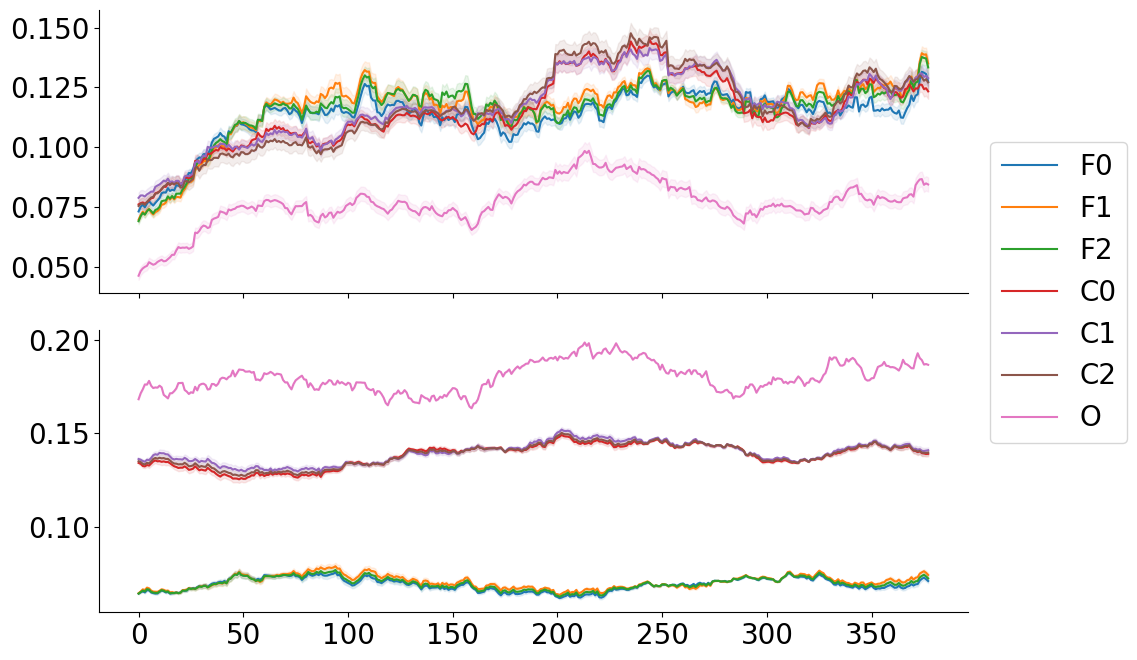

In [156]:
fig, axes = plt.subplots(2,1, sharex=True)
_, _ = get_readout_overlap_dynamic(all_model_dpca_out, h2o_gain_mod_avail,
                                   all_saved_states['choices'], all_saved_states['foregone'], 
                                   all_saved_states['model_assignment'], 
                                   task_mdprl.test_stim_dim_order, axes)
fig.tight_layout()
sns.despine()
lgd = axes[0].legend(bbox_to_anchor=(1.2, 0), loc='center right')

Figure saved at plots/exp/test0/output_gain_mod_variance.pdf


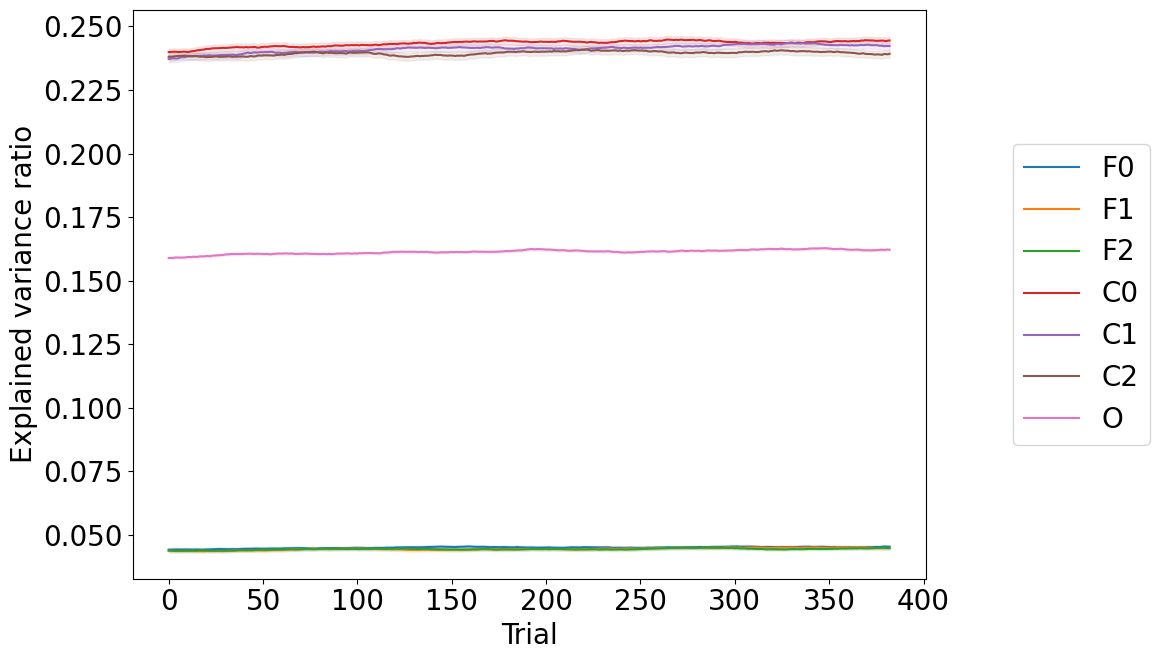

In [197]:
fig, ax = plt.subplots()


dim_labels = ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O']
for idx_k, k in enumerate(['s','p','c','pc','sc','sp','spc']):
#     ax.plot(-10, h2o_variance_ratio[:,idx_k].mean(0), marker='>', 
#             markeredgecolor='k', markerfacecolor=mpl.colormaps['tab10'](idx_k)*np.array([1,1,1,0.5]),
#            markersize=15)
#     delta_h2o_gain_mod_variance_ratio = \
#         h2o_gain_mod_variance_ratio[1:]-h2o_gain_mod_variance_ratio[:-1]

    smth_h2o_gain_mod_var_ratio = np.stack([
            np.convolve(h2o_gain_mod_variance_ratio[:,idx_sess,idx_k], np.ones(w_size)/w_size, mode='valid')
                for idx_sess in range(92)
        ], axis=1)
    plot_mean_and_std(ax=ax,
                      m=smth_h2o_gain_mod_var_ratio.mean(1), 
                      sd=smth_h2o_gain_mod_var_ratio.std(1)/np.sqrt(92),
                      label=dim_labels[idx_k], 
                      color=mpl.colormaps['tab10'](idx_k)*np.array([1,1,1,0.]))
ax.set_xlabel('Trial')
ax.set_ylabel('Explained variance ratio')
# ax.set_title('No effect of gain modulation on readout')
fig.tight_layout()
lgd = ax.legend(bbox_to_anchor=(1.3, 0.5), loc='center right')

X_time = np.tile(np.linspace(0, 1, 432)[:,None,None], (1,92,7)).reshape((-1, 1))
X_time = sm.add_constant(X_time)



with PdfPages(f'plots/{plot_save_dir}/output_gain_mod_variance.pdf') as pdf:
    pdf.savefig(fig, bbox_extra_artists=(lgd,), bbox_inches='tight')
    print(f'Figure saved at plots/{args["exp_dir"]}/output_gain_mod_variance.pdf')


## Recurrence through plastic weights
$$
(I-W_sdiag(\sigma'_{}))^{-1} = \sum_{k=0}^T (W_sdiag(\sigma'_{}))^k \approx W_sdiag(\sigma')
$$

In [181]:
rec_intra_gain_mod = []
rec_inter_ff_gain_mod = []
rec_inter_fb_gain_mod = []

for i in range(NUM_AREAS):
    rec_intra_gain_mod.append(inv_jac[...,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                             list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE)),:]
                                          [...,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                             list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])


for i in range(NUM_AREAS-1):
    rec_inter_ff_gain_mod.append(inv_jac[...,list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                                                list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE)),:]
                                            [...,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                                list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
    rec_inter_fb_gain_mod.append(inv_jac[...,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                                list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE)),:]
                                            [...,list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                                                list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))])

In [182]:
print(rec_intra_gain_mod[0].shape, rec_intra_gain_mod[1].shape,
      rec_inter_ff_gain_mod[0].shape, rec_inter_fb_gain_mod[0].shape)

torch.Size([432, 92, 80, 80]) torch.Size([432, 92, 80, 80]) torch.Size([432, 92, 80, 80]) torch.Size([432, 92, 80, 80])


In [142]:
def get_rec_overlap_dynamic(all_model_dpca_pre, all_model_dpca_post, all_sess_whs,
                            all_sess_chosen, all_sess_foregone,
                            all_sess_model_assignment, all_sess_dim_order_reverse,
                            ax):
    all_sess_choice_dir = []
    all_sess_overlap_exp_var = []


    ft_keys=['s','p','c']
    conj_keys=['pc','sc','sp']
    obj_key='spc'
    
    dim_labels = ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O']
    
    for sess_idx in tqdm.tqdm(range(92)):

        permutted_key_order = [ft_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                              [conj_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                              [obj_key]
        
        curr_sess_dpca_pre = all_model_dpca_pre[all_saved_states['model_assignment'][sess_idx]]
        curr_sess_dpca_post = all_model_dpca_post[all_saved_states['model_assignment'][sess_idx]]
        
        permutted_key_index = np.concatenate([
            np.array(all_sess_dim_order_reverse[sess_idx]), 
            np.array(all_sess_dim_order_reverse[sess_idx])+3,
            [6]
        ])
        
        curr_sess_exp_var = np.zeros((432,7,7))
        curr_sess_choice_dir = np.zeros((432,7,7))
        
        stim_chosen_FCO = obj_to_ft_conj(all_sess_chosen[...,sess_idx], task_mdprl).squeeze()
        stim_chosen_FCO = stim_chosen_FCO[...,permutted_key_index]
        stim_foregone_FCO = obj_to_ft_conj(all_sess_foregone[...,sess_idx], task_mdprl).squeeze()
        stim_foregone_FCO = stim_foregone_FCO[...,permutted_key_index]
        
        for idx_trial in range(432):
            for k_out_idx, k_out in enumerate(permutted_key_order):
                for k_in_idx, k_in in enumerate(permutted_key_order):
                    # explained variance in general
                    wh_reparam = curr_sess_dpca_post.P[k_out].T@\
                                 all_sess_whs[idx_trial, idx_sess].detach().numpy()@\
                                 curr_sess_dpca_pre.P[k_in]

                    curr_sess_exp_var[idx_trial,k_out_idx,k_in_idx] = (wh_reparam**2).sum() #/wh_reparam.shape[-1]

                    # recurrence in the discriminant direction for choice
                    curr_sess_dim_psth_pre = curr_sess_dpca_pre.marginalized_psth[k_in].squeeze().reshape((args['hidden_size'], -1))
                    choice_direction_pre = curr_sess_dim_psth_pre[:,stim_chosen_FCO[idx_trial,k_in_idx]]\
                                            -curr_sess_dim_psth_pre[:,stim_foregone_FCO[idx_trial,k_in_idx]]            
                    choice_direction_pre = choice_direction_pre/np.linalg.norm(choice_direction_pre, axis=0, keepdims=True)

                    curr_sess_dim_psth_post = curr_sess_dpca_post.marginalized_psth[k_out].squeeze().reshape((args['hidden_size'], -1))
                    choice_direction_post = curr_sess_dim_psth_post[:,stim_chosen_FCO[idx_trial,k_out_idx]]\
                                            -curr_sess_dim_psth_post[:,stim_foregone_FCO[idx_trial,k_out_idx]]            
                    choice_direction_post = choice_direction_post/np.linalg.norm(choice_direction_post, axis=0, keepdims=True)

                    wh_choice_dir = choice_direction_post.T@\
                                    all_sess_whs[idx_trial, idx_sess].detach().numpy()@\
                                    choice_direction_pre


                    curr_sess_choice_dir[idx_trial,k_out_idx,k_in_idx] = (wh_choice_dir**2).squeeze()
                
                
        all_sess_choice_dir.append(curr_sess_choice_dir)
        all_sess_overlap_exp_var.append(curr_sess_exp_var)
        
    all_sess_choice_dir = np.stack(all_sess_choice_dir, 1)
    all_sess_choice_dir_within = np.diagonal(all_sess_choice_dir, axis1=-2, axis2=-1)
    all_sess_overlap_exp_var = np.stack(all_sess_overlap_exp_var, 1)
    all_sess_overlap_exp_var_within = np.diagonal(all_sess_overlap_exp_var, axis1=-2, axis2=-1)
    
    for idx_k in range(7):
        w_size = 432//8
        smth_exp_var = np.stack([
            np.convolve(all_sess_choice_dir_within[:,idx_sess,idx_k], np.ones(w_size)/w_size, mode='valid')
                for idx_sess in range(92)
        ], axis=1)
        
        plot_mean_and_std(ax=ax,
                      m=smth_exp_var.mean(1), 
                      sd=smth_exp_var.std(1)/np.sqrt(92),
                      label=dim_labels[idx_k], 
                      color=mpl.colormaps['tab10'](idx_k)*np.array([1,1,1,1]))
    
    return all_sess_choice_dir, all_sess_overlap_exp_var
    
    
                
        

100%|██████████| 92/92 [03:48<00:00,  2.48s/it]


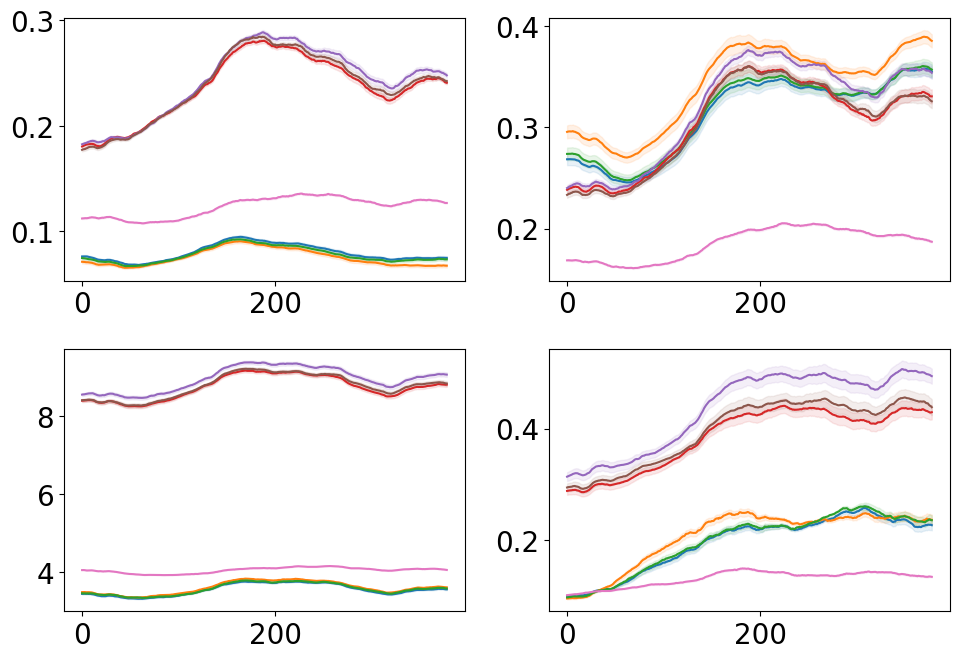

In [143]:
fig, axes = plt.subplots(2,2)

all_sess_overlap_intra_in, all_sess_overlap_exp_var_intra_in = \
                                    get_rec_overlap_dynamic(all_model_dpca_in, all_model_dpca_in, 
                                                            all_saved_states['whs']\
                                                                [...,input_weight_inds,:][...,input_weight_inds].squeeze(),
                                                            all_saved_states['choices'], all_saved_states['foregone'], 
                                                            all_saved_states['model_assignment'], 
                                                            task_mdprl.test_stim_dim_order,
                                                            axes[0,0])

all_sess_overlap_intra_out, all_sess_overlap_exp_var_intra_out = \
                                    get_rec_overlap_dynamic(all_model_dpca_out, all_model_dpca_out, 
                                                            all_saved_states['whs']\
                                                                [...,output_weight_inds,:][...,output_weight_inds].squeeze(),
                                                            all_saved_states['choices'], all_saved_states['foregone'], 
                                                            all_saved_states['model_assignment'], 
                                                            task_mdprl.test_stim_dim_order,
                                                            axes[1,1])

all_sess_overlap_inter_ff, all_sess_overlap_exp_var_inter_ff = \
                                    get_rec_overlap_dynamic(all_model_dpca_in, all_model_dpca_out, 
                                                            all_saved_states['whs']\
                                                                [...,output_weight_inds,:][...,input_weight_inds].squeeze(),
                                                            all_saved_states['choices'], all_saved_states['foregone'], 
                                                            all_saved_states['model_assignment'], 
                                                            task_mdprl.test_stim_dim_order,
                                                            axes[1,0])

all_sess_overlap_inter_fb, all_sess_overlap_exp_var_inter_fb = \
                                    get_rec_overlap_dynamic(all_model_dpca_out, all_model_dpca_in, 
                                                            all_saved_states['whs']\
                                                                [...,input_weight_inds,:][...,output_weight_inds].squeeze(),
                                                            all_saved_states['choices'], all_saved_states['foregone'], 
                                                            all_saved_states['model_assignment'], 
                                                            task_mdprl.test_stim_dim_order,
                                                            axes[0,1])

plt.tight_layout()



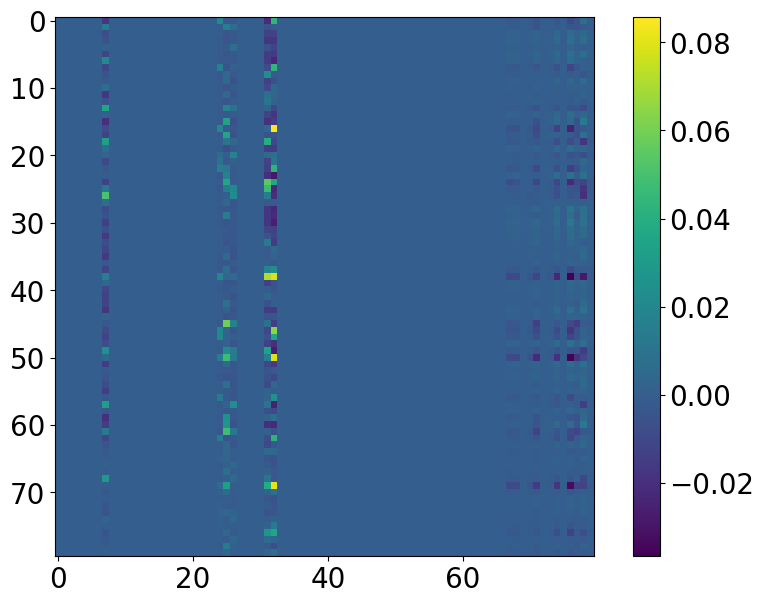

In [188]:
plt.imshow(rec_inter_ff_gain_mod[0][0,0].detach())
plt.colorbar()

100%|██████████| 92/92 [03:25<00:00,  2.23s/it]


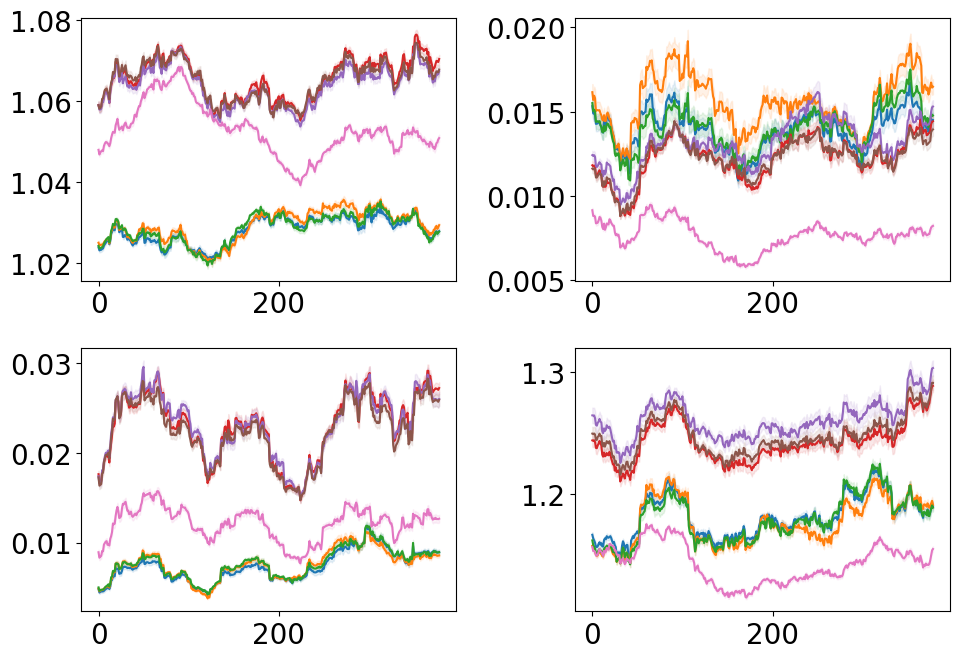

In [183]:
fig, axes = plt.subplots(2,2)

all_sess_overlap_intra_in, all_sess_overlap_exp_var_intra_in = \
                                    get_rec_overlap_dynamic(all_model_dpca_in, all_model_dpca_in, 
                                                            rec_intra_gain_mod[0],
                                                            all_saved_states['choices'], all_saved_states['foregone'], 
                                                            all_saved_states['model_assignment'], 
                                                            task_mdprl.test_stim_dim_order,
                                                            axes[0,0])

all_sess_overlap_intra_out, all_sess_overlap_exp_var_intra_out = \
                                    get_rec_overlap_dynamic(all_model_dpca_out, all_model_dpca_out, 
                                                            rec_intra_gain_mod[1],
                                                            all_saved_states['choices'], all_saved_states['foregone'], 
                                                            all_saved_states['model_assignment'], 
                                                            task_mdprl.test_stim_dim_order,
                                                            axes[1,1])

all_sess_overlap_inter_ff, all_sess_overlap_exp_var_inter_ff = \
                                    get_rec_overlap_dynamic(all_model_dpca_in, all_model_dpca_out, 
                                                            rec_inter_ff_gain_mod[0],
                                                            all_saved_states['choices'], all_saved_states['foregone'], 
                                                            all_saved_states['model_assignment'], 
                                                            task_mdprl.test_stim_dim_order,
                                                            axes[1,0])

all_sess_overlap_inter_fb, all_sess_overlap_exp_var_inter_fb = \
                                    get_rec_overlap_dynamic(all_model_dpca_out, all_model_dpca_in, 
                                                            rec_inter_fb_gain_mod[0],
                                                            all_saved_states['choices'], all_saved_states['foregone'], 
                                                            all_saved_states['model_assignment'], 
                                                            task_mdprl.test_stim_dim_order,
                                                            axes[0,1])

plt.tight_layout()



### Routing through alignment
$$
(A\odot(h_{s-1}h_{s-1}^{\top}))h_s
$$

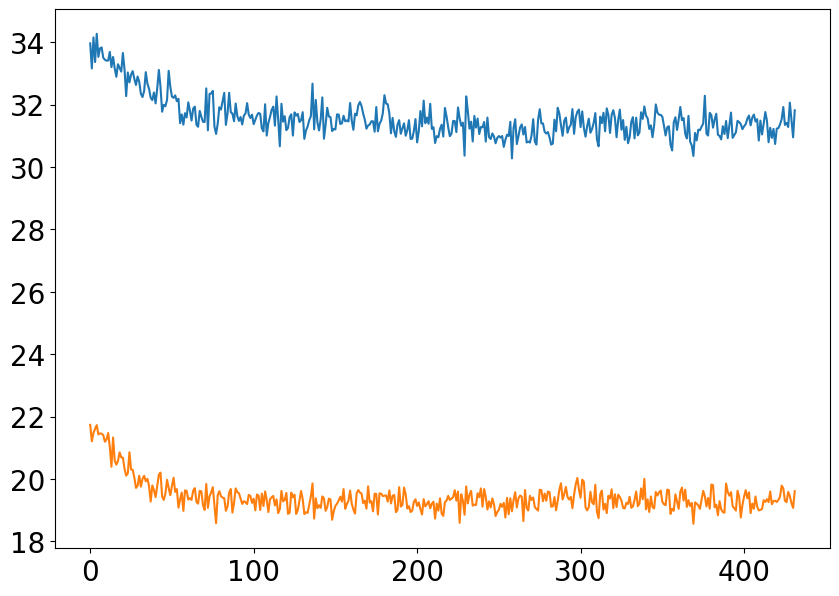

In [98]:
plt.plot((h_avg_ch**2).sum(-1).mean(1))
plt.plot((h_avg_lrn**2).sum(-1).mean(1))

In [188]:
for k,v in all_saved_states.items():
    print(k, v.shape)

whs torch.Size([432, 1, 92, 160, 160])
stimuli torch.Size([432, 1, 92, 2])
reward_probs torch.Size([432, 1, 92, 2])
choices torch.Size([432, 1, 92])
foregone torch.Size([432, 1, 92])
rewards torch.Size([432, 1, 92])
choose_better torch.Size([432, 1, 92])
hs torch.Size([432, 85, 92, 160])
sensitivity torch.Size([432, 1, 92])
model_assignment (92,)


In [102]:
def plot_hs_exp_var_dynamic(all_model_dpca, all_sess_hs, all_sess_chosen, all_sess_foregone,
                            all_sess_model_assignment, all_sess_dim_order_reverse,
                            ax):
    all_sess_overlap = []
    all_sess_choice_exp_var = []
    all_sess_no_choice_exp_var = []
    
    ft_keys=['s','p','c']
    conj_keys=['pc','sc','sp']
    obj_key='spc'
    
    dim_labels = ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O']
    
    for sess_idx in tqdm.tqdm(range(92)):

        permutted_key_order = [ft_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                              [conj_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                              [obj_key]
        permutted_key_index = np.concatenate([
            np.array(all_sess_dim_order_reverse[sess_idx]), 
            np.array(all_sess_dim_order_reverse[sess_idx])+3,
            [6]
        ])
#         print(permutted_key_order, permutted_key_index)
        
        curr_sess_dpca = all_model_dpca[all_saved_states['model_assignment'][sess_idx]]
        
        num_trials = len(all_sess_chosen)
        
        curr_sess_exp_var_choice = np.zeros((num_trials,7))
        curr_sess_exp_var_no_choice = np.zeros((num_trials,7))
        

        
        stim_chosen_FCO = obj_to_ft_conj(all_sess_chosen[...,sess_idx], task_mdprl).squeeze()
        stim_chosen_FCO = stim_chosen_FCO[...,permutted_key_index]
        stim_foregone_FCO = obj_to_ft_conj(all_sess_foregone[...,sess_idx], task_mdprl).squeeze()
        stim_foregone_FCO = stim_foregone_FCO[...,permutted_key_index]
        
        for k_idx, k_name in enumerate(permutted_key_order):
            
            curr_sess_dim_psth = curr_sess_dpca.marginalized_psth[k_name].squeeze().reshape((args['hidden_size'], -1))
            
            choice_direction = curr_sess_dim_psth[:,stim_chosen_FCO[:,k_idx]]\
                                    -curr_sess_dim_psth[:,stim_foregone_FCO[:,k_idx]]            
            choice_direction = choice_direction/np.linalg.norm(choice_direction, axis=0, keepdims=True)
            perception_direction = curr_sess_dim_psth[:,stim_chosen_FCO[:,k_idx]]\
                                    +curr_sess_dim_psth[:,stim_foregone_FCO[:,k_idx]] 
            perception_direction = perception_direction/np.linalg.norm(perception_direction, axis=0, keepdims=True)
            
            h_choice_reparam = (all_sess_hs[:, sess_idx].detach().numpy()*choice_direction.T).sum(1)
            
#             h_proj_choice = ((all_sess_hs[:, sess_idx].detach().numpy()*choice_direction.T).sum(1)\
#                                 /(choice_direction.T*choice_direction.T).sum(1))[:,None]\
#                                 *all_sess_hs[:, sess_idx].detach().numpy()
            
#             h_no_choice = all_sess_hs[:, sess_idx].detach().numpy()-h_proj_choice
            
            h_no_choice_reparam = (all_sess_hs[:, sess_idx].detach().numpy()*perception_direction.T).sum(1)

#             print(all_sess_hs[:, sess_idx].detach().numpy().shape, h_reparam.shape, choice_direction.T.shape)


            curr_sess_exp_var_choice[:,k_idx] = h_choice_reparam**2#/(all_sess_hs[:, idx_sess]**2).sum((1))
            curr_sess_exp_var_no_choice[:,k_idx] = h_no_choice_reparam**2#/(all_sess_hs[:, idx_sess]**2).sum((1))

        all_sess_choice_exp_var.append(curr_sess_exp_var_choice)
        all_sess_no_choice_exp_var.append(curr_sess_exp_var_no_choice)
        
    all_sess_choice_exp_var = np.stack(all_sess_choice_exp_var, 1)
    all_sess_no_choice_exp_var = np.stack(all_sess_no_choice_exp_var, 1)
    
    w_size = 432//8
    
    for idx_k in range(7):
        
        smth_exp_var = np.stack([
            np.convolve(all_sess_choice_exp_var[:,idx_sess,idx_k], np.ones(w_size)/w_size, mode='valid')
                for idx_sess in range(92)
        ], axis=1)
        
        
        plot_mean_and_std(ax=ax,
                      m=smth_exp_var.mean(1), 
                      sd=smth_exp_var.std(1)/np.sqrt(92), 
                      label=dim_labels[idx_k], 
                      color=mpl.colormaps['tab10'](idx_k)*np.array([1,1,1,1]))
        
#     ax.set_ylim([-ax.get_ylim()[1]*0.1, ax.get_ylim()[1]])
    
    return all_sess_choice_exp_var
    
    

100%|██████████| 92/92 [00:00<00:00, 313.18it/s]


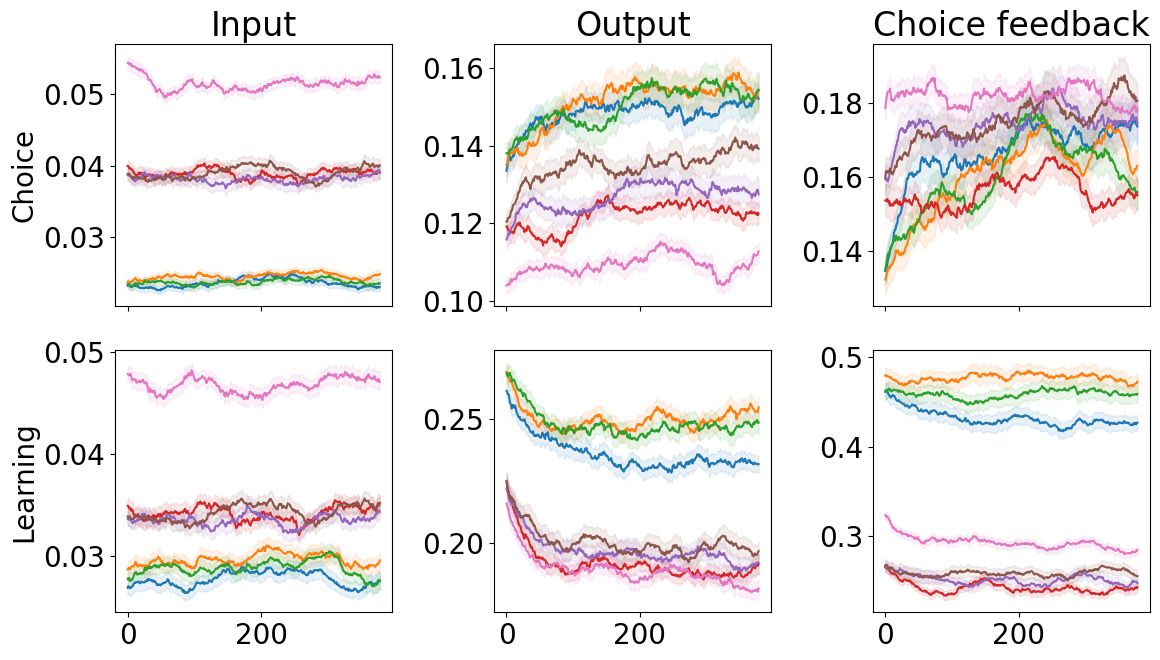

In [103]:
fig, axes = plt.subplots(2,3, figsize=(12,7), sharex=True)

_ = plot_hs_exp_var_dynamic(all_model_dpca_in, h_avg_ch[...,input_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            task_mdprl.test_stim_dim_order,
                            axes[0,0])


_ = plot_hs_exp_var_dynamic(all_model_dpca_out, h_avg_ch[...,output_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            task_mdprl.test_stim_dim_order,
                            axes[0,1])

_ = plot_hs_exp_var_dynamic(all_model_dpca_ch, h_avg_ch[...,output_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            task_mdprl.test_stim_dim_order,
                            axes[0,2])


_ = plot_hs_exp_var_dynamic(all_model_dpca_in, h_avg_lrn[...,input_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            task_mdprl.test_stim_dim_order,
                            axes[1,0])


_ = plot_hs_exp_var_dynamic(all_model_dpca_out, h_avg_lrn[...,output_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            task_mdprl.test_stim_dim_order,
                            axes[1,1])

_ = plot_hs_exp_var_dynamic(all_model_dpca_ch, h_avg_lrn[...,output_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            task_mdprl.test_stim_dim_order,
                            axes[1,2])

axes[0,0].set_ylabel('Choice')
axes[1,0].set_ylabel('Learning')

axes[0,0].set_title('Input')
axes[0,1].set_title('Output')
axes[0,2].set_title('Choice feedback')

plt.tight_layout()

100%|██████████| 92/92 [00:00<00:00, 316.09it/s]


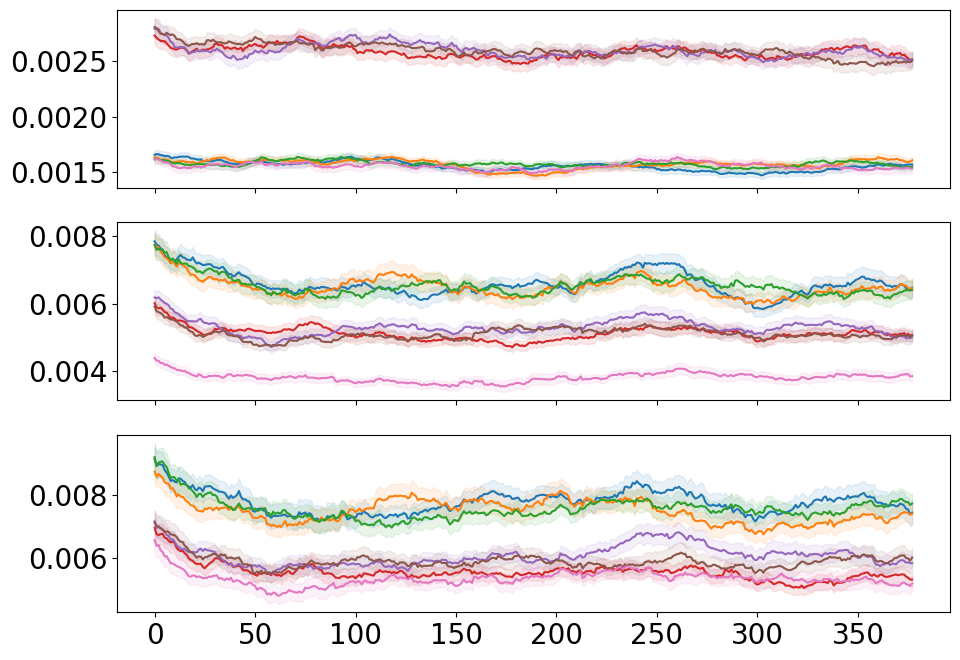

In [105]:
fig, axes = plt.subplots(3,sharex=True)

_ = plot_hs_exp_var_dynamic(all_model_dpca_in, hebb_times_hs[...,input_weight_inds], 
                            all_saved_states['choices'][1:], all_saved_states['foregone'][1:], 
                            all_saved_states['model_assignment'], 
                            task_mdprl.test_stim_dim_order,
                            axes[0])


_ = plot_hs_exp_var_dynamic(all_model_dpca_out, hebb_times_hs[...,output_weight_inds], 
                            all_saved_states['choices'][1:], all_saved_states['foregone'][1:], 
                            all_saved_states['model_assignment'], 
                            task_mdprl.test_stim_dim_order,
                            axes[1])

_ = plot_hs_exp_var_dynamic(all_model_dpca_ch, hebb_times_hs[...,output_weight_inds], 
                            all_saved_states['choices'][1:], all_saved_states['foregone'][1:], 
                            all_saved_states['model_assignment'], 
                            task_mdprl.test_stim_dim_order,
                            axes[2])

plt.tight_layout()

In [ ]:
# 201->120 120->[021, 201] X 
# 102 210 012 021 +

In [134]:
iii=7

print(task_mdprl.test_stim_dim_order[iii])
print(task_mdprl.test_stim_dim_order_reverse[iii])
print(task_mdprl.test_stim_val_order[iii])
print(task_mdprl.test_stim_val_order_reverse[iii])
print(task_mdprl.test_stim2sensory_idx[iii].reshape((3,3,3)))
print(
    obj_to_ft_conj(task_mdprl.test_stim2sensory_idx[iii].reshape((3,3,3)), task_mdprl)
)


[2 0 1]
[1 2 0]
[[0 2 1]
 [2 0 1]
 [2 1 0]]
[[0 2 1]
 [1 2 0]
 [2 1 0]]
[[[24 21 18]
  [ 6  3  0]
  [15 12  9]]

 [[26 23 20]
  [ 8  5  2]
  [17 14 11]]

 [[25 22 19]
  [ 7  4  1]
  [16 13 10]]]
[[[[ 2  2  0  6  6  8 24]
   [ 2  1  0  3  6  7 21]
   [ 2  0  0  0  6  6 18]]

  [[ 0  2  0  6  0  2  6]
   [ 0  1  0  3  0  1  3]
   [ 0  0  0  0  0  0  0]]

  [[ 1  2  0  6  3  5 15]
   [ 1  1  0  3  3  4 12]
   [ 1  0  0  0  3  3  9]]]


 [[[ 2  2  2  8  8  8 26]
   [ 2  1  2  5  8  7 23]
   [ 2  0  2  2  8  6 20]]

  [[ 0  2  2  8  2  2  8]
   [ 0  1  2  5  2  1  5]
   [ 0  0  2  2  2  0  2]]

  [[ 1  2  2  8  5  5 17]
   [ 1  1  2  5  5  4 14]
   [ 1  0  2  2  5  3 11]]]


 [[[ 2  2  1  7  7  8 25]
   [ 2  1  1  4  7  7 22]
   [ 2  0  1  1  7  6 19]]

  [[ 0  2  1  7  1  2  7]
   [ 0  1  1  4  1  1  4]
   [ 0  0  1  1  1  0  1]]

  [[ 1  2  1  7  4  5 16]
   [ 1  1  1  4  4  4 13]
   [ 1  0  1  1  4  3 10]]]]


In [90]:
iii = 1
dim = 1


print(task_mdprl.test_stim_dim_order[iii])
print(task_mdprl.test_stim_val_order[iii])

for i in range(9):
    print((all_saved_states['reward_probs'][...,iii,:][
                obj_to_ft_conj(all_saved_states['stimuli'][:,:,iii,:], task_mdprl)[...,dim]==i]).mean(), 
          (obj_to_ft_conj(all_saved_states['choices'][:,:,iii], task_mdprl)[...,dim]==i).sum(),  
          (all_saved_states['rewards'][...,iii][
                obj_to_ft_conj(all_saved_states['choices'][:,:,iii], task_mdprl)[...,dim]==i]).mean())
    if (i+1)%3==0:
        print()

[2 1 0]
[[2 1 0]
 [1 2 0]
 [2 0 1]]
tensor(0.4822, dtype=torch.float64) 138 tensor(0.6087)
tensor(0.5178, dtype=torch.float64) 148 tensor(0.5946)
tensor(0.5000, dtype=torch.float64) 146 tensor(0.5890)

tensor(nan, dtype=torch.float64) 0 tensor(nan)
tensor(nan, dtype=torch.float64) 0 tensor(nan)
tensor(nan, dtype=torch.float64) 0 tensor(nan)

tensor(nan, dtype=torch.float64) 0 tensor(nan)
tensor(nan, dtype=torch.float64) 0 tensor(nan)
tensor(nan, dtype=torch.float64) 0 tensor(nan)



In [106]:
 def get_hs_overlap_dynamic(all_model_dpca, all_sess_hs, 
                            all_sess_model_assignment, all_sess_dim_order_reverse,
                            ax):
    all_sess_overlap = []
    all_sess_overlap_exp_var = []
#     all_sess_overlap_exp_var_within = []
#     all_sess_overlap_exp_var_between = []

    ft_keys=['s','p','c']
    conj_keys=['pc','sc','sp']
    obj_key='spc'
    
    dim_labels = ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O']
    
    for sess_idx in tqdm.tqdm(range(92)):

        permutted_key_order = [ft_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                          [conj_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                          [obj_key]
        
        curr_sess_dpca = all_model_dpca[all_saved_states['model_assignment'][sess_idx]]
        
        curr_sess_exp_var = np.zeros((432,7))
        
        for k_idx, k_name in enumerate(permutted_key_order):
            
            h_reparam = all_sess_hs[:, sess_idx].detach().numpy()@curr_sess_dpca.P[k_name]

            curr_sess_exp_var[:,k_idx] = (h_reparam**2).sum((1))#/h_reparam.shape[1]#/(all_sess_hs[:, idx_sess]**2).sum((1))

        all_sess_overlap_exp_var.append(curr_sess_exp_var)
        
    all_sess_overlap_exp_var = np.stack(all_sess_overlap_exp_var, 1)
    all_sess_overlap_exp_var_within = np.diagonal(all_sess_overlap_exp_var, axis1=-2, axis2=-1)
    
    
    w_size = 40
    
    for idx_k in range(7):
        
        smth_exp_var = np.stack([
            np.convolve(all_sess_overlap_exp_var[:,idx_sess,idx_k], np.ones(w_size)/w_size, mode='valid')
                for idx_sess in range(92)
        ], axis=1)
        
        
        plot_mean_and_std(ax=ax,
                      m=smth_exp_var.mean(1), 
                      sd=smth_exp_var.std(1)/np.sqrt(92), 
                      label=dim_labels[idx_k], 
                      color=mpl.colormaps['tab10'](idx_k)*np.array([1,1,1,1]))
    
    return all_sess_overlap_exp_var
    
    
                

    

100%|██████████| 92/92 [00:00<00:00, 2020.08it/s]


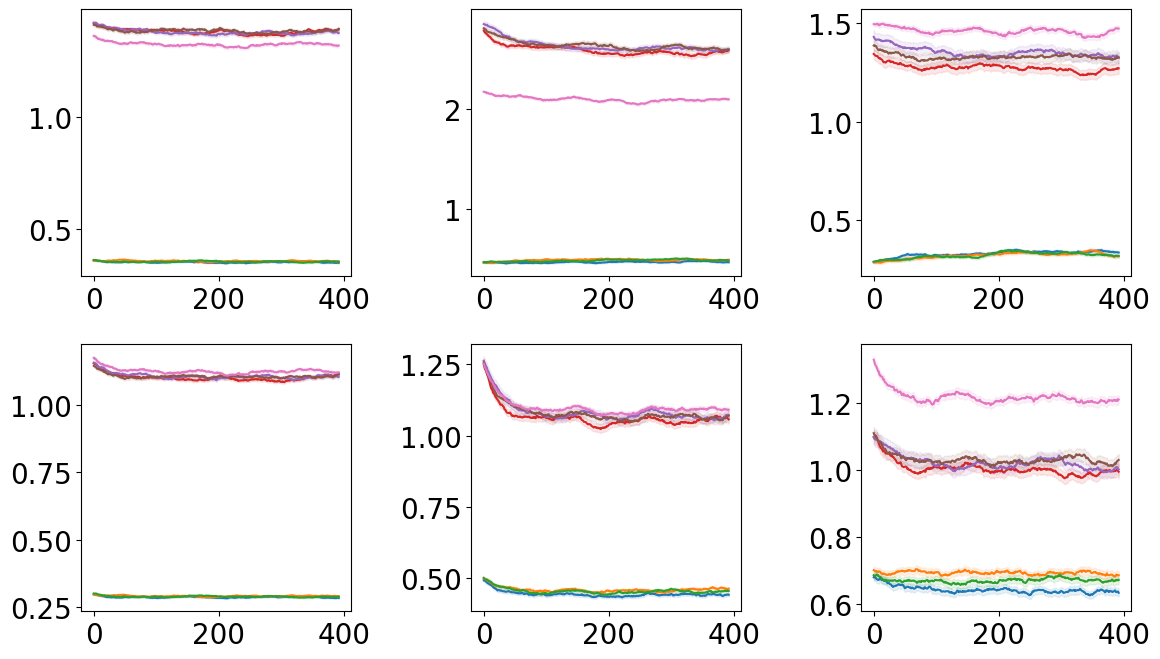

In [107]:
fig, axes = plt.subplots(2,3, figsize=(12,7))

_ = get_hs_overlap_dynamic(all_model_dpca_in, h_avg_ch[...,input_weight_inds], 
                       all_saved_states['model_assignment'], 
                       task_mdprl.test_stim_dim_order,
                            axes[0,0])


_ = get_hs_overlap_dynamic(all_model_dpca_out, h_avg_ch[...,output_weight_inds], 
                       all_saved_states['model_assignment'], 
                       task_mdprl.test_stim_dim_order,
                            axes[0,1])

_ = get_hs_overlap_dynamic(all_model_dpca_ch, h_avg_ch[...,output_weight_inds], 
                       all_saved_states['model_assignment'], 
                       task_mdprl.test_stim_dim_order,
                            axes[0,2])


_ = get_hs_overlap_dynamic(all_model_dpca_in, h_avg_lrn[...,input_weight_inds], 
                       all_saved_states['model_assignment'], 
                       task_mdprl.test_stim_dim_order,
                            axes[1,0])


_ = get_hs_overlap_dynamic(all_model_dpca_out, h_avg_lrn[...,output_weight_inds], 
                       all_saved_states['model_assignment'], 
                       task_mdprl.test_stim_dim_order,
                            axes[1,1])

_ = get_hs_overlap_dynamic(all_model_dpca_ch, h_avg_lrn[...,output_weight_inds], 
                       all_saved_states['model_assignment'], 
                       task_mdprl.test_stim_dim_order,
                            axes[1,2])

plt.tight_layout()

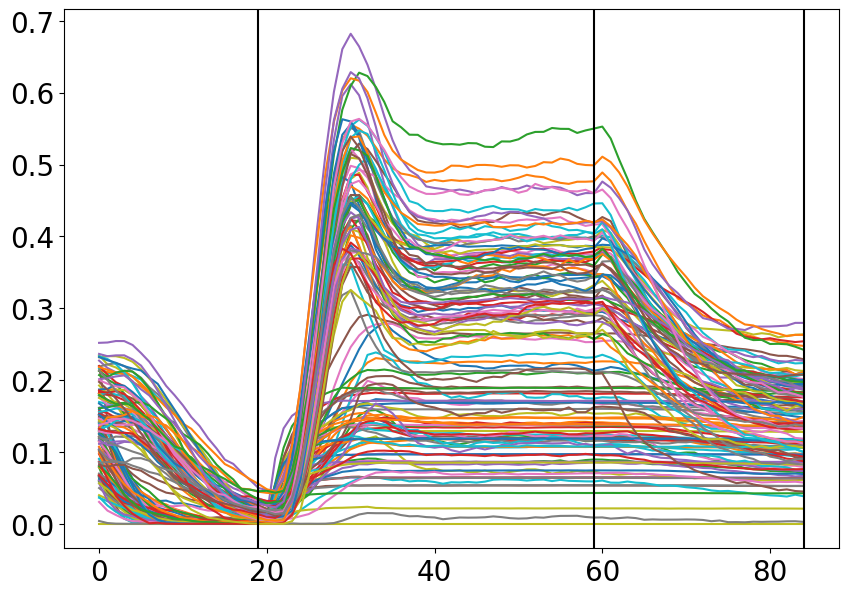

In [108]:
plt.plot(all_saved_states['hs'][1,:,:,:128].mean(1).numpy());
plt.axvline(task_mdprl.T_fixation-1, color='black')
plt.axvline(task_mdprl.T_stim+task_mdprl.T_fixation-1, color='black')
plt.axvline(task_mdprl.T_stim+task_mdprl.T_fixation+task_mdprl.T_ch-1, color='black')
# plt.axvline(np.where(task_mdprl.T_rwd)[0][0], color='black')
# plt.colorbar()